In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pandas_datareader import data as pdr
import matplotlib.mlab as mlab
%matplotlib inline
import seaborn as sns
sns.set()
from scipy import stats
import sklearn
print(sklearn.__version__)

0.23.2


In [2]:
#Leitura de uma planilha de excel com várias sheets
def read_excel_sheets (ExcelFileName):
    xls = pd.ExcelFile(ExcelFileName)
    workbook_sheets = xls.sheet_names

    df1 = pd.read_excel(xls,workbook_sheets[0], skiprows=1)
    df2 = pd.read_excel(xls,workbook_sheets[1], skiprows=1)
    
    return df1, df2

In [3]:
def read_bp_dre(codigo_acao):

    excel_filename = codigo_acao+'.xls'
    df_BP, df_DRE =  read_excel_sheets(excel_filename)

    #Susbstituindo nomes de colunas que faltam
    df_BP.rename(columns={'Unnamed: 0':'DATA'}, inplace=True)
    df_BP.set_index('DATA') 
    df_DRE.rename(columns={df_DRE.columns[0]:'DATA'}, inplace=True)
    df_DRE.set_index('DATA')

    #Transposição dos dados
    df_BP = df_BP.T
    df_DRE = df_DRE.T

    #Definindo nomes das colunas novas e deletando linha que esses nomes
    df_BP.columns = df_BP.iloc[0]
    df_DRE.columns = df_DRE.iloc[0]
    df_BP = df_BP.iloc[1:]
    df_DRE = df_DRE.iloc[1:]

    #Define Datetime index
    df_BP.index = pd.to_datetime(df_BP.index)
    df_BP.sort_index(inplace=True)
    df_DRE.index = pd.to_datetime(df_DRE.index)
    df_DRE.sort_index(inplace=True)
    
    df_DRE['Empresa'] = codigo_acao
    df_BP['Empresa'] = codigo_acao

    return df_BP, df_DRE

def read_cotacao_hist(codigo_acao, data_ini, data_fim):

    codigo_acao = codigo_acao + ".SA" 
    df_cotacao = pdr.DataReader(codigo_acao, "yahoo", start=data_ini, end=data_fim).reset_index()
    
    return df_cotacao

# Leitura dos dados das empresas

In [4]:
empresa = 'PSSA3'
data_ini = '2005, 6, 10'
data_fim = '2021, 1, 06'
df_BP, df_DRE = read_bp_dre(empresa)
df_cotacao = read_cotacao_hist(empresa,data_ini, data_fim)

# Engenharia de Variáveis

In [5]:
df_BP_DRE = df_DRE.merge(df_BP, left_index=True, right_index=True, how='inner') 

In [6]:
df_BP_DRE.tail()

DATA,Receita Bruta de Vendas e/ou Serviços,Deduções da Receita Bruta,Receita Líquida de Vendas e/ou Serviços,Custo de Bens e/ou Serviços Vendidos,Resultado Bruto,Despesas Com Vendas,Despesas Gerais e Administrativas,Perdas pela Não Recuperabilidade de Ativos,Outras Receitas Operacionais,Outras Despesas Operacionais,...,Capital Social Realizado,Reservas de Capital,Reservas de Reavaliação,Reservas de Lucros,Lucros/Prejuízos Acumulados,Ajustes de Avaliação Patrimonial,Ajustes Acumulados de Conversão,Outros Resultados Abrangentes,Adiantamento para Futuro Aumento Capital,Empresa_y
2019-09-30,NaN,NaN,1.18534e+06,-476608,708728,-91370,-148326,0,0,-66157,...,2.85109e+06,0,71009,2.47713e+06,524108,5264,0,96225,0,SAPR3
2019-12-31,NaN,NaN,1.33962e+06,-501234,838384,-92336,-162825,-19391,0,-17601,...,2.85109e+06,0,69559,3.30677e+06,0,5196,0,-58697,0,SAPR3
2020-03-31,NaN,NaN,1.24614e+06,-461545,784591,-95715,-157209,0,0,-96374,...,3.99614e+06,0,68208,2.16172e+06,257429,5143,0,-58697,0,SAPR3
2020-06-30,NaN,NaN,1.15004e+06,-479679,670360,-101360,-168215,0,0,-17327,...,3.99614e+06,0,66890,2.08779e+06,392573,5016,0,-58697,0,SAPR3
2020-09-30,NaN,NaN,1.16669e+06,-503668,663023,-124691,-217998,0,0,-19725,...,3.99614e+06,0,65620,2.08779e+06,558465,4974,0,-58697,0,SAPR3


In [7]:
#Filtro de Dados Inconsistentes
df_BP_DRE = df_BP_DRE.loc[df_BP_DRE['Receita Líquida de Vendas e/ou Serviços']!=0.0]

#Engenharia de Variáveis
df_BP_DRE['ReceitaLiq_Anual'] = df_BP_DRE['Receita Líquida de Vendas e/ou Serviços'].rolling(4).sum()

df_BP_DRE['LucroLiq_Anual'] = df_BP_DRE['Lucro/Prejuízo do Período'].rolling(4).sum()

df_BP_DRE['EBIT_Anual'] = df_BP_DRE['Resultado Antes Tributação/Participações'].rolling(4).sum()

df_BP_DRE['Despesas_G&A_Anual'] = df_BP_DRE['Despesas Gerais e Administrativas'].rolling(4).sum()*-1

df_BP_DRE['Despesas_G&A_Anual/Receitas'] = df_BP_DRE['Despesas_G&A_Anual'] / df_BP_DRE['ReceitaLiq_Anual']

df_BP_DRE['(Despesas+Custos)/Receitas'] = ((df_BP_DRE['Despesas Gerais e Administrativas'].rolling(4).sum()*-1)
         + (df_BP_DRE['Custo de Bens e/ou Serviços Vendidos'].rolling(4).sum()*-1)
         + (df_BP_DRE['Outras Despesas Operacionais'].rolling(4).sum()*-1)
         + (df_BP_DRE['Despesas Com Vendas'].rolling(4).sum()*-1))/df_BP_DRE['Receita Líquida de Vendas e/ou Serviços'].rolling(4).sum()

df_BP_DRE['Despesas_Financeiras_Anuais']= df_BP_DRE['Despesas Financeiras'].rolling(4).sum()*-1

df_BP_DRE['Marg_EBIT'] = df_BP_DRE['Resultado Antes Tributação/Participações']/df_BP_DRE['Receita Líquida de Vendas e/ou Serviços']

df_BP_DRE['Marg_Liq'] = df_BP_DRE['Lucro/Prejuízo do Período']/df_BP_DRE['Receita Líquida de Vendas e/ou Serviços']

df_BP_DRE['EBIT/Ativos'] = df_BP_DRE['EBIT_Anual']/df_BP_DRE['Ativo Total']

df_BP_DRE['ROIC'] = df_BP_DRE['EBIT_Anual']/(
    df_BP_DRE['Ativo Total']-df_BP_DRE['Ativo Circulante'])

df_BP_DRE['ROE'] = df_BP_DRE['LucroLiq_Anual']/(df_BP_DRE['Patrimônio Líquido'])



df_BP_DRE['SIN_MES'] = np.sin(2*np.pi*df_BP_DRE.index.month/12)
df_BP_DRE['COS_MES'] = np.cos(2*np.pi*df_BP_DRE.index.month/12)


#Criação do dataframe com as cotações médias mensais no mês corrente ao balanço
df_cotacao_mes = df_cotacao.resample('M', on='Date', convention='end').mean()

In [8]:
df_BP_DRE.tail()

DATA,Receita Bruta de Vendas e/ou Serviços,Deduções da Receita Bruta,Receita Líquida de Vendas e/ou Serviços,Custo de Bens e/ou Serviços Vendidos,Resultado Bruto,Despesas Com Vendas,Despesas Gerais e Administrativas,Perdas pela Não Recuperabilidade de Ativos,Outras Receitas Operacionais,Outras Despesas Operacionais,...,Despesas_G&A_Anual/Receitas,(Despesas+Custos)/Receitas,Despesas_Financeiras_Anuais,Marg_EBIT,Marg_Liq,EBIT/Ativos,ROIC,ROE,SIN_MES,COS_MES
2019-09-30,NaN,NaN,1.18534e+06,-476608,708728,-91370,-148326,0,0,-66157,...,0.130494,0.664948,239189.000,0.300776,0.205545,0.113495,0.125135,0.168258,-1.000000e+00,-1.836970e-16
2019-12-31,NaN,NaN,1.33962e+06,-501234,838384,-92336,-162825,-19391,0,-17601,...,0.124196,0.648657,245916.992,0.372598,0.288381,0.12177,0.135008,0.174935,-2.449294e-16,1.000000e+00
2020-03-31,NaN,NaN,1.24614e+06,-461545,784591,-95715,-157209,0,0,-96374,...,0.125623,0.646200,255244.992,0.305955,0.205455,0.120223,0.138634,0.173954,1.000000e+00,6.123234e-17
2020-06-30,NaN,NaN,1.15004e+06,-479679,670360,-101360,-168215,0,0,-17327,...,0.129355,0.636822,242147.992,0.305132,0.247284,0.123921,0.143741,0.180343,1.224647e-16,-1.000000e+00
2020-09-30,NaN,NaN,1.16669e+06,-503668,663023,-124691,-217998,0,0,-19725,...,0.144059,0.656300,254353.992,0.208483,0.141066,0.112396,0.130684,0.164001,-1.000000e+00,-1.836970e-16


# Cria dataframe consolidado

In [9]:
df_consolidado = df_BP_DRE.merge(df_cotacao_mes,left_index=True, right_index=True, how='inner')

df_consolidado['cotacao_futura'] = df_consolidado['Close'].shift(-1)

In [10]:
df_consolidado.tail()

,Receita Bruta de Vendas e/ou Serviços,Deduções da Receita Bruta,Receita Líquida de Vendas e/ou Serviços,Custo de Bens e/ou Serviços Vendidos,Resultado Bruto,Despesas Com Vendas,Despesas Gerais e Administrativas,Perdas pela Não Recuperabilidade de Ativos,Outras Receitas Operacionais,Outras Despesas Operacionais,...,ROE,SIN_MES,COS_MES,High,Low,Open,Close,Volume,Adj Close,cotacao_futura
2019-09-30,NaN,NaN,1.18534e+06,-476608,708728,-91370,-148326,0,0,-66157,...,0.168258,-1.000000e+00,-1.836970e-16,19.417619,18.774762,19.275238,18.954762,17538.095238,18.302586,17.022632
2019-12-31,NaN,NaN,1.33962e+06,-501234,838384,-92336,-162825,-19391,0,-17601,...,0.174935,-2.449294e-16,1.000000e+00,17.235789,16.925790,17.078947,17.022632,103468.421053,16.436935,14.058031
2020-03-31,NaN,NaN,1.24614e+06,-461545,784591,-95715,-157209,0,0,-96374,...,0.173954,1.000000e+00,6.123234e-17,14.962879,13.482879,14.462121,14.058031,145472.727273,13.650377,6.888095
2020-06-30,NaN,NaN,1.15004e+06,-479679,670360,-101360,-168215,0,0,-17327,...,0.180343,1.224647e-16,-1.000000e+00,7.145238,6.723810,6.946667,6.888095,317090.476190,6.688355,5.569524
2020-09-30,NaN,NaN,1.16669e+06,-503668,663023,-124691,-217998,0,0,-19725,...,0.164001,-1.000000e+00,-1.836970e-16,5.683333,5.496190,5.611905,5.569524,196414.285714,5.485599,NaN


In [11]:
for col in df_consolidado.columns:
    print(col)

Receita Bruta de Vendas e/ou Serviços
Deduções da Receita Bruta
Receita Líquida de Vendas e/ou Serviços
Custo de Bens e/ou Serviços Vendidos
Resultado Bruto
Despesas Com Vendas
Despesas Gerais e Administrativas
Perdas pela Não Recuperabilidade de Ativos 
Outras Receitas Operacionais
Outras Despesas Operacionais
Resultado da Equivalência Patrimonial
Financeiras
Receitas Financeiras
Despesas Financeiras
Resultado Não Operacional
Receitas
Despesas
Resultado Antes Tributação/Participações
Provisão para IR e Contribuição Social
IR Diferido
Participações/Contribuições Estatutárias
Reversão dos Juros sobre Capital Próprio
Part. de Acionistas Não Controladores
Lucro/Prejuízo do Período
Empresa_x
Ativo Total
Ativo Circulante
Caixa e Equivalentes de Caixa
Aplicações Financeiras
Contas a Receber
Estoques
Ativos Biológicos
Tributos a Recuperar
Despesas Antecipadas
Outros Ativos Circulantes
Ativo Realizável a Longo Prazo
Aplicações Financeiras Avaliadas a Valor Justo
Aplicações Financeiras Avaliada

# Gráficos

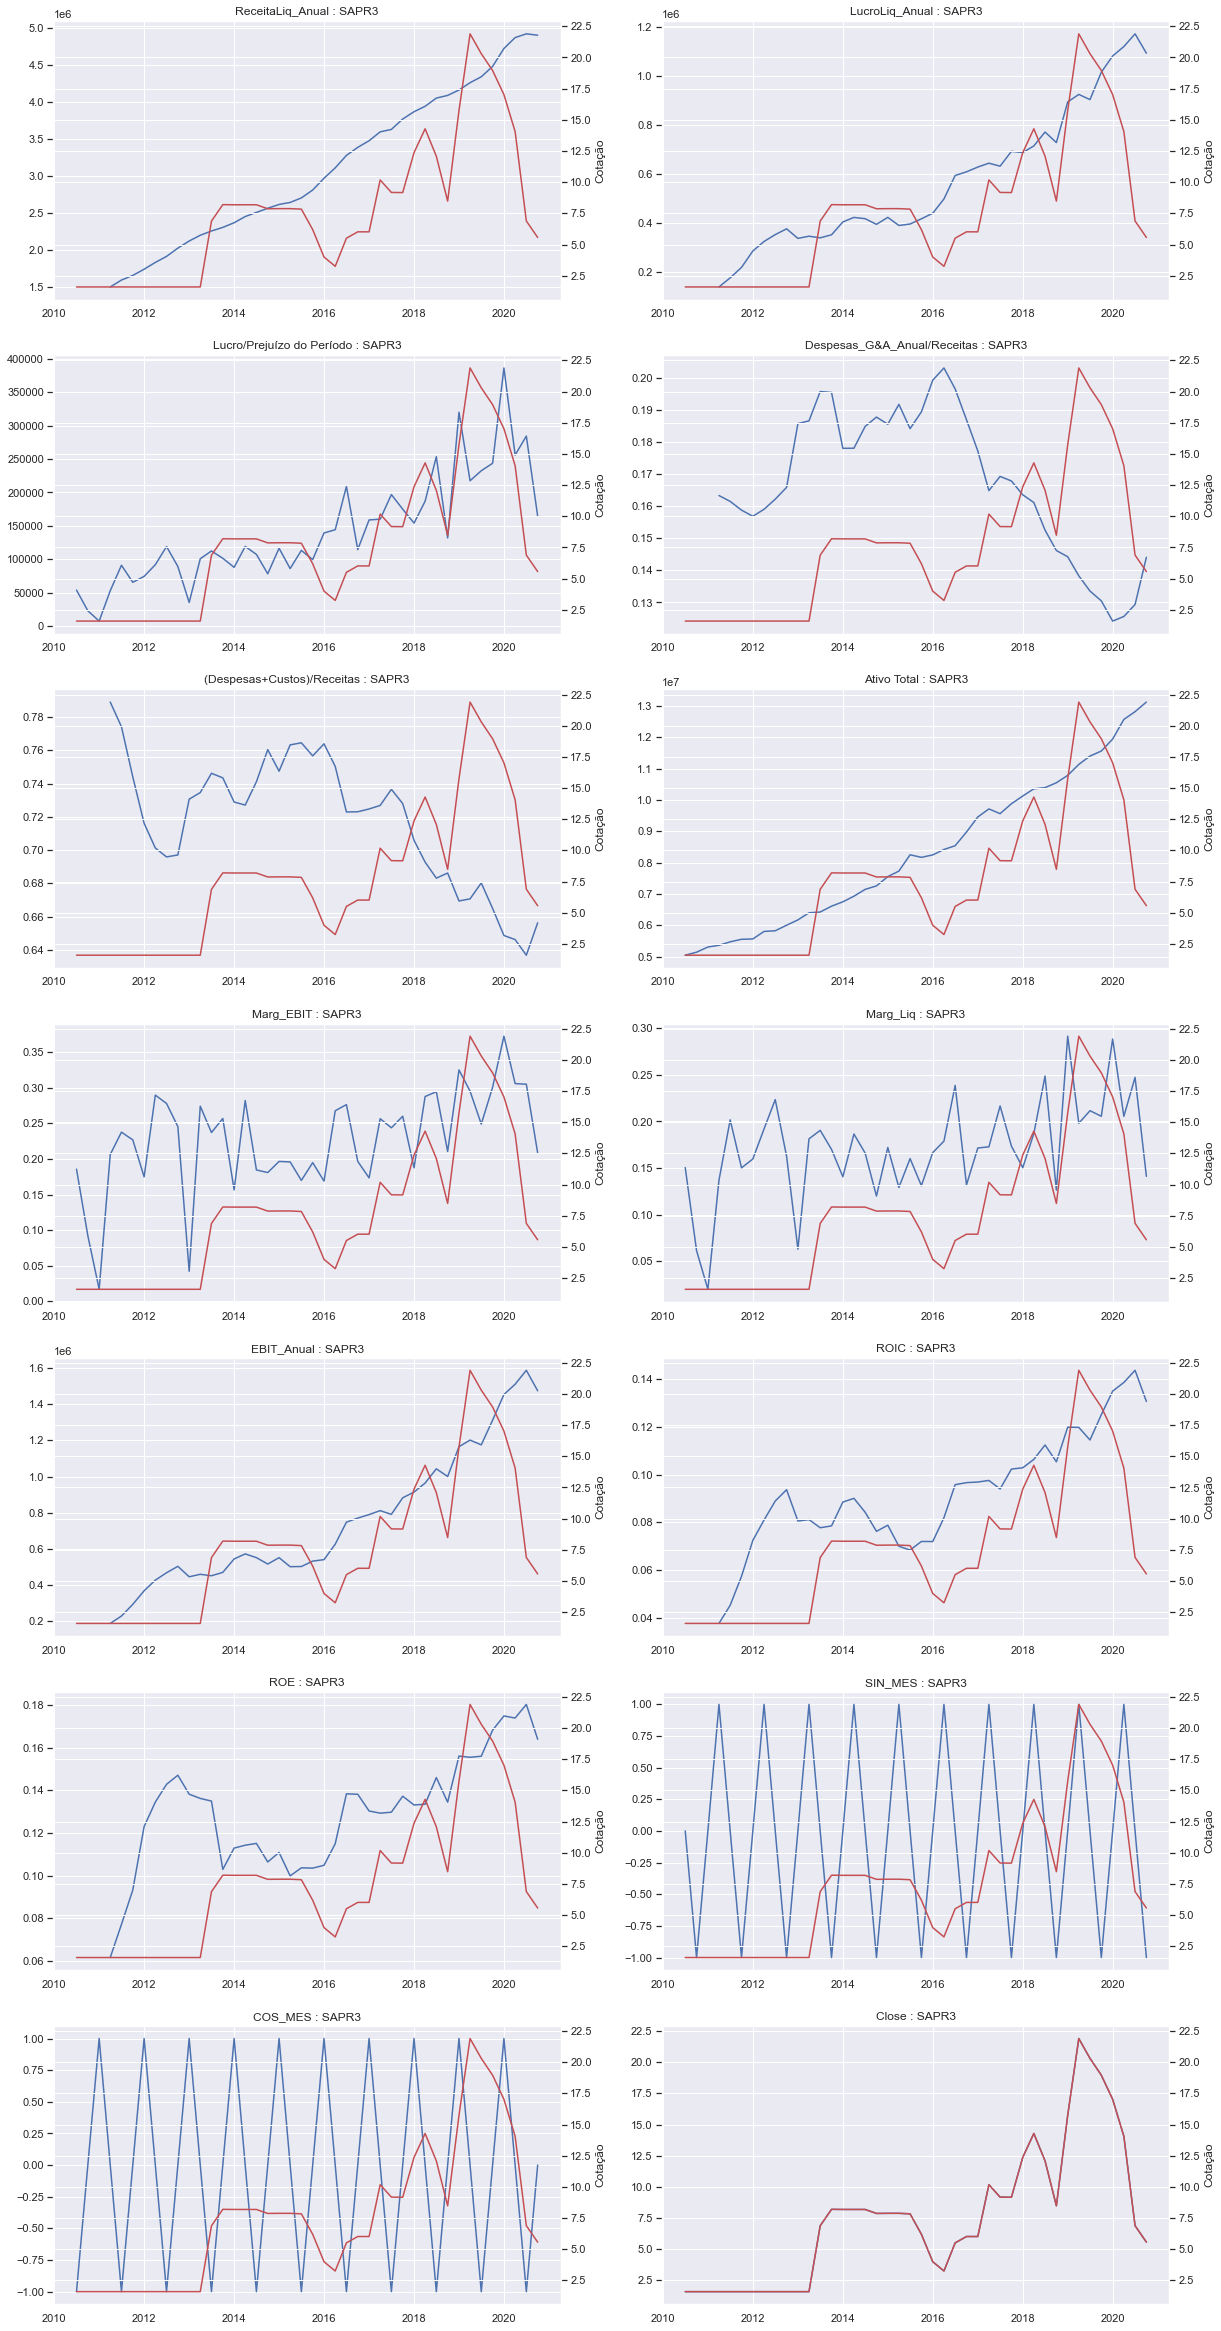

In [12]:
labels = ['ReceitaLiq_Anual', 'LucroLiq_Anual','Lucro/Prejuízo do Período', 'Despesas_G&A_Anual/Receitas',
       '(Despesas+Custos)/Receitas', 'Ativo Total', 'Marg_EBIT', 'Marg_Liq', 'EBIT_Anual', 'ROIC', 'ROE',
          'SIN_MES','COS_MES', 'Close']

cols = 2


if (len(labels)%2==0):
    lines = int(len(labels)/2)
else: 
    lines = int(len(labels)/2+1)

cont = 0
fig, ax = plt.subplots(lines, cols, figsize = [20, 3*len(labels)])


for lin in range(0, lines):
    for col in range(0, cols):
        #print(lin, col, cont)
        ax2 = ax[lin, col].twinx()
        ax2.set_ylabel('Cotação')
        ax[lin, col].plot(df_consolidado[labels[cont]])
        ax[lin, col].set_title(labels[cont]+" : " +empresa)
        ax2.plot(df_consolidado['Close'], color='r', label='Cotação')

        if cont<len(labels)-1:
            cont = cont+1
        
plt.rcParams.update({'font.size': 14})
filename = 'graficos/'+ empresa+'.pdf'
plt.savefig(filename, format='pdf', dpi=1200, bbox_inches='tight')
plt.show()



# Construção do Modelo

In [13]:
#Salva entradas consolidadas do modelo
from openpyxl import load_workbook

book = load_workbook('model_inputs.xlsx')
writer = pd.ExcelWriter('model_inputs.xlsx', engine='openpyxl') 
writer.book = book

## ExcelWriter for some reason uses writer.sheets to access the sheet.
## If you leave it empty it will not know that sheet Main is already there
## and will create a new sheet.

writer.sheets = dict((ws.title, ws) for ws in book.worksheets)

df_consolidado.reset_index().to_excel(writer, empresa)

writer.save()
writer.close()

In [14]:
df_modelo = df_consolidado[['cotacao_futura', 'ReceitaLiq_Anual', 'LucroLiq_Anual','Lucro/Prejuízo do Período', 'Despesas_G&A_Anual/Receitas',
       '(Despesas+Custos)/Receitas', 'Ativo Total', 'Marg_EBIT', 'Marg_Liq', 'EBIT_Anual', 'ROIC', 'ROE']]

In [15]:
#Elimina o ultimo balanço após o shift dos preços
df_modelo.dropna(inplace=True)

C:\Users\Marcos\anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [16]:
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error

cont_inputs_labels = np.array(['ReceitaLiq_Anual', 'LucroLiq_Anual','Lucro/Prejuízo do Período', 'Despesas_G&A_Anual/Receitas',
       '(Despesas+Custos)/Receitas', 'Ativo Total', 'Marg_EBIT', 'Marg_Liq', 'EBIT_Anual', 'ROIC', 'ROE'])

categ_inputs_labels = np.array([])

#inputs_labels = np.concatenate([categ_inputs_labels,cont_inputs_labels])
inputs_labels = cont_inputs_labels

print(inputs_labels)

df_cont_inputs = df_modelo[cont_inputs_labels]
df_categ_inputs = df_modelo[categ_inputs_labels]

df_output = df_modelo['cotacao_futura']

#print(df_cont_inputs.shape)
#print(df_categ_inputs.shape)
#print (df_output.dtypes)
#print(df_cont_inputs.dtypes)
#print(df_categ_inputs.dtypes)
#print (df_output.shape)

['ReceitaLiq_Anual' 'LucroLiq_Anual' 'Lucro/Prejuízo do Período'
 'Despesas_G&A_Anual/Receitas' '(Despesas+Custos)/Receitas' 'Ativo Total'
 'Marg_EBIT' 'Marg_Liq' 'EBIT_Anual' 'ROIC' 'ROE']


In [17]:
from sklearn.preprocessing import StandardScaler, RobustScaler

numpy_categ_inputs = df_categ_inputs.values
numpy_cont_inputs = df_cont_inputs.values
numpy_output = df_output.values
#scaler = StandardScaler()
scaler = RobustScaler()

numpy_cont_inputs_scaled = scaler.fit_transform(numpy_cont_inputs)

#numpy_inputs_scaled_back = scaler.inverse_transform(numpy_cont_inputs_scaled)

numpy_inputs_scaled = np.concatenate([numpy_categ_inputs,numpy_cont_inputs_scaled], axis=1)

numpy_inputs_scaled[1,:]

array([-0.78339581, -0.72832143, -0.27908838, -0.18450573,  0.90666361,
       -0.7253526 , -0.08127587,  0.5507684 , -0.70367612, -1.64999792,
       -1.85305837])

In [18]:
#CÓDIGO LOCAL
#salva o Standard Scaler para utilizar depois em execução
import joblib

save_scaler = scaler # Já feito o Fit
scaler_filename = empresa+"_scaler_model.sav"

joblib.dump(save_scaler , scaler_filename)     # save to disk

#Utilizar essa parte do código para carregar o standard scaler salvo
#loaded_scaler = joblib.load('scaler_Model_Temp_RS_CCM.pkl')  # load from disk

['SAPR3_scaler_model.sav']

In [19]:
#Separa dados para treinamento e teste
x_train, x_test, y_train, y_test = train_test_split(numpy_inputs_scaled, numpy_output, test_size=0.15, random_state=42)
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(32, 11)
(6, 11)
(32,)
(6,)


In [20]:
import optuna
import warnings
warnings.filterwarnings(action='ignore')
import lightgbm as lgb
from sklearn.metrics import r2_score, mean_squared_error

class Objective:

    def __init__(self):
        self.best_model = None
        self._model = None
        
    def __call__(self, trial):
        
        # Cria modelo LGMB 
        lgb_train = lgb.Dataset(x_train, y_train, free_raw_data=True)
        lgb_test = lgb.Dataset(x_test, y_test, free_raw_data=True)

        params = {
                    'boosting_type': 'gbdt',   #'dart'
                    'objective': 'regression',
                    'metric': {'rmse'},
                    'learning_rate': trial.suggest_loguniform("lr", 1e-5, 1e-2),
                    'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
                    'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
                    'num_leaves': trial.suggest_int('num_leaves', 2, 256),
                    'n_estimators':trial.suggest_int('n_estimators', 80, 500),
                    'feature_fraction': trial.suggest_uniform('feature_fraction', 0.8, 1.0),
                    'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.8, 1.0),
                    'bagging_freq': trial.suggest_int('bagging_freq', 1, 7),
                    'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
                    'random_state':42,
                    'extra_trees':trial.suggest_categorical ('extra_trees', [True, False]),
                 }
        #Model Training
        lgbm_model = lgb.train(params, lgb_train, num_boost_round=100000, valid_sets=[lgb_train, lgb_test],early_stopping_rounds=100, verbose_eval = 1000)
        
        #Predictions
        y_pred = lgbm_model.predict(x_test)
        
        #Score
        score = mean_squared_error(y_test, y_pred, squared=False)
        
        self._model = lgbm_model
        
        return score
    
    def callback(self, study, trial):
        if study.best_trial == trial:
            self.best_model = self._model

In [21]:
objective = Objective()

study = optuna.create_study(direction="minimize", storage='sqlite:///opt_saved_trials.db')
study.optimize(objective, n_trials=500, callbacks=[objective.callback])

print("Best trial:")
trial = study.best_trial

print("Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

best_model = objective.best_model

df_trials = study.trials_dataframe(attrs=('number', 'value', 'params', 'state'))

[I 2021-01-06 14:41:10,140] A new study created with name: no-name-321c7fd3-ea35-45ad-9aa5-d76a82f0cc41


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[317]	training's rmse: 5.12006	valid_1's rmse: 6.32111


[I 2021-01-06 14:41:13,772] Trial 0 finished with value: 6.321106472265934 and parameters: {'lr': 0.00017478243262376307, 'lambda_l1': 0.02634717382887318, 'lambda_l2': 0.00048269349949497714, 'num_leaves': 187, 'n_estimators': 317, 'feature_fraction': 0.8129518977936279, 'bagging_fraction': 0.960462452157081, 'bagging_freq': 2, 'min_child_samples': 14, 'extra_trees': False}. Best is trial 0 with value: 6.321106472265934.
[I 2021-01-06 14:41:14,095] Trial 1 finished with value: 6.4506099804157735 and parameters: {'lr': 0.0005037631067893395, 'lambda_l1': 7.082341724735567e-05, 'lambda_l2': 0.001569903273993525, 'num_leaves': 41, 'n_estimators': 377, 'feature_fraction': 0.9205453789630659, 'bagging_fraction': 0.841180348784977, 'bagging_freq': 6, 'min_child_samples': 36, 'extra_trees': False}. Best is trial 0 with value: 6.321106472265934.


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1]	training's rmse: 9.33942	valid_1's rmse: 7.59601
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1]	training's rmse: 9.33942	valid_1's rmse: 7.59601


[I 2021-01-06 14:41:14,461] Trial 2 finished with value: 6.4506099804157735 and parameters: {'lr': 4.2432990929840546e-05, 'lambda_l1': 0.01537291233542999, 'lambda_l2': 0.29461817364242, 'num_leaves': 134, 'n_estimators': 233, 'feature_fraction': 0.8736806619673032, 'bagging_fraction': 0.9690059918433716, 'bagging_freq': 2, 'min_child_samples': 28, 'extra_trees': False}. Best is trial 0 with value: 6.321106472265934.
[I 2021-01-06 14:41:14,809] Trial 3 finished with value: 6.4506099804157735 and parameters: {'lr': 0.00029475810397229665, 'lambda_l1': 3.387376557081909e-05, 'lambda_l2': 2.747048525783935e-05, 'num_leaves': 30, 'n_estimators': 190, 'feature_fraction': 0.8797237716717963, 'bagging_fraction': 0.8489476436639365, 'bagging_freq': 1, 'min_child_samples': 44, 'extra_trees': True}. Best is trial 0 with value: 6.321106472265934.


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1]	training's rmse: 9.33942	valid_1's rmse: 7.59601


[I 2021-01-06 14:41:15,241] Trial 4 finished with value: 6.4506099804157735 and parameters: {'lr': 4.181651888438752e-05, 'lambda_l1': 0.6382325483873984, 'lambda_l2': 4.621909185968602e-08, 'num_leaves': 74, 'n_estimators': 318, 'feature_fraction': 0.8683448124047626, 'bagging_fraction': 0.8565349800050365, 'bagging_freq': 5, 'min_child_samples': 66, 'extra_trees': True}. Best is trial 0 with value: 6.321106472265934.


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1]	training's rmse: 9.33942	valid_1's rmse: 7.59601
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1]	training's rmse: 9.33942	valid_1's rmse: 7.59601


[I 2021-01-06 14:41:15,568] Trial 5 finished with value: 6.4506099804157735 and parameters: {'lr': 0.0003009964790828569, 'lambda_l1': 0.7123428682288802, 'lambda_l2': 1.974604229977935e-08, 'num_leaves': 97, 'n_estimators': 128, 'feature_fraction': 0.9169336413100031, 'bagging_fraction': 0.9580113395823711, 'bagging_freq': 1, 'min_child_samples': 79, 'extra_trees': True}. Best is trial 0 with value: 6.321106472265934.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[306]	training's rmse: 4.63604	valid_1's rmse: 5.6812


[I 2021-01-06 14:41:15,984] Trial 6 finished with value: 5.681199121741365 and parameters: {'lr': 0.0012770284626257677, 'lambda_l1': 1.4718865242299365e-05, 'lambda_l2': 1.1975847745185575e-05, 'num_leaves': 84, 'n_estimators': 306, 'feature_fraction': 0.8055835949252131, 'bagging_fraction': 0.9198518677317258, 'bagging_freq': 4, 'min_child_samples': 13, 'extra_trees': False}. Best is trial 6 with value: 5.681199121741365.
[I 2021-01-06 14:41:16,307] Trial 7 finished with value: 6.4506099804157735 and parameters: {'lr': 0.000185682466270228, 'lambda_l1': 0.014956791969414452, 'lambda_l2': 0.030361385652485466, 'num_leaves': 63, 'n_estimators': 104, 'feature_fraction': 0.9082883665147277, 'bagging_fraction': 0.8006404587299035, 'bagging_freq': 2, 'min_child_samples': 19, 'extra_trees': True}. Best is trial 6 with value: 5.681199121741365.


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1]	training's rmse: 9.33942	valid_1's rmse: 7.59601


[I 2021-01-06 14:41:16,640] Trial 8 finished with value: 6.4506099804157735 and parameters: {'lr': 0.0009572216281106612, 'lambda_l1': 9.560604582812404e-05, 'lambda_l2': 0.016522897920306652, 'num_leaves': 103, 'n_estimators': 369, 'feature_fraction': 0.95783228606754, 'bagging_fraction': 0.9419360443394237, 'bagging_freq': 5, 'min_child_samples': 62, 'extra_trees': True}. Best is trial 6 with value: 5.681199121741365.


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1]	training's rmse: 9.33942	valid_1's rmse: 7.59601


[I 2021-01-06 14:41:17,035] Trial 9 finished with value: 6.4506099804157735 and parameters: {'lr': 0.0010194236387850802, 'lambda_l1': 0.930413006630965, 'lambda_l2': 8.552784879521416e-06, 'num_leaves': 135, 'n_estimators': 278, 'feature_fraction': 0.9607552076310601, 'bagging_fraction': 0.8703837559043164, 'bagging_freq': 6, 'min_child_samples': 75, 'extra_trees': True}. Best is trial 6 with value: 5.681199121741365.


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1]	training's rmse: 9.33942	valid_1's rmse: 7.59601


[I 2021-01-06 14:41:17,374] Trial 10 finished with value: 6.4506099804157735 and parameters: {'lr': 0.008460247885334969, 'lambda_l1': 2.82719630591977e-08, 'lambda_l2': 1.0701122263916672e-06, 'num_leaves': 255, 'n_estimators': 491, 'feature_fraction': 0.8048679611600246, 'bagging_fraction': 0.9133272431020136, 'bagging_freq': 4, 'min_child_samples': 95, 'extra_trees': False}. Best is trial 6 with value: 5.681199121741365.


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1]	training's rmse: 9.33942	valid_1's rmse: 7.59601
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[439]	training's rmse: 2.44552	valid_1's rmse: 4.11705


[I 2021-01-06 14:41:17,899] Trial 11 finished with value: 4.117053933141618 and parameters: {'lr': 0.005649763562625372, 'lambda_l1': 5.483556043010598e-07, 'lambda_l2': 0.0003257627433293514, 'num_leaves': 210, 'n_estimators': 439, 'feature_fraction': 0.8054049790023995, 'bagging_fraction': 0.993395964101828, 'bagging_freq': 3, 'min_child_samples': 5, 'extra_trees': False}. Best is trial 11 with value: 4.117053933141618.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[494]	training's rmse: 3.17881	valid_1's rmse: 3.87596


[I 2021-01-06 14:41:18,436] Trial 12 finished with value: 3.875960256452212 and parameters: {'lr': 0.006887773731893693, 'lambda_l1': 3.8829817505349315e-07, 'lambda_l2': 7.361492507263613, 'num_leaves': 210, 'n_estimators': 494, 'feature_fraction': 0.8277735016252944, 'bagging_fraction': 0.99920412982355, 'bagging_freq': 3, 'min_child_samples': 8, 'extra_trees': False}. Best is trial 12 with value: 3.875960256452212.


Training until validation scores don't improve for 100 rounds


[I 2021-01-06 14:41:18,967] Trial 13 finished with value: 3.6832035690993323 and parameters: {'lr': 0.009409260617811784, 'lambda_l1': 1.0952848127506676e-07, 'lambda_l2': 3.186174814259751, 'num_leaves': 244, 'n_estimators': 500, 'feature_fraction': 0.833575090787667, 'bagging_fraction': 0.997714677494739, 'bagging_freq': 3, 'min_child_samples': 6, 'extra_trees': False}. Best is trial 13 with value: 3.6832035690993323.


Early stopping, best iteration is:
[389]	training's rmse: 2.80265	valid_1's rmse: 3.6832
Training until validation scores don't improve for 100 rounds


[I 2021-01-06 14:41:19,531] Trial 14 finished with value: 4.361814053047381 and parameters: {'lr': 0.0032932332487333117, 'lambda_l1': 2.0581773516844932e-08, 'lambda_l2': 7.130393352558781, 'num_leaves': 251, 'n_estimators': 497, 'feature_fraction': 0.8429984554843039, 'bagging_fraction': 0.9916466940419257, 'bagging_freq': 3, 'min_child_samples': 5, 'extra_trees': False}. Best is trial 13 with value: 3.6832035690993323.


Did not meet early stopping. Best iteration is:
[497]	training's rmse: 3.46543	valid_1's rmse: 4.36181


[I 2021-01-06 14:41:19,874] Trial 15 finished with value: 6.4506099804157735 and parameters: {'lr': 0.002902714494099579, 'lambda_l1': 6.76758193111893e-07, 'lambda_l2': 6.339522596043602, 'num_leaves': 207, 'n_estimators': 450, 'feature_fraction': 0.8292188281239453, 'bagging_fraction': 0.9955949306542078, 'bagging_freq': 3, 'min_child_samples': 28, 'extra_trees': False}. Best is trial 13 with value: 3.6832035690993323.


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1]	training's rmse: 9.33942	valid_1's rmse: 7.59601
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[424]	training's rmse: 5.21103	valid_1's rmse: 6.43059


[I 2021-01-06 14:41:20,414] Trial 16 finished with value: 6.430586587251346 and parameters: {'lr': 1.1683377348903e-05, 'lambda_l1': 5.78959593544709e-07, 'lambda_l2': 0.7603448178635231, 'num_leaves': 178, 'n_estimators': 424, 'feature_fraction': 0.8437474869425737, 'bagging_fraction': 0.9997510739979351, 'bagging_freq': 3, 'min_child_samples': 5, 'extra_trees': False}. Best is trial 13 with value: 3.6832035690993323.
[I 2021-01-06 14:41:20,768] Trial 17 finished with value: 6.4506099804157735 and parameters: {'lr': 0.008090609051111102, 'lambda_l1': 1.0217233054885217e-08, 'lambda_l2': 9.559372527561028, 'num_leaves': 232, 'n_estimators': 494, 'feature_fraction': 0.9939525690567013, 'bagging_fraction': 0.9757223538415069, 'bagging_freq': 5, 'min_child_samples': 49, 'extra_trees': False}. Best is trial 13 with value: 3.6832035690993323.


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1]	training's rmse: 9.33942	valid_1's rmse: 7.59601
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1]	training's rmse: 9.33942	valid_1's rmse: 7.59601


[I 2021-01-06 14:41:21,154] Trial 18 finished with value: 6.4506099804157735 and parameters: {'lr': 0.002648897282253388, 'lambda_l1': 3.666554838331998e-06, 'lambda_l2': 0.5079912197304955, 'num_leaves': 168, 'n_estimators': 394, 'feature_fraction': 0.8485003556563042, 'bagging_fraction': 0.9398676293741652, 'bagging_freq': 4, 'min_child_samples': 24, 'extra_trees': False}. Best is trial 13 with value: 3.6832035690993323.
[I 2021-01-06 14:41:21,472] Trial 19 finished with value: 6.4506099804157735 and parameters: {'lr': 0.009771353631960382, 'lambda_l1': 1.0601396046613999e-07, 'lambda_l2': 0.020769438494303582, 'num_leaves': 230, 'n_estimators': 467, 'feature_fraction': 0.8226788171096143, 'bagging_fraction': 0.8881554355080586, 'bagging_freq': 7, 'min_child_samples': 40, 'extra_trees': False}. Best is trial 13 with value: 3.6832035690993323.


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1]	training's rmse: 9.33942	valid_1's rmse: 7.59601
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1]	training's rmse: 9.33942	valid_1's rmse: 7.59601


[I 2021-01-06 14:41:21,870] Trial 20 finished with value: 6.4506099804157735 and parameters: {'lr': 0.004821661925514285, 'lambda_l1': 0.0011187216071453395, 'lambda_l2': 0.8584931559339245, 'num_leaves': 153, 'n_estimators': 411, 'feature_fraction': 0.8873672162013039, 'bagging_fraction': 0.808110165454894, 'bagging_freq': 2, 'min_child_samples': 99, 'extra_trees': False}. Best is trial 13 with value: 3.6832035690993323.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[453]	training's rmse: 3.6127	valid_1's rmse: 4.92784


[I 2021-01-06 14:41:22,351] Trial 21 finished with value: 4.927835339779683 and parameters: {'lr': 0.005076986722564272, 'lambda_l1': 8.785844825362804e-07, 'lambda_l2': 0.002796171159382426, 'num_leaves': 205, 'n_estimators': 453, 'feature_fraction': 0.8036987589266099, 'bagging_fraction': 0.9829994753024721, 'bagging_freq': 3, 'min_child_samples': 11, 'extra_trees': False}. Best is trial 13 with value: 3.6832035690993323.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[496]	training's rmse: 3.50306	valid_1's rmse: 4.24384


[I 2021-01-06 14:41:22,882] Trial 22 finished with value: 4.243841358883302 and parameters: {'lr': 0.0019085306169482077, 'lambda_l1': 1.1808742440084285e-07, 'lambda_l2': 5.561922120693191e-07, 'num_leaves': 223, 'n_estimators': 496, 'feature_fraction': 0.8334847708176525, 'bagging_fraction': 0.9958463538877269, 'bagging_freq': 3, 'min_child_samples': 7, 'extra_trees': False}. Best is trial 13 with value: 3.6832035690993323.
[I 2021-01-06 14:41:23,221] Trial 23 finished with value: 6.4506099804157735 and parameters: {'lr': 0.009279149257092245, 'lambda_l1': 3.827809612445322e-06, 'lambda_l2': 0.11257772290189394, 'num_leaves': 200, 'n_estimators': 440, 'feature_fraction': 0.8571346612127414, 'bagging_fraction': 0.9466714297564075, 'bagging_freq': 2, 'min_child_samples': 19, 'extra_trees': False}. Best is trial 13 with value: 3.6832035690993323.


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1]	training's rmse: 9.33942	valid_1's rmse: 7.59601
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[347]	training's rmse: 2.93811	valid_1's rmse: 4.12488


[I 2021-01-06 14:41:23,727] Trial 24 finished with value: 4.124883164022582 and parameters: {'lr': 0.005647111338330438, 'lambda_l1': 2.392875115012739e-07, 'lambda_l2': 3.032559938613416, 'num_leaves': 248, 'n_estimators': 347, 'feature_fraction': 0.8236971599454908, 'bagging_fraction': 0.9995393063142569, 'bagging_freq': 4, 'min_child_samples': 5, 'extra_trees': False}. Best is trial 13 with value: 3.6832035690993323.
[I 2021-01-06 14:41:24,057] Trial 25 finished with value: 6.4506099804157735 and parameters: {'lr': 0.009977066925820673, 'lambda_l1': 3.270855396713896e-06, 'lambda_l2': 7.07064719406226e-05, 'num_leaves': 161, 'n_estimators': 472, 'feature_fraction': 0.8017992334862007, 'bagging_fraction': 0.9750998203045641, 'bagging_freq': 3, 'min_child_samples': 31, 'extra_trees': False}. Best is trial 13 with value: 3.6832035690993323.


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1]	training's rmse: 9.33942	valid_1's rmse: 7.59601


[I 2021-01-06 14:41:24,412] Trial 26 finished with value: 6.4506099804157735 and parameters: {'lr': 0.0016927635002784275, 'lambda_l1': 3.890771362005703e-08, 'lambda_l2': 0.0733334971062206, 'num_leaves': 223, 'n_estimators': 417, 'feature_fraction': 0.8560989377616655, 'bagging_fraction': 0.9264456926709127, 'bagging_freq': 1, 'min_child_samples': 19, 'extra_trees': False}. Best is trial 13 with value: 3.6832035690993323.


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1]	training's rmse: 9.33942	valid_1's rmse: 7.59601
Training until validation scores don't improve for 100 rounds


[I 2021-01-06 14:41:24,975] Trial 27 finished with value: 4.089595044535029 and parameters: {'lr': 0.004499550725749075, 'lambda_l1': 0.000989876449004232, 'lambda_l2': 0.0035612364561316574, 'num_leaves': 191, 'n_estimators': 495, 'feature_fraction': 0.8178575731716946, 'bagging_fraction': 0.9826187962934105, 'bagging_freq': 3, 'min_child_samples': 5, 'extra_trees': False}. Best is trial 13 with value: 3.6832035690993323.


Early stopping, best iteration is:
[384]	training's rmse: 2.67858	valid_1's rmse: 4.08959
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[481]	training's rmse: 3.99721	valid_1's rmse: 4.58776


[I 2021-01-06 14:41:25,497] Trial 28 finished with value: 4.587758819521852 and parameters: {'lr': 0.0034131469215059433, 'lambda_l1': 0.00178349583944039, 'lambda_l2': 0.003767069214471736, 'num_leaves': 242, 'n_estimators': 481, 'feature_fraction': 0.8227869027348208, 'bagging_fraction': 0.9576328691658251, 'bagging_freq': 2, 'min_child_samples': 13, 'extra_trees': False}. Best is trial 13 with value: 3.6832035690993323.
[I 2021-01-06 14:41:25,869] Trial 29 finished with value: 6.4506099804157735 and parameters: {'lr': 0.0006449018707676568, 'lambda_l1': 0.09534277091739389, 'lambda_l2': 1.5976638120387538, 'num_leaves': 192, 'n_estimators': 347, 'feature_fraction': 0.815803677658954, 'bagging_fraction': 0.9826197978024058, 'bagging_freq': 4, 'min_child_samples': 19, 'extra_trees': False}. Best is trial 13 with value: 3.6832035690993323.


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1]	training's rmse: 9.33942	valid_1's rmse: 7.59601
Training until validation scores don't improve for 100 rounds


[I 2021-01-06 14:41:26,445] Trial 30 finished with value: 6.365324929075985 and parameters: {'lr': 5.213368024738638e-05, 'lambda_l1': 0.0018288858481225782, 'lambda_l2': 0.1109755023054878, 'num_leaves': 183, 'n_estimators': 499, 'feature_fraction': 0.8931750783253182, 'bagging_fraction': 0.9662632456320257, 'bagging_freq': 3, 'min_child_samples': 9, 'extra_trees': False}. Best is trial 13 with value: 3.6832035690993323.


Did not meet early stopping. Best iteration is:
[499]	training's rmse: 5.15468	valid_1's rmse: 6.36532
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[442]	training's rmse: 2.51688	valid_1's rmse: 4.09288


[I 2021-01-06 14:41:27,072] Trial 31 finished with value: 4.092883666642171 and parameters: {'lr': 0.004933308860926353, 'lambda_l1': 0.00039073456736401704, 'lambda_l2': 0.0004001908438618095, 'num_leaves': 213, 'n_estimators': 442, 'feature_fraction': 0.8349917194945639, 'bagging_fraction': 0.9998756363954605, 'bagging_freq': 3, 'min_child_samples': 5, 'extra_trees': False}. Best is trial 13 with value: 3.6832035690993323.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[466]	training's rmse: 3.90152	valid_1's rmse: 4.37902


[I 2021-01-06 14:41:27,566] Trial 32 finished with value: 4.3790211200560405 and parameters: {'lr': 0.0062370452466559215, 'lambda_l1': 0.0004806025707564525, 'lambda_l2': 0.001013188521674032, 'num_leaves': 217, 'n_estimators': 466, 'feature_fraction': 0.8364956750779489, 'bagging_fraction': 0.9825128781523818, 'bagging_freq': 2, 'min_child_samples': 15, 'extra_trees': False}. Best is trial 13 with value: 3.6832035690993323.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[393]	training's rmse: 3.59816	valid_1's rmse: 4.62507


[I 2021-01-06 14:41:28,065] Trial 33 finished with value: 4.625073984495643 and parameters: {'lr': 0.0016861619453819843, 'lambda_l1': 0.00019220676161519736, 'lambda_l2': 0.00019528436710669842, 'num_leaves': 187, 'n_estimators': 393, 'feature_fraction': 0.854361050152819, 'bagging_fraction': 0.9998340223118961, 'bagging_freq': 3, 'min_child_samples': 5, 'extra_trees': False}. Best is trial 13 with value: 3.6832035690993323.
[I 2021-01-06 14:41:28,423] Trial 34 finished with value: 6.4506099804157735 and parameters: {'lr': 0.004298948817878639, 'lambda_l1': 0.0052819715473601805, 'lambda_l2': 0.006222990930588717, 'num_leaves': 147, 'n_estimators': 467, 'feature_fraction': 0.8144235617932419, 'bagging_fraction': 0.8242137915663955, 'bagging_freq': 4, 'min_child_samples': 34, 'extra_trees': False}. Best is trial 13 with value: 3.6832035690993323.


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1]	training's rmse: 9.33942	valid_1's rmse: 7.59601


[I 2021-01-06 14:41:28,781] Trial 35 finished with value: 6.4506099804157735 and parameters: {'lr': 0.0022652019176500108, 'lambda_l1': 2.8264672333938986e-05, 'lambda_l2': 8.580198831204097e-05, 'num_leaves': 242, 'n_estimators': 251, 'feature_fraction': 0.8629200598725176, 'bagging_fraction': 0.9618843766272792, 'bagging_freq': 2, 'min_child_samples': 25, 'extra_trees': False}. Best is trial 13 with value: 3.6832035690993323.


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1]	training's rmse: 9.33942	valid_1's rmse: 7.59601
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[188]	training's rmse: 3.80078	valid_1's rmse: 4.9311


[I 2021-01-06 14:41:29,177] Trial 36 finished with value: 4.931103586944682 and parameters: {'lr': 0.007107130220232038, 'lambda_l1': 0.00038154853870364414, 'lambda_l2': 0.00045789702061345807, 'num_leaves': 256, 'n_estimators': 188, 'feature_fraction': 0.8714518359165163, 'bagging_fraction': 0.9861053717920639, 'bagging_freq': 1, 'min_child_samples': 11, 'extra_trees': False}. Best is trial 13 with value: 3.6832035690993323.
[I 2021-01-06 14:41:29,521] Trial 37 finished with value: 6.4506099804157735 and parameters: {'lr': 0.0005280718529788609, 'lambda_l1': 5.519705164789807, 'lambda_l2': 0.0014801200197382969, 'num_leaves': 115, 'n_estimators': 431, 'feature_fraction': 0.8376219717527221, 'bagging_fraction': 0.9694845930414283, 'bagging_freq': 3, 'min_child_samples': 23, 'extra_trees': False}. Best is trial 13 with value: 3.6832035690993323.


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1]	training's rmse: 9.33942	valid_1's rmse: 7.59601
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[404]	training's rmse: 3.99131	valid_1's rmse: 4.57383


[I 2021-01-06 14:41:30,030] Trial 38 finished with value: 4.573831662612822 and parameters: {'lr': 0.004158013132302066, 'lambda_l1': 0.043100738256996465, 'lambda_l2': 2.4946715277232215e-06, 'num_leaves': 196, 'n_estimators': 404, 'feature_fraction': 0.8798991791691668, 'bagging_fraction': 0.9481034671005037, 'bagging_freq': 2, 'min_child_samples': 13, 'extra_trees': False}. Best is trial 13 with value: 3.6832035690993323.
[I 2021-01-06 14:41:30,406] Trial 39 finished with value: 6.4506099804157735 and parameters: {'lr': 0.0013054104155870736, 'lambda_l1': 1.1370751014847748e-05, 'lambda_l2': 0.2838124367560341, 'num_leaves': 174, 'n_estimators': 373, 'feature_fraction': 0.8140359103321556, 'bagging_fraction': 0.8984243371601508, 'bagging_freq': 5, 'min_child_samples': 15, 'extra_trees': True}. Best is trial 13 with value: 3.6832035690993323.


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1]	training's rmse: 9.33942	valid_1's rmse: 7.59601


[I 2021-01-06 14:41:30,760] Trial 40 finished with value: 6.4506099804157735 and parameters: {'lr': 0.00010947320578221977, 'lambda_l1': 0.006191852286525826, 'lambda_l2': 1.510939796358307e-07, 'num_leaves': 233, 'n_estimators': 454, 'feature_fraction': 0.9390271409841705, 'bagging_fraction': 0.9746967380291205, 'bagging_freq': 4, 'min_child_samples': 52, 'extra_trees': False}. Best is trial 13 with value: 3.6832035690993323.


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1]	training's rmse: 9.33942	valid_1's rmse: 7.59601
Training until validation scores don't improve for 100 rounds


[I 2021-01-06 14:41:31,268] Trial 41 finished with value: 4.143107379510617 and parameters: {'lr': 0.006410766488866635, 'lambda_l1': 7.10726199233622e-05, 'lambda_l2': 0.00014554414596636215, 'num_leaves': 214, 'n_estimators': 435, 'feature_fraction': 0.8134473253069495, 'bagging_fraction': 0.989663947143796, 'bagging_freq': 3, 'min_child_samples': 5, 'extra_trees': False}. Best is trial 13 with value: 3.6832035690993323.


Did not meet early stopping. Best iteration is:
[435]	training's rmse: 2.38768	valid_1's rmse: 4.14311
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[480]	training's rmse: 2.60497	valid_1's rmse: 4.10871


[I 2021-01-06 14:41:31,924] Trial 42 finished with value: 4.10870738823863 and parameters: {'lr': 0.003981941607907484, 'lambda_l1': 8.813089084525454e-08, 'lambda_l2': 3.3669494370046086e-05, 'num_leaves': 213, 'n_estimators': 480, 'feature_fraction': 0.8238233329095228, 'bagging_fraction': 0.9992839828140895, 'bagging_freq': 3, 'min_child_samples': 5, 'extra_trees': False}. Best is trial 13 with value: 3.6832035690993323.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[498]	training's rmse: 3.62741	valid_1's rmse: 4.91175


[I 2021-01-06 14:41:32,455] Trial 43 finished with value: 4.9117473691341305 and parameters: {'lr': 0.003753018832676847, 'lambda_l1': 8.787545440305956e-08, 'lambda_l2': 9.633194175394789e-06, 'num_leaves': 235, 'n_estimators': 498, 'feature_fraction': 0.8293156645167635, 'bagging_fraction': 0.9997461534652037, 'bagging_freq': 3, 'min_child_samples': 10, 'extra_trees': False}. Best is trial 13 with value: 3.6832035690993323.
[I 2021-01-06 14:41:32,793] Trial 44 finished with value: 6.4506099804157735 and parameters: {'lr': 0.0024556291609581587, 'lambda_l1': 1.4825212855579402e-06, 'lambda_l2': 2.2028561931925514e-05, 'num_leaves': 194, 'n_estimators': 480, 'feature_fraction': 0.8431487101447153, 'bagging_fraction': 0.9852267689028935, 'bagging_freq': 4, 'min_child_samples': 17, 'extra_trees': True}. Best is trial 13 with value: 3.6832035690993323.


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1]	training's rmse: 9.33942	valid_1's rmse: 7.59601
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[252]	training's rmse: 3.12412	valid_1's rmse: 3.93582


[I 2021-01-06 14:41:33,268] Trial 45 finished with value: 3.9358175191284164 and parameters: {'lr': 0.00967923657397399, 'lambda_l1': 1.4294318621772547e-05, 'lambda_l2': 4.187259225540033e-05, 'num_leaves': 218, 'n_estimators': 478, 'feature_fraction': 0.8206048487349678, 'bagging_fraction': 0.9996944656067301, 'bagging_freq': 2, 'min_child_samples': 9, 'extra_trees': False}. Best is trial 13 with value: 3.6832035690993323.
[I 2021-01-06 14:41:33,601] Trial 46 finished with value: 6.4506099804157735 and parameters: {'lr': 0.009389477275238393, 'lambda_l1': 1.592962053210599e-05, 'lambda_l2': 0.009872078159282864, 'num_leaves': 222, 'n_estimators': 499, 'feature_fraction': 0.8329484922773007, 'bagging_fraction': 0.9561696825439451, 'bagging_freq': 2, 'min_child_samples': 63, 'extra_trees': False}. Best is trial 13 with value: 3.6832035690993323.


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1]	training's rmse: 9.33942	valid_1's rmse: 7.59601


[I 2021-01-06 14:41:33,946] Trial 47 finished with value: 6.4506099804157735 and parameters: {'lr': 0.007035516619069539, 'lambda_l1': 0.00011592982102631641, 'lambda_l2': 0.0006836307878477282, 'num_leaves': 205, 'n_estimators': 455, 'feature_fraction': 0.8648383026494327, 'bagging_fraction': 0.970280082740683, 'bagging_freq': 1, 'min_child_samples': 88, 'extra_trees': False}. Best is trial 13 with value: 3.6832035690993323.


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1]	training's rmse: 9.33942	valid_1's rmse: 7.59601
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1]	training's rmse: 9.33942	valid_1's rmse: 7.59601


[I 2021-01-06 14:41:34,287] Trial 48 finished with value: 6.4506099804157735 and parameters: {'lr': 0.0007746926940077829, 'lambda_l1': 4.11288932937192e-05, 'lambda_l2': 5.043852209495903e-05, 'num_leaves': 255, 'n_estimators': 157, 'feature_fraction': 0.8073302196073519, 'bagging_fraction': 0.9298237853096998, 'bagging_freq': 2, 'min_child_samples': 23, 'extra_trees': False}. Best is trial 13 with value: 3.6832035690993323.


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[288]	training's rmse: 3.08251	valid_1's rmse: 3.8774


[I 2021-01-06 14:41:34,781] Trial 49 finished with value: 3.8774009407930485 and parameters: {'lr': 0.009774523036651887, 'lambda_l1': 0.0006513550224676851, 'lambda_l2': 1.7091159803570032e-06, 'num_leaves': 245, 'n_estimators': 484, 'feature_fraction': 0.8472615630960415, 'bagging_fraction': 0.9886743699124987, 'bagging_freq': 1, 'min_child_samples': 9, 'extra_trees': True}. Best is trial 13 with value: 3.6832035690993323.
[I 2021-01-06 14:41:35,129] Trial 50 finished with value: 6.4506099804157735 and parameters: {'lr': 0.009864205126363795, 'lambda_l1': 0.000991689227404488, 'lambda_l2': 2.8956604276760003e-06, 'num_leaves': 9, 'n_estimators': 500, 'feature_fraction': 0.8477692077827302, 'bagging_fraction': 0.9780593211812358, 'bagging_freq': 1, 'min_child_samples': 28, 'extra_trees': True}. Best is trial 13 with value: 3.6832035690993323.


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1]	training's rmse: 9.33942	valid_1's rmse: 7.59601
Training until validation scores don't improve for 100 rounds


[I 2021-01-06 14:41:35,676] Trial 51 finished with value: 3.8735089867470767 and parameters: {'lr': 0.007629060136807112, 'lambda_l1': 0.00023351828048325638, 'lambda_l2': 4.272558035486529e-06, 'num_leaves': 245, 'n_estimators': 482, 'feature_fraction': 0.8191438111673798, 'bagging_fraction': 0.9931190893013887, 'bagging_freq': 1, 'min_child_samples': 8, 'extra_trees': True}. Best is trial 13 with value: 3.6832035690993323.


Did not meet early stopping. Best iteration is:
[482]	training's rmse: 2.94433	valid_1's rmse: 3.87351
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[482]	training's rmse: 2.97396	valid_1's rmse: 3.86224


[I 2021-01-06 14:41:36,200] Trial 52 finished with value: 3.862237400607537 and parameters: {'lr': 0.006904060655050278, 'lambda_l1': 0.007831592561100015, 'lambda_l2': 3.404194167874613e-07, 'num_leaves': 237, 'n_estimators': 482, 'feature_fraction': 0.8191179968235952, 'bagging_fraction': 0.990557399711863, 'bagging_freq': 1, 'min_child_samples': 8, 'extra_trees': True}. Best is trial 13 with value: 3.6832035690993323.


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[233]	training's rmse: 3.68923	valid_1's rmse: 4.8894


[I 2021-01-06 14:41:36,712] Trial 53 finished with value: 4.889399343675748 and parameters: {'lr': 0.007609603153448384, 'lambda_l1': 0.007868588881499543, 'lambda_l2': 1.2825798193361792e-07, 'num_leaves': 246, 'n_estimators': 479, 'feature_fraction': 0.800874366951489, 'bagging_fraction': 0.9906030850310118, 'bagging_freq': 1, 'min_child_samples': 11, 'extra_trees': True}. Best is trial 13 with value: 3.6832035690993323.


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[288]	training's rmse: 3.08282	valid_1's rmse: 3.88093


[I 2021-01-06 14:41:37,182] Trial 54 finished with value: 3.880930978067698 and parameters: {'lr': 0.009766546044380452, 'lambda_l1': 0.0024947168847266584, 'lambda_l2': 4.769643311529096e-07, 'num_leaves': 239, 'n_estimators': 462, 'feature_fraction': 0.8277862960168291, 'bagging_fraction': 0.9922791442113579, 'bagging_freq': 1, 'min_child_samples': 9, 'extra_trees': True}. Best is trial 13 with value: 3.6832035690993323.
[I 2021-01-06 14:41:37,630] Trial 55 finished with value: 6.4506099804157735 and parameters: {'lr': 0.0077097324525836975, 'lambda_l1': 0.1505294952499575, 'lambda_l2': 3.35132344853593e-08, 'num_leaves': 256, 'n_estimators': 458, 'feature_fraction': 0.8283126229556294, 'bagging_fraction': 0.9912538083859309, 'bagging_freq': 1, 'min_child_samples': 16, 'extra_trees': True}. Best is trial 13 with value: 3.6832035690993323.


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1]	training's rmse: 9.33942	valid_1's rmse: 7.59601


[I 2021-01-06 14:41:37,968] Trial 56 finished with value: 6.4506099804157735 and parameters: {'lr': 1.8725007581138707e-05, 'lambda_l1': 0.018106064237941224, 'lambda_l2': 4.572168530043818e-07, 'num_leaves': 237, 'n_estimators': 419, 'feature_fraction': 0.8403993844110167, 'bagging_fraction': 0.8667922260134737, 'bagging_freq': 1, 'min_child_samples': 21, 'extra_trees': True}. Best is trial 13 with value: 3.6832035690993323.


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1]	training's rmse: 9.33942	valid_1's rmse: 7.59601


[I 2021-01-06 14:41:38,301] Trial 57 finished with value: 6.4506099804157735 and parameters: {'lr': 0.0030115561276788188, 'lambda_l1': 0.003337875350714169, 'lambda_l2': 1.0443965198912343e-08, 'num_leaves': 246, 'n_estimators': 443, 'feature_fraction': 0.8471034670548324, 'bagging_fraction': 0.9631967949592846, 'bagging_freq': 1, 'min_child_samples': 42, 'extra_trees': True}. Best is trial 13 with value: 3.6832035690993323.


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1]	training's rmse: 9.33942	valid_1's rmse: 7.59601
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[289]	training's rmse: 3.22557	valid_1's rmse: 3.93659


[I 2021-01-06 14:41:38,732] Trial 58 finished with value: 3.9365875172839098 and parameters: {'lr': 0.005745246306839391, 'lambda_l1': 0.32544843579209387, 'lambda_l2': 1.9511691944225563e-06, 'num_leaves': 56, 'n_estimators': 289, 'feature_fraction': 0.8103533821771016, 'bagging_fraction': 0.9750537184394986, 'bagging_freq': 1, 'min_child_samples': 8, 'extra_trees': True}. Best is trial 13 with value: 3.6832035690993323.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[487]	training's rmse: 3.85655	valid_1's rmse: 4.2723


[I 2021-01-06 14:41:39,278] Trial 59 finished with value: 4.272301845413527 and parameters: {'lr': 0.009694326134625625, 'lambda_l1': 0.03528501695498785, 'lambda_l2': 1.621800579656067e-07, 'num_leaves': 227, 'n_estimators': 487, 'feature_fraction': 0.8526580488433344, 'bagging_fraction': 0.9917439333245684, 'bagging_freq': 1, 'min_child_samples': 13, 'extra_trees': True}. Best is trial 13 with value: 3.6832035690993323.
[I 2021-01-06 14:41:39,611] Trial 60 finished with value: 6.4506099804157735 and parameters: {'lr': 0.005791924441826065, 'lambda_l1': 1.624742916557575e-08, 'lambda_l2': 6.698019101071975e-07, 'num_leaves': 256, 'n_estimators': 96, 'feature_fraction': 0.8273011661923014, 'bagging_fraction': 0.9800784402454796, 'bagging_freq': 6, 'min_child_samples': 17, 'extra_trees': True}. Best is trial 13 with value: 3.6832035690993323.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1]	training's rmse: 9.33942	valid_1's rmse: 7.59601
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[310]	training's rmse: 3.0623	valid_1's rmse: 3.85775


[I 2021-01-06 14:41:40,104] Trial 61 finished with value: 3.8577482536894796 and parameters: {'lr': 0.008148370480779536, 'lambda_l1': 3.247910111961638e-07, 'lambda_l2': 1.5194456432195606e-05, 'num_leaves': 238, 'n_estimators': 468, 'feature_fraction': 0.8185568172535529, 'bagging_fraction': 0.995236555657815, 'bagging_freq': 1, 'min_child_samples': 8, 'extra_trees': True}. Best is trial 13 with value: 3.6832035690993323.


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[330]	training's rmse: 3.06664	valid_1's rmse: 3.85834


[I 2021-01-06 14:41:40,612] Trial 62 finished with value: 3.8583448750447724 and parameters: {'lr': 0.007562647567103798, 'lambda_l1': 2.9319965735875237e-07, 'lambda_l2': 2.737861230285658e-07, 'num_leaves': 239, 'n_estimators': 470, 'feature_fraction': 0.8101891210021079, 'bagging_fraction': 0.9906225647526369, 'bagging_freq': 1, 'min_child_samples': 8, 'extra_trees': True}. Best is trial 13 with value: 3.6832035690993323.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[469]	training's rmse: 2.94783	valid_1's rmse: 3.86949


[I 2021-01-06 14:41:41,126] Trial 63 finished with value: 3.8694856092779424 and parameters: {'lr': 0.007774637288540653, 'lambda_l1': 2.873383269904233e-07, 'lambda_l2': 5.401159931462372e-06, 'num_leaves': 227, 'n_estimators': 469, 'feature_fraction': 0.8004937053000519, 'bagging_fraction': 0.986384554285245, 'bagging_freq': 1, 'min_child_samples': 8, 'extra_trees': True}. Best is trial 13 with value: 3.6832035690993323.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[424]	training's rmse: 4.05861	valid_1's rmse: 4.7127


[I 2021-01-06 14:41:41,595] Trial 64 finished with value: 4.712697897609678 and parameters: {'lr': 0.0032322828204472687, 'lambda_l1': 3.036720576308883e-07, 'lambda_l2': 4.914181196162942e-06, 'num_leaves': 228, 'n_estimators': 424, 'feature_fraction': 0.8073307339626106, 'bagging_fraction': 0.9536200104335587, 'bagging_freq': 1, 'min_child_samples': 13, 'extra_trees': True}. Best is trial 13 with value: 3.6832035690993323.


Training until validation scores don't improve for 100 rounds


[I 2021-01-06 14:41:42,149] Trial 65 finished with value: 3.792080365918425 and parameters: {'lr': 0.007366917757871601, 'lambda_l1': 3.902654247969374e-08, 'lambda_l2': 1.404352955613564e-05, 'num_leaves': 231, 'n_estimators': 468, 'feature_fraction': 0.8027830002940723, 'bagging_fraction': 0.9955691256807702, 'bagging_freq': 2, 'min_child_samples': 7, 'extra_trees': True}. Best is trial 13 with value: 3.6832035690993323.


Did not meet early stopping. Best iteration is:
[468]	training's rmse: 2.83848	valid_1's rmse: 3.79208
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1]	training's rmse: 9.33942	valid_1's rmse: 7.59601


[I 2021-01-06 14:41:42,548] Trial 66 finished with value: 6.4506099804157735 and parameters: {'lr': 0.007982894297527058, 'lambda_l1': 1.580389184924056e-07, 'lambda_l2': 1.549195239049151e-05, 'num_leaves': 231, 'n_estimators': 446, 'feature_fraction': 0.8009934987809504, 'bagging_fraction': 0.9698976845106848, 'bagging_freq': 2, 'min_child_samples': 21, 'extra_trees': True}. Best is trial 13 with value: 3.6832035690993323.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[396]	training's rmse: 2.91044	valid_1's rmse: 3.69786


[I 2021-01-06 14:41:43,208] Trial 67 finished with value: 3.697863662535444 and parameters: {'lr': 0.004902070950812182, 'lambda_l1': 5.0985844106413544e-08, 'lambda_l2': 8.385375427762016e-06, 'num_leaves': 249, 'n_estimators': 396, 'feature_fraction': 0.8006302367325987, 'bagging_fraction': 0.9952995454837235, 'bagging_freq': 1, 'min_child_samples': 6, 'extra_trees': True}. Best is trial 13 with value: 3.6832035690993323.
[I 2021-01-06 14:41:43,523] Trial 68 finished with value: 6.4506099804157735 and parameters: {'lr': 0.0050059273874666224, 'lambda_l1': 4.3616281954757994e-08, 'lambda_l2': 6.089973294315901e-06, 'num_leaves': 250, 'n_estimators': 319, 'feature_fraction': 0.8013349972123642, 'bagging_fraction': 0.9780265718168063, 'bagging_freq': 2, 'min_child_samples': 72, 'extra_trees': True}. Best is trial 13 with value: 3.6832035690993323.


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1]	training's rmse: 9.33942	valid_1's rmse: 7.59601
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[389]	training's rmse: 2.96084	valid_1's rmse: 3.78969


[I 2021-01-06 14:41:44,029] Trial 69 finished with value: 3.789688734606504 and parameters: {'lr': 0.005928368367826565, 'lambda_l1': 5.088252867092015e-08, 'lambda_l2': 1.070274911865348e-06, 'num_leaves': 203, 'n_estimators': 389, 'feature_fraction': 0.8093769902165145, 'bagging_fraction': 0.9853792172032151, 'bagging_freq': 1, 'min_child_samples': 7, 'extra_trees': True}. Best is trial 13 with value: 3.6832035690993323.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[392]	training's rmse: 4.27348	valid_1's rmse: 5.12207


[I 2021-01-06 14:41:44,478] Trial 70 finished with value: 5.122073836979729 and parameters: {'lr': 0.0020917808200803115, 'lambda_l1': 1.3781516089670142e-08, 'lambda_l2': 6.728467815273504e-08, 'num_leaves': 203, 'n_estimators': 392, 'feature_fraction': 0.810355685804511, 'bagging_fraction': 0.9971576628073947, 'bagging_freq': 2, 'min_child_samples': 13, 'extra_trees': True}. Best is trial 13 with value: 3.6832035690993323.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[357]	training's rmse: 2.56514	valid_1's rmse: 4.08473


[I 2021-01-06 14:41:44,962] Trial 71 finished with value: 4.084728390962552 and parameters: {'lr': 0.0056306065176808875, 'lambda_l1': 5.523254534040079e-08, 'lambda_l2': 1.0046994080888606e-06, 'num_leaves': 224, 'n_estimators': 357, 'feature_fraction': 0.8060655672412396, 'bagging_fraction': 0.9818441241367208, 'bagging_freq': 1, 'min_child_samples': 5, 'extra_trees': True}. Best is trial 13 with value: 3.6832035690993323.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[430]	training's rmse: 3.03826	valid_1's rmse: 3.80816


[I 2021-01-06 14:41:45,491] Trial 72 finished with value: 3.808164815335572 and parameters: {'lr': 0.004489988243690562, 'lambda_l1': 1.2370242519990637e-06, 'lambda_l2': 3.231465980734414e-07, 'num_leaves': 236, 'n_estimators': 430, 'feature_fraction': 0.8001931914998601, 'bagging_fraction': 0.9844797650312602, 'bagging_freq': 1, 'min_child_samples': 7, 'extra_trees': True}. Best is trial 13 with value: 3.6832035690993323.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[403]	training's rmse: 3.171	valid_1's rmse: 3.90331


[I 2021-01-06 14:41:45,977] Trial 73 finished with value: 3.903313070957919 and parameters: {'lr': 0.0036816210232633625, 'lambda_l1': 1.2712907920276193e-06, 'lambda_l2': 2.704449907633176e-07, 'num_leaves': 237, 'n_estimators': 403, 'feature_fraction': 0.8173762204926791, 'bagging_fraction': 0.9728836184208278, 'bagging_freq': 1, 'min_child_samples': 7, 'extra_trees': True}. Best is trial 13 with value: 3.6832035690993323.
[I 2021-01-06 14:41:46,298] Trial 74 finished with value: 6.4506099804157735 and parameters: {'lr': 0.002878629969184182, 'lambda_l1': 2.471752064564387e-08, 'lambda_l2': 9.360200486104287e-07, 'num_leaves': 253, 'n_estimators': 379, 'feature_fraction': 0.8110977360717582, 'bagging_fraction': 0.9945671147719168, 'bagging_freq': 1, 'min_child_samples': 17, 'extra_trees': True}. Best is trial 13 with value: 3.6832035690993323.


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1]	training's rmse: 9.33942	valid_1's rmse: 7.59601
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[432]	training's rmse: 5.00663	valid_1's rmse: 6.22899


[I 2021-01-06 14:41:46,792] Trial 75 finished with value: 6.228993125926294 and parameters: {'lr': 0.00022793905665594776, 'lambda_l1': 1.6727966120021208e-07, 'lambda_l2': 6.726291723103945e-08, 'num_leaves': 239, 'n_estimators': 432, 'feature_fraction': 0.9076860847598922, 'bagging_fraction': 0.9641875675993624, 'bagging_freq': 2, 'min_child_samples': 11, 'extra_trees': True}. Best is trial 13 with value: 3.6832035690993323.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[412]	training's rmse: 2.89726	valid_1's rmse: 3.66397


[I 2021-01-06 14:41:47,292] Trial 76 finished with value: 3.66396619617182 and parameters: {'lr': 0.0047983937951487305, 'lambda_l1': 5.622498409349111e-08, 'lambda_l2': 2.6608067836378904e-07, 'num_leaves': 219, 'n_estimators': 412, 'feature_fraction': 0.9922252888611779, 'bagging_fraction': 0.9850660975153477, 'bagging_freq': 1, 'min_child_samples': 6, 'extra_trees': True}. Best is trial 76 with value: 3.66396619617182.


Training until validation scores don't improve for 100 rounds


[I 2021-01-06 14:41:47,866] Trial 77 finished with value: 4.133170800243318 and parameters: {'lr': 0.00501416143077114, 'lambda_l1': 5.049918385116275e-07, 'lambda_l2': 1.6548047052534286e-08, 'num_leaves': 219, 'n_estimators': 410, 'feature_fraction': 0.9922790900148551, 'bagging_fraction': 0.9847660155944119, 'bagging_freq': 2, 'min_child_samples': 5, 'extra_trees': True}. Best is trial 76 with value: 3.66396619617182.


Did not meet early stopping. Best iteration is:
[410]	training's rmse: 2.54089	valid_1's rmse: 4.13317
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[380]	training's rmse: 4.47033	valid_1's rmse: 5.44526


[I 2021-01-06 14:41:48,511] Trial 78 finished with value: 5.445257813015472 and parameters: {'lr': 0.0014488855790251768, 'lambda_l1': 5.2809343224792175e-08, 'lambda_l2': 1.3334089918308959e-05, 'num_leaves': 201, 'n_estimators': 380, 'feature_fraction': 0.9811681600765649, 'bagging_fraction': 0.9796253085229222, 'bagging_freq': 1, 'min_child_samples': 15, 'extra_trees': True}. Best is trial 76 with value: 3.66396619617182.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[352]	training's rmse: 3.75794	valid_1's rmse: 4.74294


[I 2021-01-06 14:41:48,962] Trial 79 finished with value: 4.742940446920051 and parameters: {'lr': 0.004428704731608741, 'lambda_l1': 2.1196836025563294e-06, 'lambda_l2': 9.692697756814419e-08, 'num_leaves': 211, 'n_estimators': 352, 'feature_fraction': 0.9207895955776143, 'bagging_fraction': 0.9995781159904492, 'bagging_freq': 2, 'min_child_samples': 12, 'extra_trees': True}. Best is trial 76 with value: 3.66396619617182.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[330]	training's rmse: 2.89939	valid_1's rmse: 3.67963


[I 2021-01-06 14:41:49,410] Trial 80 finished with value: 3.679628050900953 and parameters: {'lr': 0.0060073366791787725, 'lambda_l1': 3.092048500998248e-08, 'lambda_l2': 2.1827166724060844e-07, 'num_leaves': 231, 'n_estimators': 330, 'feature_fraction': 0.9669808731610005, 'bagging_fraction': 0.9672971628283639, 'bagging_freq': 1, 'min_child_samples': 6, 'extra_trees': True}. Best is trial 76 with value: 3.66396619617182.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[325]	training's rmse: 2.88792	valid_1's rmse: 3.6623


[I 2021-01-06 14:41:49,893] Trial 81 finished with value: 3.662295363871239 and parameters: {'lr': 0.006206800934992764, 'lambda_l1': 9.052328491609809e-08, 'lambda_l2': 2.051069032222936e-07, 'num_leaves': 231, 'n_estimators': 325, 'feature_fraction': 0.9642504149122273, 'bagging_fraction': 0.9856604086759756, 'bagging_freq': 1, 'min_child_samples': 6, 'extra_trees': True}. Best is trial 81 with value: 3.662295363871239.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[306]	training's rmse: 3.4162	valid_1's rmse: 4.46678


[I 2021-01-06 14:41:50,365] Trial 82 finished with value: 4.466779143727633 and parameters: {'lr': 0.0025833394582253756, 'lambda_l1': 2.9656347518866737e-08, 'lambda_l2': 3.1587576265904376e-08, 'num_leaves': 231, 'n_estimators': 306, 'feature_fraction': 0.9705475861798931, 'bagging_fraction': 0.9678997814173605, 'bagging_freq': 1, 'min_child_samples': 5, 'extra_trees': True}. Best is trial 81 with value: 3.662295363871239.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[329]	training's rmse: 3.10227	valid_1's rmse: 3.84197


[I 2021-01-06 14:41:50,843] Trial 83 finished with value: 3.841966664913279 and parameters: {'lr': 0.004167056533623849, 'lambda_l1': 1.0724419375634386e-08, 'lambda_l2': 1.033127420557342e-06, 'num_leaves': 220, 'n_estimators': 329, 'feature_fraction': 0.9498887853778162, 'bagging_fraction': 0.9860038613255122, 'bagging_freq': 1, 'min_child_samples': 6, 'extra_trees': True}. Best is trial 81 with value: 3.662295363871239.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[336]	training's rmse: 3.83691	valid_1's rmse: 4.98701


[I 2021-01-06 14:41:51,293] Trial 84 finished with value: 4.987010499990368 and parameters: {'lr': 0.0036736753207479212, 'lambda_l1': 1.068509936198745e-08, 'lambda_l2': 1.5729598255143365e-06, 'num_leaves': 218, 'n_estimators': 336, 'feature_fraction': 0.9527559919526469, 'bagging_fraction': 0.974445792580028, 'bagging_freq': 1, 'min_child_samples': 11, 'extra_trees': True}. Best is trial 81 with value: 3.662295363871239.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[265]	training's rmse: 3.01644	valid_1's rmse: 3.77229


[I 2021-01-06 14:41:51,711] Trial 85 finished with value: 3.7722947522232326 and parameters: {'lr': 0.006029901840219405, 'lambda_l1': 6.563643776362143e-08, 'lambda_l2': 1.8699098837701637e-07, 'num_leaves': 222, 'n_estimators': 265, 'feature_fraction': 0.9474852509374401, 'bagging_fraction': 0.9517040359954154, 'bagging_freq': 2, 'min_child_samples': 6, 'extra_trees': True}. Best is trial 81 with value: 3.662295363871239.


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1]	training's rmse: 9.33942	valid_1's rmse: 7.59601


[I 2021-01-06 14:41:52,086] Trial 86 finished with value: 6.4506099804157735 and parameters: {'lr': 0.0056345174342919534, 'lambda_l1': 8.158193353103519e-08, 'lambda_l2': 2.0601866332010331e-07, 'num_leaves': 208, 'n_estimators': 261, 'feature_fraction': 0.964031988833459, 'bagging_fraction': 0.9354274005250999, 'bagging_freq': 2, 'min_child_samples': 15, 'extra_trees': True}. Best is trial 81 with value: 3.662295363871239.
[I 2021-01-06 14:41:52,437] Trial 87 finished with value: 6.4506099804157735 and parameters: {'lr': 0.004574134440036245, 'lambda_l1': 2.0386924310490718e-08, 'lambda_l2': 8.387783782516349e-08, 'num_leaves': 185, 'n_estimators': 270, 'feature_fraction': 0.9814009857136959, 'bagging_fraction': 0.917843347277285, 'bagging_freq': 2, 'min_child_samples': 20, 'extra_trees': True}. Best is trial 81 with value: 3.662295363871239.


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1]	training's rmse: 9.33942	valid_1's rmse: 7.59601
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[233]	training's rmse: 3.76575	valid_1's rmse: 4.88353


[I 2021-01-06 14:41:52,841] Trial 88 finished with value: 4.8835309175184545 and parameters: {'lr': 0.0063132677140902245, 'lambda_l1': 1.4134419626434257e-07, 'lambda_l2': 6.176196768234925e-07, 'num_leaves': 198, 'n_estimators': 233, 'feature_fraction': 0.999337576426102, 'bagging_fraction': 0.9633490084144436, 'bagging_freq': 2, 'min_child_samples': 11, 'extra_trees': True}. Best is trial 81 with value: 3.662295363871239.
[I 2021-01-06 14:41:53,180] Trial 89 finished with value: 6.4506099804157735 and parameters: {'lr': 0.0033120218270679827, 'lambda_l1': 6.222642402597074e-08, 'lambda_l2': 4.357585545260471e-08, 'num_leaves': 228, 'n_estimators': 365, 'feature_fraction': 0.9395958600061027, 'bagging_fraction': 0.9561843164846987, 'bagging_freq': 1, 'min_child_samples': 47, 'extra_trees': True}. Best is trial 81 with value: 3.662295363871239.


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1]	training's rmse: 9.33942	valid_1's rmse: 7.59601
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[304]	training's rmse: 2.56871	valid_1's rmse: 4.07057


[I 2021-01-06 14:41:53,627] Trial 90 finished with value: 4.070569184893483 and parameters: {'lr': 0.00655119536027077, 'lambda_l1': 3.052430504977149e-08, 'lambda_l2': 2.8966909182640813e-07, 'num_leaves': 251, 'n_estimators': 304, 'feature_fraction': 0.9739236401124349, 'bagging_fraction': 0.9489699062904458, 'bagging_freq': 2, 'min_child_samples': 5, 'extra_trees': True}. Best is trial 81 with value: 3.662295363871239.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[237]	training's rmse: 3.508	valid_1's rmse: 4.24581


[I 2021-01-06 14:41:54,094] Trial 91 finished with value: 4.245813241274083 and parameters: {'lr': 0.003944626865001199, 'lambda_l1': 1.3084920586991318e-08, 'lambda_l2': 1.405517278593247e-06, 'num_leaves': 222, 'n_estimators': 237, 'feature_fraction': 0.9476562017488157, 'bagging_fraction': 0.9837458639184713, 'bagging_freq': 1, 'min_child_samples': 7, 'extra_trees': True}. Best is trial 81 with value: 3.662295363871239.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[318]	training's rmse: 3.0179	valid_1's rmse: 3.76537


[I 2021-01-06 14:41:54,649] Trial 92 finished with value: 3.7653733045524183 and parameters: {'lr': 0.0049117959000440905, 'lambda_l1': 1.9056429247614193e-07, 'lambda_l2': 3.288146462415986e-06, 'num_leaves': 215, 'n_estimators': 318, 'feature_fraction': 0.9307818745378593, 'bagging_fraction': 0.971628943822891, 'bagging_freq': 1, 'min_child_samples': 6, 'extra_trees': True}. Best is trial 81 with value: 3.662295363871239.
[I 2021-01-06 14:41:54,978] Trial 93 finished with value: 6.4506099804157735 and parameters: {'lr': 0.0051677148612189186, 'lambda_l1': 1.851924738427318e-07, 'lambda_l2': 2.8960171066323515e-06, 'num_leaves': 213, 'n_estimators': 291, 'feature_fraction': 0.9292783842670184, 'bagging_fraction': 0.9594727155140993, 'bagging_freq': 1, 'min_child_samples': 58, 'extra_trees': True}. Best is trial 81 with value: 3.662295363871239.


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1]	training's rmse: 9.33942	valid_1's rmse: 7.59601
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[343]	training's rmse: 3.56361	valid_1's rmse: 4.90817


[I 2021-01-06 14:41:55,427] Trial 94 finished with value: 4.908175228618487 and parameters: {'lr': 0.006417885933951835, 'lambda_l1': 8.060724323967561e-07, 'lambda_l2': 3.9794472500138724e-07, 'num_leaves': 233, 'n_estimators': 343, 'feature_fraction': 0.9631083233483574, 'bagging_fraction': 0.9706202782122831, 'bagging_freq': 1, 'min_child_samples': 10, 'extra_trees': True}. Best is trial 81 with value: 3.662295363871239.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[315]	training's rmse: 2.74371	valid_1's rmse: 3.66126


[I 2021-01-06 14:41:55,903] Trial 95 finished with value: 3.6612573973088924 and parameters: {'lr': 0.008787170401403272, 'lambda_l1': 9.673857269137896e-08, 'lambda_l2': 6.886579285426055e-07, 'num_leaves': 243, 'n_estimators': 315, 'feature_fraction': 0.9391071925962798, 'bagging_fraction': 0.9778345973932268, 'bagging_freq': 1, 'min_child_samples': 6, 'extra_trees': True}. Best is trial 95 with value: 3.6612573973088924.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[287]	training's rmse: 3.90815	valid_1's rmse: 4.38358


[I 2021-01-06 14:41:56,326] Trial 96 finished with value: 4.38357572721352 and parameters: {'lr': 0.00889330166858125, 'lambda_l1': 8.209439053122048e-08, 'lambda_l2': 8.959257992319369e-06, 'num_leaves': 243, 'n_estimators': 287, 'feature_fraction': 0.941216488230779, 'bagging_fraction': 0.9783001732325532, 'bagging_freq': 1, 'min_child_samples': 14, 'extra_trees': True}. Best is trial 95 with value: 3.6612573973088924.
[I 2021-01-06 14:41:56,659] Trial 97 finished with value: 6.4506099804157735 and parameters: {'lr': 0.00859669340025691, 'lambda_l1': 3.5381136666259104e-08, 'lambda_l2': 7.156758795922536e-07, 'num_leaves': 209, 'n_estimators': 317, 'feature_fraction': 0.9552495845253205, 'bagging_fraction': 0.95262770180919, 'bagging_freq': 7, 'min_child_samples': 18, 'extra_trees': True}. Best is trial 95 with value: 3.6612573973088924.


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1]	training's rmse: 9.33942	valid_1's rmse: 7.59601
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[326]	training's rmse: 3.65449	valid_1's rmse: 4.89934


[I 2021-01-06 14:41:57,110] Trial 98 finished with value: 4.899339110001094 and parameters: {'lr': 0.005456178773114743, 'lambda_l1': 4.964628522560732e-07, 'lambda_l2': 2.1889693358452164e-06, 'num_leaves': 132, 'n_estimators': 326, 'feature_fraction': 0.9681554202543492, 'bagging_fraction': 0.9674481954697524, 'bagging_freq': 1, 'min_child_samples': 10, 'extra_trees': True}. Best is trial 95 with value: 3.6612573973088924.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[301]	training's rmse: 4.84897	valid_1's rmse: 5.9763


[I 2021-01-06 14:41:57,559] Trial 99 finished with value: 5.976298746033237 and parameters: {'lr': 0.00038147269633144893, 'lambda_l1': 9.86518476041127e-08, 'lambda_l2': 1.4442859313372515e-07, 'num_leaves': 178, 'n_estimators': 301, 'feature_fraction': 0.9309072508818865, 'bagging_fraction': 0.9739838362608868, 'bagging_freq': 2, 'min_child_samples': 5, 'extra_trees': True}. Best is trial 95 with value: 3.6612573973088924.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[218]	training's rmse: 4.26661	valid_1's rmse: 5.40069


[I 2021-01-06 14:41:57,958] Trial 100 finished with value: 5.400692867736784 and parameters: {'lr': 0.0027991490945295013, 'lambda_l1': 1.8681289716231128e-08, 'lambda_l2': 3.580391447815458e-06, 'num_leaves': 249, 'n_estimators': 218, 'feature_fraction': 0.9468896819739647, 'bagging_fraction': 0.9953832454036455, 'bagging_freq': 1, 'min_child_samples': 12, 'extra_trees': True}. Best is trial 95 with value: 3.6612573973088924.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[385]	training's rmse: 3.08765	valid_1's rmse: 3.85971


[I 2021-01-06 14:41:58,439] Trial 101 finished with value: 3.859710456494809 and parameters: {'lr': 0.0044080383037156615, 'lambda_l1': 5.663699290530916e-08, 'lambda_l2': 1.9331029887846684e-07, 'num_leaves': 225, 'n_estimators': 385, 'feature_fraction': 0.9584353694684299, 'bagging_fraction': 0.9869039347093012, 'bagging_freq': 1, 'min_child_samples': 7, 'extra_trees': True}. Best is trial 95 with value: 3.6612573973088924.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[367]	training's rmse: 2.96494	valid_1's rmse: 3.79584


[I 2021-01-06 14:41:58,972] Trial 102 finished with value: 3.7958406937150055 and parameters: {'lr': 0.006259727719110617, 'lambda_l1': 1.1532403770669827e-07, 'lambda_l2': 1.2693175983921089e-06, 'num_leaves': 120, 'n_estimators': 367, 'feature_fraction': 0.9314444253128048, 'bagging_fraction': 0.9789967328626656, 'bagging_freq': 1, 'min_child_samples': 7, 'extra_trees': True}. Best is trial 95 with value: 3.6612573973088924.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[370]	training's rmse: 2.80542	valid_1's rmse: 3.66254


[I 2021-01-06 14:41:59,569] Trial 103 finished with value: 3.6625397713382557 and parameters: {'lr': 0.006687853347557268, 'lambda_l1': 2.059364310965541e-07, 'lambda_l2': 6.824987905106353e-06, 'num_leaves': 153, 'n_estimators': 370, 'feature_fraction': 0.9288752636527449, 'bagging_fraction': 0.9774907921188165, 'bagging_freq': 1, 'min_child_samples': 6, 'extra_trees': True}. Best is trial 95 with value: 3.6612573973088924.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[339]	training's rmse: 3.59942	valid_1's rmse: 4.88648


[I 2021-01-06 14:42:00,058] Trial 104 finished with value: 4.886483501262609 and parameters: {'lr': 0.0069442835812575186, 'lambda_l1': 1.9818086192435664e-07, 'lambda_l2': 2.6687341345195423e-05, 'num_leaves': 153, 'n_estimators': 339, 'feature_fraction': 0.9240869096243829, 'bagging_fraction': 0.8970044347150588, 'bagging_freq': 1, 'min_child_samples': 10, 'extra_trees': True}. Best is trial 95 with value: 3.6612573973088924.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[357]	training's rmse: 3.88652	valid_1's rmse: 4.35308


[I 2021-01-06 14:42:00,476] Trial 105 finished with value: 4.353076411111739 and parameters: {'lr': 0.008528573423989497, 'lambda_l1': 3.893969904256794e-08, 'lambda_l2': 0.00011811981844194673, 'num_leaves': 169, 'n_estimators': 357, 'feature_fraction': 0.9853163459172987, 'bagging_fraction': 0.9717042416802327, 'bagging_freq': 1, 'min_child_samples': 14, 'extra_trees': True}. Best is trial 95 with value: 3.6612573973088924.


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[177]	training's rmse: 2.67168	valid_1's rmse: 4.06641


[I 2021-01-06 14:42:00,908] Trial 106 finished with value: 4.066405874735944 and parameters: {'lr': 0.009920572399092656, 'lambda_l1': 6.628972389695098e-08, 'lambda_l2': 5.4888340098914e-07, 'num_leaves': 214, 'n_estimators': 311, 'feature_fraction': 0.9140205078024506, 'bagging_fraction': 0.9607774094669703, 'bagging_freq': 3, 'min_child_samples': 5, 'extra_trees': True}. Best is trial 95 with value: 3.6612573973088924.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[329]	training's rmse: 3.29361	valid_1's rmse: 4.1195


[I 2021-01-06 14:42:01,341] Trial 107 finished with value: 4.119499904518779 and parameters: {'lr': 0.0051778795137016305, 'lambda_l1': 4.150742479852763e-07, 'lambda_l2': 1.0000432972500981e-07, 'num_leaves': 93, 'n_estimators': 329, 'feature_fraction': 0.9381357495283483, 'bagging_fraction': 0.9425749255693333, 'bagging_freq': 1, 'min_child_samples': 9, 'extra_trees': True}. Best is trial 95 with value: 3.6612573973088924.
[I 2021-01-06 14:42:01,684] Trial 108 finished with value: 6.4506099804157735 and parameters: {'lr': 0.0034739101016502878, 'lambda_l1': 1.33675905272557e-07, 'lambda_l2': 6.83478591687667e-06, 'num_leaves': 190, 'n_estimators': 296, 'feature_fraction': 0.944372242729614, 'bagging_fraction': 0.988879282995951, 'bagging_freq': 2, 'min_child_samples': 86, 'extra_trees': True}. Best is trial 95 with value: 3.6612573973088924.


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1]	training's rmse: 9.33942	valid_1's rmse: 7.59601
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[276]	training's rmse: 2.8895	valid_1's rmse: 3.67775


[I 2021-01-06 14:42:02,128] Trial 109 finished with value: 3.677748110565813 and parameters: {'lr': 0.007324878013648256, 'lambda_l1': 2.2123331633514267e-08, 'lambda_l2': 2.0137974582647728e-05, 'num_leaves': 242, 'n_estimators': 276, 'feature_fraction': 0.9334429602397594, 'bagging_fraction': 0.9654675980124675, 'bagging_freq': 1, 'min_child_samples': 6, 'extra_trees': True}. Best is trial 95 with value: 3.6612573973088924.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[256]	training's rmse: 3.80791	valid_1's rmse: 4.65533


[I 2021-01-06 14:42:02,549] Trial 110 finished with value: 4.655327371594969 and parameters: {'lr': 0.006058673910617555, 'lambda_l1': 2.0080770189227236e-08, 'lambda_l2': 8.110650136238342e-07, 'num_leaves': 144, 'n_estimators': 256, 'feature_fraction': 0.9337671603212465, 'bagging_fraction': 0.9663607680440591, 'bagging_freq': 1, 'min_child_samples': 12, 'extra_trees': True}. Best is trial 95 with value: 3.6612573973088924.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[279]	training's rmse: 2.89392	valid_1's rmse: 3.66867


[I 2021-01-06 14:42:03,018] Trial 111 finished with value: 3.6686717492646728 and parameters: {'lr': 0.0071111519744916675, 'lambda_l1': 3.880781663594893e-08, 'lambda_l2': 2.4523852117541776e-05, 'num_leaves': 242, 'n_estimators': 279, 'feature_fraction': 0.9259392067578046, 'bagging_fraction': 0.9759874855960048, 'bagging_freq': 1, 'min_child_samples': 6, 'extra_trees': True}. Best is trial 95 with value: 3.6612573973088924.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[272]	training's rmse: 2.82158	valid_1's rmse: 3.65634


[I 2021-01-06 14:42:03,497] Trial 112 finished with value: 3.6563421783956946 and parameters: {'lr': 0.008663314034120694, 'lambda_l1': 2.1272325117589566e-07, 'lambda_l2': 3.825913185663805e-06, 'num_leaves': 242, 'n_estimators': 272, 'feature_fraction': 0.9239562174480287, 'bagging_fraction': 0.9760634094377654, 'bagging_freq': 1, 'min_child_samples': 6, 'extra_trees': True}. Best is trial 112 with value: 3.6563421783956946.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[279]	training's rmse: 2.44661	valid_1's rmse: 4.09283


[I 2021-01-06 14:42:04,023] Trial 113 finished with value: 4.092834564891734 and parameters: {'lr': 0.008668739859454754, 'lambda_l1': 1.1795037207233332e-07, 'lambda_l2': 8.805892061624235e-06, 'num_leaves': 242, 'n_estimators': 279, 'feature_fraction': 0.9131821090654326, 'bagging_fraction': 0.9762324821113145, 'bagging_freq': 1, 'min_child_samples': 5, 'extra_trees': True}. Best is trial 112 with value: 3.6563421783956946.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[271]	training's rmse: 5.1553	valid_1's rmse: 6.38055


[I 2021-01-06 14:42:04,506] Trial 114 finished with value: 6.380551259026526 and parameters: {'lr': 0.00010870835171224273, 'lambda_l1': 2.2523663719384966e-07, 'lambda_l2': 6.967663961805919e-05, 'num_leaves': 256, 'n_estimators': 271, 'feature_fraction': 0.9241681373462093, 'bagging_fraction': 0.9654881846905329, 'bagging_freq': 1, 'min_child_samples': 10, 'extra_trees': True}. Best is trial 112 with value: 3.6563421783956946.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[245]	training's rmse: 3.28751	valid_1's rmse: 4.13305


[I 2021-01-06 14:42:04,921] Trial 115 finished with value: 4.133049515644422 and parameters: {'lr': 0.007078006805299174, 'lambda_l1': 7.692731042930239e-07, 'lambda_l2': 2.8893399627789417e-05, 'num_leaves': 249, 'n_estimators': 245, 'feature_fraction': 0.9005905098202557, 'bagging_fraction': 0.9515686475484665, 'bagging_freq': 1, 'min_child_samples': 9, 'extra_trees': True}. Best is trial 112 with value: 3.6563421783956946.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[282]	training's rmse: 2.4714	valid_1's rmse: 4.06115


[I 2021-01-06 14:42:05,388] Trial 116 finished with value: 4.061152972576555 and parameters: {'lr': 0.008255785163858997, 'lambda_l1': 2.4370348018152513e-08, 'lambda_l2': 0.00021910242034158515, 'num_leaves': 234, 'n_estimators': 282, 'feature_fraction': 0.9202213608261091, 'bagging_fraction': 0.9590952296295304, 'bagging_freq': 1, 'min_child_samples': 5, 'extra_trees': True}. Best is trial 112 with value: 3.6563421783956946.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[270]	training's rmse: 4.06416	valid_1's rmse: 4.72024


[I 2021-01-06 14:42:05,807] Trial 117 finished with value: 4.720235898269774 and parameters: {'lr': 0.005118812126524365, 'lambda_l1': 2.6502913218632783e-07, 'lambda_l2': 2.078651075141965e-05, 'num_leaves': 242, 'n_estimators': 270, 'feature_fraction': 0.9356683680918086, 'bagging_fraction': 0.9809534691437752, 'bagging_freq': 1, 'min_child_samples': 15, 'extra_trees': True}. Best is trial 112 with value: 3.6563421783956946.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[212]	training's rmse: 3.15909	valid_1's rmse: 3.8876


[I 2021-01-06 14:42:06,245] Trial 118 finished with value: 3.8875952893149206 and parameters: {'lr': 0.0070186730460816355, 'lambda_l1': 8.081247812922659e-08, 'lambda_l2': 3.646738345650541e-06, 'num_leaves': 247, 'n_estimators': 212, 'feature_fraction': 0.927390188466341, 'bagging_fraction': 0.9693466631298838, 'bagging_freq': 1, 'min_child_samples': 7, 'extra_trees': True}. Best is trial 112 with value: 3.6563421783956946.


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[175]	training's rmse: 3.71182	valid_1's rmse: 4.71898


[I 2021-01-06 14:42:06,680] Trial 119 finished with value: 4.718984833592475 and parameters: {'lr': 0.009978055897304052, 'lambda_l1': 3.298734176644335e-08, 'lambda_l2': 5.587486599772895e-05, 'num_leaves': 256, 'n_estimators': 315, 'feature_fraction': 0.9250561990675414, 'bagging_fraction': 0.9740483533908867, 'bagging_freq': 1, 'min_child_samples': 12, 'extra_trees': True}. Best is trial 112 with value: 3.6563421783956946.


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1]	training's rmse: 9.33942	valid_1's rmse: 7.59601


[I 2021-01-06 14:42:07,051] Trial 120 finished with value: 6.4506099804157735 and parameters: {'lr': 0.004765802330924969, 'lambda_l1': 1.8584668845193667e-07, 'lambda_l2': 6.208894089287044e-06, 'num_leaves': 227, 'n_estimators': 299, 'feature_fraction': 0.9177925206132995, 'bagging_fraction': 0.8407903222594775, 'bagging_freq': 1, 'min_child_samples': 36, 'extra_trees': True}. Best is trial 112 with value: 3.6563421783956946.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[260]	training's rmse: 3.02808	valid_1's rmse: 3.76742


[I 2021-01-06 14:42:07,523] Trial 121 finished with value: 3.7674207628861076 and parameters: {'lr': 0.0059242750361091145, 'lambda_l1': 4.297164835170702e-08, 'lambda_l2': 3.249221588542788e-06, 'num_leaves': 222, 'n_estimators': 260, 'feature_fraction': 0.9448376318128303, 'bagging_fraction': 0.981522078078472, 'bagging_freq': 1, 'min_child_samples': 6, 'extra_trees': True}. Best is trial 112 with value: 3.6563421783956946.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[262]	training's rmse: 3.54666	valid_1's rmse: 4.33243


[I 2021-01-06 14:42:07,974] Trial 122 finished with value: 4.332429408401508 and parameters: {'lr': 0.004005822594173943, 'lambda_l1': 1.0141230086825093e-08, 'lambda_l2': 2.1946427830628206e-06, 'num_leaves': 218, 'n_estimators': 262, 'feature_fraction': 0.943859559176202, 'bagging_fraction': 0.9812710908610085, 'bagging_freq': 1, 'min_child_samples': 9, 'extra_trees': True}. Best is trial 112 with value: 3.6563421783956946.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[248]	training's rmse: 2.43964	valid_1's rmse: 4.1191


[I 2021-01-06 14:42:08,420] Trial 123 finished with value: 4.119102837321791 and parameters: {'lr': 0.009944526473358556, 'lambda_l1': 4.622418400244706e-08, 'lambda_l2': 4.6889488148248775e-06, 'num_leaves': 231, 'n_estimators': 248, 'feature_fraction': 0.952275934260699, 'bagging_fraction': 0.9779338918253857, 'bagging_freq': 1, 'min_child_samples': 5, 'extra_trees': True}. Best is trial 112 with value: 3.6563421783956946.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[273]	training's rmse: 3.02109	valid_1's rmse: 3.77787


[I 2021-01-06 14:42:08,849] Trial 124 finished with value: 3.7778750101748138 and parameters: {'lr': 0.005748615164722005, 'lambda_l1': 9.97545732908379e-08, 'lambda_l2': 2.0160357833043006e-05, 'num_leaves': 243, 'n_estimators': 273, 'feature_fraction': 0.9354241370190128, 'bagging_fraction': 0.9625583160855548, 'bagging_freq': 1, 'min_child_samples': 6, 'extra_trees': True}. Best is trial 112 with value: 3.6563421783956946.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[323]	training's rmse: 3.11341	valid_1's rmse: 3.8641


[I 2021-01-06 14:42:09,397] Trial 125 finished with value: 3.864097981581513 and parameters: {'lr': 0.006677453290340081, 'lambda_l1': 1.508430906318662e-08, 'lambda_l2': 1.1407069600870917e-05, 'num_leaves': 224, 'n_estimators': 323, 'feature_fraction': 0.9070572691226483, 'bagging_fraction': 0.9721824073028423, 'bagging_freq': 1, 'min_child_samples': 8, 'extra_trees': True}. Best is trial 112 with value: 3.6563421783956946.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[282]	training's rmse: 2.47813	valid_1's rmse: 4.08671


[I 2021-01-06 14:42:09,817] Trial 126 finished with value: 4.086710932102568 and parameters: {'lr': 0.008092080599331485, 'lambda_l1': 6.882671468449599e-08, 'lambda_l2': 2.8226021857164718e-06, 'num_leaves': 237, 'n_estimators': 282, 'feature_fraction': 0.9428709798208967, 'bagging_fraction': 0.9875400194568156, 'bagging_freq': 1, 'min_child_samples': 5, 'extra_trees': True}. Best is trial 112 with value: 3.6563421783956946.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[222]	training's rmse: 3.85676	valid_1's rmse: 5.03571


[I 2021-01-06 14:42:10,216] Trial 127 finished with value: 5.035710048178813 and parameters: {'lr': 0.0049576363747803245, 'lambda_l1': 3.630747388485749e-07, 'lambda_l2': 2.1965236220133214e-07, 'num_leaves': 253, 'n_estimators': 222, 'feature_fraction': 0.9586807345346086, 'bagging_fraction': 0.9807529998983424, 'bagging_freq': 1, 'min_child_samples': 10, 'extra_trees': True}. Best is trial 112 with value: 3.6563421783956946.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[293]	training's rmse: 3.92945	valid_1's rmse: 4.44286


[I 2021-01-06 14:42:10,707] Trial 128 finished with value: 4.442865136713941 and parameters: {'lr': 0.007646884425217751, 'lambda_l1': 2.8886649049678108e-08, 'lambda_l2': 1.7025563365912767e-06, 'num_leaves': 68, 'n_estimators': 293, 'feature_fraction': 0.9356809272925987, 'bagging_fraction': 0.9679577947127862, 'bagging_freq': 1, 'min_child_samples': 14, 'extra_trees': True}. Best is trial 112 with value: 3.6563421783956946.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[262]	training's rmse: 3.59548	valid_1's rmse: 4.35372


[I 2021-01-06 14:42:11,133] Trial 129 finished with value: 4.35372034900427 and parameters: {'lr': 0.003226780031555355, 'lambda_l1': 1.4233889251887628e-07, 'lambda_l2': 3.618553376838819e-05, 'num_leaves': 234, 'n_estimators': 262, 'feature_fraction': 0.9277162742606693, 'bagging_fraction': 0.9758067668675753, 'bagging_freq': 1, 'min_child_samples': 7, 'extra_trees': True}. Best is trial 112 with value: 3.6563421783956946.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[308]	training's rmse: 3.72876	valid_1's rmse: 4.59289


[I 2021-01-06 14:42:11,582] Trial 130 finished with value: 4.592894437252471 and parameters: {'lr': 0.0061447023005384675, 'lambda_l1': 5.311803399710089e-08, 'lambda_l2': 7.738492871631086e-06, 'num_leaves': 221, 'n_estimators': 308, 'feature_fraction': 0.9738597508080302, 'bagging_fraction': 0.956428449324958, 'bagging_freq': 1, 'min_child_samples': 12, 'extra_trees': True}. Best is trial 112 with value: 3.6563421783956946.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[275]	training's rmse: 3.03491	valid_1's rmse: 3.79106


[I 2021-01-06 14:42:12,044] Trial 131 finished with value: 3.7910603490043995 and parameters: {'lr': 0.005581016324426137, 'lambda_l1': 9.582551162498993e-08, 'lambda_l2': 2.2206844648738935e-05, 'num_leaves': 243, 'n_estimators': 275, 'feature_fraction': 0.9342662790274825, 'bagging_fraction': 0.9642775915693015, 'bagging_freq': 1, 'min_child_samples': 6, 'extra_trees': True}. Best is trial 112 with value: 3.6563421783956946.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[241]	training's rmse: 2.51967	valid_1's rmse: 4.0621


[I 2021-01-06 14:42:12,472] Trial 132 finished with value: 4.0620961727681495 and parameters: {'lr': 0.009025245999888134, 'lambda_l1': 1.022755428872998e-07, 'lambda_l2': 1.5551211109674847e-05, 'num_leaves': 246, 'n_estimators': 241, 'feature_fraction': 0.9489922992114892, 'bagging_fraction': 0.9614236891837558, 'bagging_freq': 1, 'min_child_samples': 5, 'extra_trees': True}. Best is trial 112 with value: 3.6563421783956946.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[252]	training's rmse: 3.56581	valid_1's rmse: 4.43301


[I 2021-01-06 14:42:12,886] Trial 133 finished with value: 4.43301406649036 and parameters: {'lr': 0.00431326278619047, 'lambda_l1': 1.888709680467652e-08, 'lambda_l2': 3.6008209361550655e-07, 'num_leaves': 242, 'n_estimators': 252, 'feature_fraction': 0.9387805170201454, 'bagging_fraction': 0.945171903382076, 'bagging_freq': 1, 'min_child_samples': 9, 'extra_trees': True}. Best is trial 112 with value: 3.6563421783956946.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[399]	training's rmse: 2.97477	valid_1's rmse: 3.80634


[I 2021-01-06 14:42:13,387] Trial 134 finished with value: 3.8063430842974264 and parameters: {'lr': 0.005515463039443389, 'lambda_l1': 2.1894462505621347e-07, 'lambda_l2': 1.088078125755103e-05, 'num_leaves': 251, 'n_estimators': 399, 'feature_fraction': 0.9322793492259779, 'bagging_fraction': 0.9708423734559094, 'bagging_freq': 1, 'min_child_samples': 7, 'extra_trees': True}. Best is trial 112 with value: 3.6563421783956946.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[268]	training's rmse: 3.68419	valid_1's rmse: 4.9022


[I 2021-01-06 14:42:13,797] Trial 135 finished with value: 4.902195734708553 and parameters: {'lr': 0.006721867550292733, 'lambda_l1': 4.827510994622498e-08, 'lambda_l2': 3.748616871696212e-06, 'num_leaves': 228, 'n_estimators': 268, 'feature_fraction': 0.9214752268859202, 'bagging_fraction': 0.9916446731663102, 'bagging_freq': 1, 'min_child_samples': 11, 'extra_trees': True}. Best is trial 112 with value: 3.6563421783956946.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[334]	training's rmse: 2.89537	valid_1's rmse: 4.1884


[I 2021-01-06 14:42:14,270] Trial 136 finished with value: 4.188398245788765 and parameters: {'lr': 0.0039206737647658665, 'lambda_l1': 2.6059701065707076e-08, 'lambda_l2': 9.363716200524121e-05, 'num_leaves': 240, 'n_estimators': 334, 'feature_fraction': 0.9545596507222031, 'bagging_fraction': 0.9832455109746442, 'bagging_freq': 1, 'min_child_samples': 5, 'extra_trees': True}. Best is trial 112 with value: 3.6563421783956946.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[289]	training's rmse: 3.24193	valid_1's rmse: 4.00025


[I 2021-01-06 14:42:14,716] Trial 137 finished with value: 4.000248224495634 and parameters: {'lr': 0.0060198434765886865, 'lambda_l1': 4.966836164093616e-07, 'lambda_l2': 1.34537377825474e-07, 'num_leaves': 233, 'n_estimators': 289, 'feature_fraction': 0.9454436693786369, 'bagging_fraction': 0.9776152844175736, 'bagging_freq': 1, 'min_child_samples': 9, 'extra_trees': True}. Best is trial 112 with value: 3.6563421783956946.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[279]	training's rmse: 3.00133	valid_1's rmse: 3.78889


[I 2021-01-06 14:42:15,205] Trial 138 finished with value: 3.788889501257625 and parameters: {'lr': 0.007490580800182071, 'lambda_l1': 7.088991390044339e-08, 'lambda_l2': 4.431888686500891e-05, 'num_leaves': 224, 'n_estimators': 279, 'feature_fraction': 0.9147239824867862, 'bagging_fraction': 0.9883189163788826, 'bagging_freq': 2, 'min_child_samples': 7, 'extra_trees': True}. Best is trial 112 with value: 3.6563421783956946.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[257]	training's rmse: 2.43032	valid_1's rmse: 4.05882


[I 2021-01-06 14:42:15,625] Trial 139 finished with value: 4.058820369014988 and parameters: {'lr': 0.009936236041040285, 'lambda_l1': 1.1709631031398208e-07, 'lambda_l2': 6.120898628098749e-08, 'num_leaves': 217, 'n_estimators': 257, 'feature_fraction': 0.9402832193892008, 'bagging_fraction': 0.96570193900264, 'bagging_freq': 1, 'min_child_samples': 5, 'extra_trees': True}. Best is trial 112 with value: 3.6563421783956946.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[350]	training's rmse: 3.98439	valid_1's rmse: 4.55043


[I 2021-01-06 14:42:16,074] Trial 140 finished with value: 4.550429833707381 and parameters: {'lr': 0.004996002179588832, 'lambda_l1': 3.960858083201838e-08, 'lambda_l2': 1.647280260785293e-05, 'num_leaves': 41, 'n_estimators': 350, 'feature_fraction': 0.8853617787912644, 'bagging_fraction': 0.9737778937757816, 'bagging_freq': 1, 'min_child_samples': 13, 'extra_trees': True}. Best is trial 112 with value: 3.6563421783956946.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[282]	training's rmse: 2.96875	valid_1's rmse: 3.78793


[I 2021-01-06 14:42:16,516] Trial 141 finished with value: 3.787931877961526 and parameters: {'lr': 0.007976340621454019, 'lambda_l1': 7.267551870332856e-08, 'lambda_l2': 4.1053802028993676e-05, 'num_leaves': 224, 'n_estimators': 282, 'feature_fraction': 0.9156971675189493, 'bagging_fraction': 0.9872928064773453, 'bagging_freq': 2, 'min_child_samples': 7, 'extra_trees': True}. Best is trial 112 with value: 3.6563421783956946.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[286]	training's rmse: 2.93871	valid_1's rmse: 3.7716


[I 2021-01-06 14:42:16,943] Trial 142 finished with value: 3.771598379793381 and parameters: {'lr': 0.008635157245319958, 'lambda_l1': 1.7499086849825475e-07, 'lambda_l2': 3.329585631924596e-05, 'num_leaves': 229, 'n_estimators': 286, 'feature_fraction': 0.9279228779009403, 'bagging_fraction': 0.9964289984681401, 'bagging_freq': 4, 'min_child_samples': 7, 'extra_trees': True}. Best is trial 112 with value: 3.6563421783956946.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[300]	training's rmse: 3.09521	valid_1's rmse: 3.88312


[I 2021-01-06 14:42:17,362] Trial 143 finished with value: 3.883115870948866 and parameters: {'lr': 0.008956915196319195, 'lambda_l1': 1.6642388455972325e-07, 'lambda_l2': 5.390213262161226e-06, 'num_leaves': 238, 'n_estimators': 300, 'feature_fraction': 0.9268957010944011, 'bagging_fraction': 0.9967787964417018, 'bagging_freq': 1, 'min_child_samples': 9, 'extra_trees': True}. Best is trial 112 with value: 3.6563421783956946.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[267]	training's rmse: 2.69222	valid_1's rmse: 3.91591


[I 2021-01-06 14:42:17,799] Trial 144 finished with value: 3.9159064786919617 and parameters: {'lr': 0.006771688889480237, 'lambda_l1': 1.291527152717416e-07, 'lambda_l2': 8.017632814988561e-06, 'num_leaves': 246, 'n_estimators': 267, 'feature_fraction': 0.9368025910389994, 'bagging_fraction': 0.9070127546678524, 'bagging_freq': 4, 'min_child_samples': 5, 'extra_trees': True}. Best is trial 112 with value: 3.6563421783956946.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[323]	training's rmse: 3.66261	valid_1's rmse: 4.90786


[I 2021-01-06 14:42:18,249] Trial 145 finished with value: 4.907855680039411 and parameters: {'lr': 0.005926612071371195, 'lambda_l1': 2.5282066334725755e-07, 'lambda_l2': 4.879168204046262e-07, 'num_leaves': 231, 'n_estimators': 323, 'feature_fraction': 0.9300672790290428, 'bagging_fraction': 0.999435212051593, 'bagging_freq': 1, 'min_child_samples': 11, 'extra_trees': True}. Best is trial 112 with value: 3.6563421783956946.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[289]	training's rmse: 2.88392	valid_1's rmse: 3.75354


[I 2021-01-06 14:42:18,678] Trial 146 finished with value: 3.753535453441744 and parameters: {'lr': 0.009989944925808156, 'lambda_l1': 3.4292393558515597e-07, 'lambda_l2': 3.0241635129844006e-05, 'num_leaves': 208, 'n_estimators': 289, 'feature_fraction': 0.9671236250046438, 'bagging_fraction': 0.993478303258766, 'bagging_freq': 4, 'min_child_samples': 7, 'extra_trees': True}. Best is trial 112 with value: 3.6563421783956946.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[309]	training's rmse: 3.00996	valid_1's rmse: 3.84553


[I 2021-01-06 14:42:19,089] Trial 147 finished with value: 3.8455341015042133 and parameters: {'lr': 0.009837799063953783, 'lambda_l1': 3.3487725449023115e-07, 'lambda_l2': 7.06655181027827e-05, 'num_leaves': 208, 'n_estimators': 309, 'feature_fraction': 0.9757357557607695, 'bagging_fraction': 0.9918198779906491, 'bagging_freq': 4, 'min_child_samples': 8, 'extra_trees': True}. Best is trial 112 with value: 3.6563421783956946.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[294]	training's rmse: 3.529	valid_1's rmse: 4.90373


[I 2021-01-06 14:42:19,554] Trial 148 finished with value: 4.903730122750385 and parameters: {'lr': 0.008598064547322851, 'lambda_l1': 6.873403458001951e-07, 'lambda_l2': 0.00023134156997193183, 'num_leaves': 217, 'n_estimators': 294, 'feature_fraction': 0.9874641396729232, 'bagging_fraction': 0.9942966291201173, 'bagging_freq': 4, 'min_child_samples': 10, 'extra_trees': True}. Best is trial 112 with value: 3.6563421783956946.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[287]	training's rmse: 2.50114	valid_1's rmse: 4.06994


[I 2021-01-06 14:42:20,000] Trial 149 finished with value: 4.069936270784087 and parameters: {'lr': 0.007451575642261826, 'lambda_l1': 3.790980059751553e-08, 'lambda_l2': 2.0035231006985298e-06, 'num_leaves': 215, 'n_estimators': 287, 'feature_fraction': 0.9797625650538251, 'bagging_fraction': 0.9832040087070633, 'bagging_freq': 5, 'min_child_samples': 5, 'extra_trees': True}. Best is trial 112 with value: 3.6563421783956946.
[I 2021-01-06 14:42:20,357] Trial 150 finished with value: 6.4506099804157735 and parameters: {'lr': 0.0045438223307856344, 'lambda_l1': 1.4182673528514159e-08, 'lambda_l2': 2.875082607907332e-05, 'num_leaves': 206, 'n_estimators': 410, 'feature_fraction': 0.9655766176524834, 'bagging_fraction': 0.9800756163730154, 'bagging_freq': 4, 'min_child_samples': 16, 'extra_trees': True}. Best is trial 112 with value: 3.6563421783956946.


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1]	training's rmse: 9.33942	valid_1's rmse: 7.59601
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[231]	training's rmse: 3.16623	valid_1's rmse: 3.86867


[I 2021-01-06 14:42:20,890] Trial 151 finished with value: 3.8686678209326106 and parameters: {'lr': 0.006541290072755261, 'lambda_l1': 9.37348181467864e-08, 'lambda_l2': 2.1746564989506282e-05, 'num_leaves': 230, 'n_estimators': 231, 'feature_fraction': 0.9501141708916159, 'bagging_fraction': 0.969394351795787, 'bagging_freq': 4, 'min_child_samples': 7, 'extra_trees': True}. Best is trial 112 with value: 3.6563421783956946.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[272]	training's rmse: 2.79825	valid_1's rmse: 4.15784


[I 2021-01-06 14:42:21,331] Trial 152 finished with value: 4.1578421063092295 and parameters: {'lr': 0.0053930427540423665, 'lambda_l1': 1.8394393286196565e-07, 'lambda_l2': 1.2606388478154677e-05, 'num_leaves': 250, 'n_estimators': 272, 'feature_fraction': 0.9681514220010472, 'bagging_fraction': 0.9761061527202043, 'bagging_freq': 4, 'min_child_samples': 5, 'extra_trees': True}. Best is trial 112 with value: 3.6563421783956946.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[314]	training's rmse: 3.05108	valid_1's rmse: 3.84349


[I 2021-01-06 14:42:21,837] Trial 153 finished with value: 3.843491121804712 and parameters: {'lr': 0.008515252308824491, 'lambda_l1': 6.284896367638283e-08, 'lambda_l2': 6.214048439478959e-06, 'num_leaves': 237, 'n_estimators': 314, 'feature_fraction': 0.9228800295101531, 'bagging_fraction': 0.9992049101905536, 'bagging_freq': 4, 'min_child_samples': 8, 'extra_trees': True}. Best is trial 112 with value: 3.6563421783956946.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[261]	training's rmse: 3.20544	valid_1's rmse: 4.0089


[I 2021-01-06 14:42:22,298] Trial 154 finished with value: 4.00890306637997 and parameters: {'lr': 0.007233163664730631, 'lambda_l1': 2.5455656219980666e-08, 'lambda_l2': 3.800897260135543, 'num_leaves': 212, 'n_estimators': 261, 'feature_fraction': 0.9317867855977685, 'bagging_fraction': 0.9612389689158092, 'bagging_freq': 5, 'min_child_samples': 6, 'extra_trees': True}. Best is trial 112 with value: 3.6563421783956946.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[304]	training's rmse: 3.64282	valid_1's rmse: 4.91228


[I 2021-01-06 14:42:22,733] Trial 155 finished with value: 4.9122784272359405 and parameters: {'lr': 0.0058027157963320185, 'lambda_l1': 4.050383029254627e-07, 'lambda_l2': 1.840825750867617e-05, 'num_leaves': 227, 'n_estimators': 304, 'feature_fraction': 0.9412051157348031, 'bagging_fraction': 0.9842375091361899, 'bagging_freq': 4, 'min_child_samples': 10, 'extra_trees': True}. Best is trial 112 with value: 3.6563421783956946.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[374]	training's rmse: 3.71406	valid_1's rmse: 4.72051


[I 2021-01-06 14:42:23,190] Trial 156 finished with value: 4.720510256564551 and parameters: {'lr': 0.0046379440542338975, 'lambda_l1': 2.4288829393036916e-07, 'lambda_l2': 1.8467935493606418e-07, 'num_leaves': 108, 'n_estimators': 374, 'feature_fraction': 0.9564828682289487, 'bagging_fraction': 0.9899620401760876, 'bagging_freq': 4, 'min_child_samples': 12, 'extra_trees': True}. Best is trial 112 with value: 3.6563421783956946.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[278]	training's rmse: 3.1627	valid_1's rmse: 4.35504


[I 2021-01-06 14:42:23,644] Trial 157 finished with value: 4.355036792943341 and parameters: {'lr': 0.0035311412584132953, 'lambda_l1': 1.339837892748533e-07, 'lambda_l2': 3.473062666328717e-06, 'num_leaves': 221, 'n_estimators': 278, 'feature_fraction': 0.9970996466266051, 'bagging_fraction': 0.9727944342789916, 'bagging_freq': 3, 'min_child_samples': 5, 'extra_trees': True}. Best is trial 112 with value: 3.6563421783956946.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[361]	training's rmse: 4.35142	valid_1's rmse: 5.27693


[I 2021-01-06 14:42:24,152] Trial 158 finished with value: 5.276929151285538 and parameters: {'lr': 0.0009556052674768551, 'lambda_l1': 8.18103926330177e-08, 'lambda_l2': 1.0568742936600516e-05, 'num_leaves': 243, 'n_estimators': 361, 'feature_fraction': 0.9624533020695983, 'bagging_fraction': 0.9945174861944609, 'bagging_freq': 1, 'min_child_samples': 8, 'extra_trees': True}. Best is trial 112 with value: 3.6563421783956946.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[336]	training's rmse: 2.99318	valid_1's rmse: 3.81334


[I 2021-01-06 14:42:24,617] Trial 159 finished with value: 3.813340030431505 and parameters: {'lr': 0.006554258988233359, 'lambda_l1': 5.516138544967955e-08, 'lambda_l2': 0.00013349699968211517, 'num_leaves': 256, 'n_estimators': 336, 'feature_fraction': 0.9357721769849857, 'bagging_fraction': 0.9551289547818577, 'bagging_freq': 1, 'min_child_samples': 7, 'extra_trees': True}. Best is trial 112 with value: 3.6563421783956946.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[252]	training's rmse: 3.53774	valid_1's rmse: 4.93767


[I 2021-01-06 14:42:25,050] Trial 160 finished with value: 4.93766662947896 and parameters: {'lr': 0.009708897862893383, 'lambda_l1': 9.81579440121467e-07, 'lambda_l2': 1.0361704505437433e-07, 'num_leaves': 234, 'n_estimators': 252, 'feature_fraction': 0.926335331233293, 'bagging_fraction': 0.9778234588152176, 'bagging_freq': 1, 'min_child_samples': 10, 'extra_trees': True}. Best is trial 112 with value: 3.6563421783956946.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[280]	training's rmse: 2.83918	valid_1's rmse: 3.66647


[I 2021-01-06 14:42:25,480] Trial 161 finished with value: 3.666465658187461 and parameters: {'lr': 0.008126485315313663, 'lambda_l1': 7.588813758265863e-08, 'lambda_l2': 4.759635089010509e-05, 'num_leaves': 222, 'n_estimators': 280, 'feature_fraction': 0.9179955870442716, 'bagging_fraction': 0.9864866462777133, 'bagging_freq': 3, 'min_child_samples': 6, 'extra_trees': True}. Best is trial 112 with value: 3.6563421783956946.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[285]	training's rmse: 2.5013	valid_1's rmse: 4.10989


[I 2021-01-06 14:42:25,931] Trial 162 finished with value: 4.109885748102353 and parameters: {'lr': 0.00779092779814238, 'lambda_l1': 3.879740778445479e-08, 'lambda_l2': 4.022816693757379e-05, 'num_leaves': 200, 'n_estimators': 285, 'feature_fraction': 0.9212847547116537, 'bagging_fraction': 0.9861506162216814, 'bagging_freq': 3, 'min_child_samples': 5, 'extra_trees': True}. Best is trial 112 with value: 3.6563421783956946.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[295]	training's rmse: 2.91485	valid_1's rmse: 3.76116


[I 2021-01-06 14:42:26,455] Trial 163 finished with value: 3.7611605089369977 and parameters: {'lr': 0.008942985763597588, 'lambda_l1': 1.6195383729964528e-07, 'lambda_l2': 5.482419006161196e-05, 'num_leaves': 228, 'n_estimators': 295, 'feature_fraction': 0.9110806276715412, 'bagging_fraction': 0.9803365226593996, 'bagging_freq': 4, 'min_child_samples': 7, 'extra_trees': True}. Best is trial 112 with value: 3.6563421783956946.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[295]	training's rmse: 3.099	valid_1's rmse: 3.92815


[I 2021-01-06 14:42:26,916] Trial 164 finished with value: 3.928147423437859 and parameters: {'lr': 0.009129488648310572, 'lambda_l1': 1.7544132962509977e-07, 'lambda_l2': 8.785998436167518e-05, 'num_leaves': 224, 'n_estimators': 295, 'feature_fraction': 0.919236335360146, 'bagging_fraction': 0.9810134211388685, 'bagging_freq': 4, 'min_child_samples': 9, 'extra_trees': True}. Best is trial 112 with value: 3.6563421783956946.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[316]	training's rmse: 2.92363	valid_1's rmse: 3.7723


[I 2021-01-06 14:42:27,379] Trial 165 finished with value: 3.7722976875626504 and parameters: {'lr': 0.008358427602119162, 'lambda_l1': 6.5311904253280115e-06, 'lambda_l2': 5.041548379666889e-05, 'num_leaves': 229, 'n_estimators': 316, 'feature_fraction': 0.9039438753998225, 'bagging_fraction': 0.9893438590956009, 'bagging_freq': 4, 'min_child_samples': 7, 'extra_trees': True}. Best is trial 112 with value: 3.6563421783956946.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[301]	training's rmse: 3.892	valid_1's rmse: 4.36082


[I 2021-01-06 14:42:27,825] Trial 166 finished with value: 4.360821773398669 and parameters: {'lr': 0.009793004732214824, 'lambda_l1': 2.835770951564137e-07, 'lambda_l2': 3.1549160338099316e-05, 'num_leaves': 213, 'n_estimators': 301, 'feature_fraction': 0.9113523447122115, 'bagging_fraction': 0.9843797584431865, 'bagging_freq': 4, 'min_child_samples': 13, 'extra_trees': True}. Best is trial 112 with value: 3.6563421783956946.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[344]	training's rmse: 2.44502	valid_1's rmse: 4.13805


[I 2021-01-06 14:42:28,336] Trial 167 finished with value: 4.13805338219721 and parameters: {'lr': 0.006974193147027303, 'lambda_l1': 2.4900165279827265e-08, 'lambda_l2': 2.6666526746027895e-07, 'num_leaves': 219, 'n_estimators': 344, 'feature_fraction': 0.9089568226134482, 'bagging_fraction': 0.9942018658208863, 'bagging_freq': 4, 'min_child_samples': 5, 'extra_trees': False}. Best is trial 112 with value: 3.6563421783956946.


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[155]	training's rmse: 3.73928	valid_1's rmse: 4.87931


[I 2021-01-06 14:42:28,759] Trial 168 finished with value: 4.879307525035666 and parameters: {'lr': 0.009954494658722715, 'lambda_l1': 5.484758294773115e-07, 'lambda_l2': 6.425661883359076e-07, 'num_leaves': 236, 'n_estimators': 292, 'feature_fraction': 0.8976333424390343, 'bagging_fraction': 0.9770153985357632, 'bagging_freq': 3, 'min_child_samples': 11, 'extra_trees': True}. Best is trial 112 with value: 3.6563421783956946.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[329]	training's rmse: 3.29182	valid_1's rmse: 4.46684


[I 2021-01-06 14:42:29,291] Trial 169 finished with value: 4.466840144732155 and parameters: {'lr': 0.007483691797349906, 'lambda_l1': 5.744558300987309e-08, 'lambda_l2': 0.00014947719510299094, 'num_leaves': 222, 'n_estimators': 329, 'feature_fraction': 0.9290023848039854, 'bagging_fraction': 0.8852253150949257, 'bagging_freq': 4, 'min_child_samples': 9, 'extra_trees': True}. Best is trial 112 with value: 3.6563421783956946.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[311]	training's rmse: 3.14283	valid_1's rmse: 3.85852


[I 2021-01-06 14:42:29,825] Trial 170 finished with value: 3.8585240664762037 and parameters: {'lr': 0.005066295316440005, 'lambda_l1': 1.204136543874464e-07, 'lambda_l2': 0.0006021454406298231, 'num_leaves': 229, 'n_estimators': 311, 'feature_fraction': 0.9246151494214199, 'bagging_fraction': 0.9814870218304087, 'bagging_freq': 4, 'min_child_samples': 7, 'extra_trees': True}. Best is trial 112 with value: 3.6563421783956946.


Training until validation scores don't improve for 100 rounds


[I 2021-01-06 14:42:30,450] Trial 171 finished with value: 3.772002931241433 and parameters: {'lr': 0.00850333265327341, 'lambda_l1': 4.140169962672545e-06, 'lambda_l2': 5.275278481357377e-05, 'num_leaves': 228, 'n_estimators': 320, 'feature_fraction': 0.9008223509067883, 'bagging_fraction': 0.9895587087515386, 'bagging_freq': 4, 'min_child_samples': 7, 'extra_trees': True}. Best is trial 112 with value: 3.6563421783956946.


Did not meet early stopping. Best iteration is:
[320]	training's rmse: 2.91599	valid_1's rmse: 3.772
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[263]	training's rmse: 2.49655	valid_1's rmse: 4.11273


[I 2021-01-06 14:42:30,920] Trial 172 finished with value: 4.112727018142432 and parameters: {'lr': 0.008417400082864986, 'lambda_l1': 4.024811000830636e-08, 'lambda_l2': 6.538603635730561e-05, 'num_leaves': 234, 'n_estimators': 263, 'feature_fraction': 0.910667690982757, 'bagging_fraction': 0.9999746272073716, 'bagging_freq': 4, 'min_child_samples': 5, 'extra_trees': True}. Best is trial 112 with value: 3.6563421783956946.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[320]	training's rmse: 3.1279	valid_1's rmse: 3.87414


[I 2021-01-06 14:42:31,406] Trial 173 finished with value: 3.874136414818876 and parameters: {'lr': 0.0065952919457281725, 'lambda_l1': 2.481966661727833e-06, 'lambda_l2': 2.61389398914142e-05, 'num_leaves': 210, 'n_estimators': 320, 'feature_fraction': 0.9054318233840717, 'bagging_fraction': 0.9886842461555982, 'bagging_freq': 4, 'min_child_samples': 8, 'extra_trees': True}. Best is trial 112 with value: 3.6563421783956946.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[278]	training's rmse: 2.70821	valid_1's rmse: 4.10069


[I 2021-01-06 14:42:31,991] Trial 174 finished with value: 4.10069519849642 and parameters: {'lr': 0.005964609499039899, 'lambda_l1': 1.779722970283974e-07, 'lambda_l2': 0.0003493110064648851, 'num_leaves': 226, 'n_estimators': 278, 'feature_fraction': 0.9183114523605332, 'bagging_fraction': 0.9922564326472532, 'bagging_freq': 4, 'min_child_samples': 5, 'extra_trees': True}. Best is trial 112 with value: 3.6563421783956946.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[304]	training's rmse: 2.96152	valid_1's rmse: 3.78751


[I 2021-01-06 14:42:32,582] Trial 175 finished with value: 3.7875106680284216 and parameters: {'lr': 0.007758737173928211, 'lambda_l1': 7.818705325457384e-08, 'lambda_l2': 0.048576455044814254, 'num_leaves': 240, 'n_estimators': 304, 'feature_fraction': 0.9022240402445967, 'bagging_fraction': 0.9729392541615531, 'bagging_freq': 4, 'min_child_samples': 7, 'extra_trees': True}. Best is trial 112 with value: 3.6563421783956946.


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[160]	training's rmse: 3.74329	valid_1's rmse: 4.88025


[I 2021-01-06 14:42:33,155] Trial 176 finished with value: 4.880253425599619 and parameters: {'lr': 0.009939771345221431, 'lambda_l1': 1.8429972888634475e-08, 'lambda_l2': 0.00010514834139324751, 'num_leaves': 218, 'n_estimators': 288, 'feature_fraction': 0.9282717395173732, 'bagging_fraction': 0.9852767519283412, 'bagging_freq': 5, 'min_child_samples': 11, 'extra_trees': True}. Best is trial 112 with value: 3.6563421783956946.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[330]	training's rmse: 3.03847	valid_1's rmse: 3.85592


[I 2021-01-06 14:42:33,741] Trial 177 finished with value: 3.8559183947150415 and parameters: {'lr': 0.009972635233920182, 'lambda_l1': 1.0821915762951451e-08, 'lambda_l2': 5.168374785512404e-05, 'num_leaves': 249, 'n_estimators': 330, 'feature_fraction': 0.9160427033822263, 'bagging_fraction': 0.9964440022186167, 'bagging_freq': 3, 'min_child_samples': 9, 'extra_trees': True}. Best is trial 112 with value: 3.6563421783956946.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[296]	training's rmse: 2.53226	valid_1's rmse: 4.09446


[I 2021-01-06 14:42:34,292] Trial 178 finished with value: 4.0944639984537385 and parameters: {'lr': 0.007002736603723173, 'lambda_l1': 3.739766588955213e-07, 'lambda_l2': 1.156095143512083e-05, 'num_leaves': 233, 'n_estimators': 296, 'feature_fraction': 0.9316394711380428, 'bagging_fraction': 0.9794643481506421, 'bagging_freq': 4, 'min_child_samples': 5, 'extra_trees': True}. Best is trial 112 with value: 3.6563421783956946.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[322]	training's rmse: 2.91193	valid_1's rmse: 3.79993


[I 2021-01-06 14:42:34,862] Trial 179 finished with value: 3.7999314724895563 and parameters: {'lr': 0.008661777675367698, 'lambda_l1': 1.208825709009196e-07, 'lambda_l2': 4.975250336981001e-06, 'num_leaves': 222, 'n_estimators': 322, 'feature_fraction': 0.8937927945897886, 'bagging_fraction': 0.9681049328591034, 'bagging_freq': 1, 'min_child_samples': 7, 'extra_trees': True}. Best is trial 112 with value: 3.6563421783956946.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[274]	training's rmse: 3.30393	valid_1's rmse: 4.08818


[I 2021-01-06 14:42:35,296] Trial 180 finished with value: 4.088179123250292 and parameters: {'lr': 0.005717215713676861, 'lambda_l1': 2.9420252324246246e-08, 'lambda_l2': 3.535715183417177e-05, 'num_leaves': 239, 'n_estimators': 274, 'feature_fraction': 0.9705382145595224, 'bagging_fraction': 0.9901946549312359, 'bagging_freq': 5, 'min_child_samples': 9, 'extra_trees': True}. Best is trial 112 with value: 3.6563421783956946.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[319]	training's rmse: 2.92109	valid_1's rmse: 3.77249


[I 2021-01-06 14:42:35,744] Trial 181 finished with value: 3.772493516156389 and parameters: {'lr': 0.008361505896042997, 'lambda_l1': 5.5839327979560896e-08, 'lambda_l2': 4.132019314396092e-05, 'num_leaves': 229, 'n_estimators': 319, 'feature_fraction': 0.891413295311977, 'bagging_fraction': 0.9890107705006301, 'bagging_freq': 4, 'min_child_samples': 7, 'extra_trees': True}. Best is trial 112 with value: 3.6563421783956946.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[311]	training's rmse: 2.42682	valid_1's rmse: 4.10093


[I 2021-01-06 14:42:36,195] Trial 182 finished with value: 4.100932848318422 and parameters: {'lr': 0.008041408564944232, 'lambda_l1': 4.340862123447835e-06, 'lambda_l2': 5.7818059870783564e-05, 'num_leaves': 228, 'n_estimators': 311, 'feature_fraction': 0.9049361958596245, 'bagging_fraction': 0.9837086546693866, 'bagging_freq': 4, 'min_child_samples': 5, 'extra_trees': True}. Best is trial 112 with value: 3.6563421783956946.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[306]	training's rmse: 3.0224	valid_1's rmse: 3.78062


[I 2021-01-06 14:42:36,651] Trial 183 finished with value: 3.7806210272269407 and parameters: {'lr': 0.006543601078720989, 'lambda_l1': 6.640008979098225e-06, 'lambda_l2': 1.7969758557492194e-05, 'num_leaves': 140, 'n_estimators': 306, 'feature_fraction': 0.9025107557333321, 'bagging_fraction': 0.9931334476296396, 'bagging_freq': 4, 'min_child_samples': 7, 'extra_trees': True}. Best is trial 112 with value: 3.6563421783956946.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[338]	training's rmse: 2.63269	valid_1's rmse: 4.10207


[I 2021-01-06 14:42:37,124] Trial 184 finished with value: 4.102074569325296 and parameters: {'lr': 0.005345742550007601, 'lambda_l1': 1.022889076615355e-05, 'lambda_l2': 8.071819811167937e-05, 'num_leaves': 246, 'n_estimators': 338, 'feature_fraction': 0.9441805224804353, 'bagging_fraction': 0.9764909568631422, 'bagging_freq': 4, 'min_child_samples': 5, 'extra_trees': True}. Best is trial 112 with value: 3.6563421783956946.


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[186]	training's rmse: 3.71464	valid_1's rmse: 4.85847


[I 2021-01-06 14:42:37,613] Trial 185 finished with value: 4.85847065783591 and parameters: {'lr': 0.00889674431357253, 'lambda_l1': 2.7281447764026908e-05, 'lambda_l2': 2.8925607809410236e-05, 'num_leaves': 214, 'n_estimators': 317, 'feature_fraction': 0.8967736610306151, 'bagging_fraction': 0.999509054904228, 'bagging_freq': 1, 'min_child_samples': 11, 'extra_trees': True}. Best is trial 112 with value: 3.6563421783956946.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[283]	training's rmse: 3.17374	valid_1's rmse: 3.99289


[I 2021-01-06 14:42:38,058] Trial 186 finished with value: 3.992886619819059 and parameters: {'lr': 0.00734456235435472, 'lambda_l1': 2.254530175276792e-07, 'lambda_l2': 8.278406432958306e-06, 'num_leaves': 232, 'n_estimators': 283, 'feature_fraction': 0.9121379792727857, 'bagging_fraction': 0.9856123733337292, 'bagging_freq': 4, 'min_child_samples': 9, 'extra_trees': True}. Best is trial 112 with value: 3.6563421783956946.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[352]	training's rmse: 2.82839	valid_1's rmse: 3.80621


[I 2021-01-06 14:42:38,540] Trial 187 finished with value: 3.806213099967766 and parameters: {'lr': 0.009919353877262586, 'lambda_l1': 1.8560445469167214e-06, 'lambda_l2': 1.2470427480814229e-06, 'num_leaves': 226, 'n_estimators': 352, 'feature_fraction': 0.9229013153372528, 'bagging_fraction': 0.9716446355047431, 'bagging_freq': 1, 'min_child_samples': 7, 'extra_trees': False}. Best is trial 112 with value: 3.6563421783956946.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[296]	training's rmse: 5.20327	valid_1's rmse: 6.42092


[I 2021-01-06 14:42:38,990] Trial 188 finished with value: 6.420920805275031 and parameters: {'lr': 2.2621368143124776e-05, 'lambda_l1': 9.038853258118346e-05, 'lambda_l2': 1.360241693952631e-07, 'num_leaves': 239, 'n_estimators': 296, 'feature_fraction': 0.9333234025364032, 'bagging_fraction': 0.9898960122947407, 'bagging_freq': 4, 'min_child_samples': 5, 'extra_trees': True}. Best is trial 112 with value: 3.6563421783956946.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[267]	training's rmse: 4.14629	valid_1's rmse: 4.88488


[I 2021-01-06 14:42:39,423] Trial 189 finished with value: 4.8848781472187826 and parameters: {'lr': 0.004083247220287241, 'lambda_l1': 8.555237887534012e-08, 'lambda_l2': 3.230038578843901e-07, 'num_leaves': 222, 'n_estimators': 267, 'feature_fraction': 0.9166677962508318, 'bagging_fraction': 0.9824370481667599, 'bagging_freq': 1, 'min_child_samples': 13, 'extra_trees': True}. Best is trial 112 with value: 3.6563421783956946.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[256]	training's rmse: 3.28	valid_1's rmse: 4.01626


[I 2021-01-06 14:42:39,861] Trial 190 finished with value: 4.016256868264669 and parameters: {'lr': 0.006209500681706124, 'lambda_l1': 4.3594218677433396e-05, 'lambda_l2': 1.8279895857427275e-05, 'num_leaves': 156, 'n_estimators': 256, 'feature_fraction': 0.9374396855488168, 'bagging_fraction': 0.9968457308974566, 'bagging_freq': 3, 'min_child_samples': 9, 'extra_trees': True}. Best is trial 112 with value: 3.6563421783956946.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[318]	training's rmse: 2.92261	valid_1's rmse: 3.78229


[I 2021-01-06 14:42:40,325] Trial 191 finished with value: 3.782293202922007 and parameters: {'lr': 0.008134430062317326, 'lambda_l1': 5.4352088566850017e-08, 'lambda_l2': 5.023226717839194e-05, 'num_leaves': 230, 'n_estimators': 318, 'feature_fraction': 0.960321918692162, 'bagging_fraction': 0.9890867576875774, 'bagging_freq': 4, 'min_child_samples': 7, 'extra_trees': True}. Best is trial 112 with value: 3.6563421783956946.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[328]	training's rmse: 2.89408	valid_1's rmse: 3.78029


[I 2021-01-06 14:42:40,779] Trial 192 finished with value: 3.7802900871020384 and parameters: {'lr': 0.008707783900889221, 'lambda_l1': 4.978391490748905e-08, 'lambda_l2': 4.0119224093583594e-05, 'num_leaves': 235, 'n_estimators': 328, 'feature_fraction': 0.9894179374701256, 'bagging_fraction': 0.9870247810255639, 'bagging_freq': 4, 'min_child_samples': 7, 'extra_trees': True}. Best is trial 112 with value: 3.6563421783956946.


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[296]	training's rmse: 2.508	valid_1's rmse: 4.095


[I 2021-01-06 14:42:41,306] Trial 193 finished with value: 4.095001198018972 and parameters: {'lr': 0.007259191576400064, 'lambda_l1': 1.4423606761105468e-07, 'lambda_l2': 0.0001857553425752921, 'num_leaves': 227, 'n_estimators': 419, 'feature_fraction': 0.8980650496850622, 'bagging_fraction': 0.9795980155498191, 'bagging_freq': 4, 'min_child_samples': 5, 'extra_trees': True}. Best is trial 112 with value: 3.6563421783956946.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[315]	training's rmse: 3.17132	valid_1's rmse: 3.88353


[I 2021-01-06 14:42:41,743] Trial 194 finished with value: 3.8835305702114975 and parameters: {'lr': 0.004751232458571639, 'lambda_l1': 7.78350666157976e-08, 'lambda_l2': 6.307582241929009e-05, 'num_leaves': 220, 'n_estimators': 315, 'feature_fraction': 0.8845180978336444, 'bagging_fraction': 0.9926677176836404, 'bagging_freq': 4, 'min_child_samples': 7, 'extra_trees': True}. Best is trial 112 with value: 3.6563421783956946.


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[224]	training's rmse: 3.61951	valid_1's rmse: 4.85171


[I 2021-01-06 14:42:42,187] Trial 195 finished with value: 4.851705564371101 and parameters: {'lr': 0.008463229872173569, 'lambda_l1': 3.7825861495448447e-08, 'lambda_l2': 2.662826565112683e-05, 'num_leaves': 244, 'n_estimators': 340, 'feature_fraction': 0.8617175729913531, 'bagging_fraction': 0.9759704684425913, 'bagging_freq': 4, 'min_child_samples': 10, 'extra_trees': True}. Best is trial 112 with value: 3.6563421783956946.


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[276]	training's rmse: 2.6197	valid_1's rmse: 4.08592


[I 2021-01-06 14:42:42,758] Trial 196 finished with value: 4.085923997308093 and parameters: {'lr': 0.006654971106471768, 'lambda_l1': 1.1869853505408409e-07, 'lambda_l2': 1.3113829819869186e-05, 'num_leaves': 230, 'n_estimators': 383, 'feature_fraction': 0.9256302337624552, 'bagging_fraction': 0.9882991730085231, 'bagging_freq': 1, 'min_child_samples': 5, 'extra_trees': True}. Best is trial 112 with value: 3.6563421783956946.


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[285]	training's rmse: 3.02365	valid_1's rmse: 3.83777


[I 2021-01-06 14:42:43,240] Trial 197 finished with value: 3.837770027105911 and parameters: {'lr': 0.009930021617598692, 'lambda_l1': 2.2676005907517545e-07, 'lambda_l2': 2.9687584906015804e-06, 'num_leaves': 216, 'n_estimators': 396, 'feature_fraction': 0.9469027713553172, 'bagging_fraction': 0.9825239780378254, 'bagging_freq': 1, 'min_child_samples': 8, 'extra_trees': True}. Best is trial 112 with value: 3.6563421783956946.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[303]	training's rmse: 3.71494	valid_1's rmse: 4.90555


[I 2021-01-06 14:42:43,659] Trial 198 finished with value: 4.905548184706769 and parameters: {'lr': 0.005529237465112052, 'lambda_l1': 6.762720094094242e-08, 'lambda_l2': 1.9993664757116447e-07, 'num_leaves': 238, 'n_estimators': 303, 'feature_fraction': 0.9081130921027311, 'bagging_fraction': 0.9971472512790933, 'bagging_freq': 4, 'min_child_samples': 11, 'extra_trees': True}. Best is trial 112 with value: 3.6563421783956946.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[290]	training's rmse: 2.49696	valid_1's rmse: 4.09208


[I 2021-01-06 14:42:44,102] Trial 199 finished with value: 4.092082351816588 and parameters: {'lr': 0.0076163870284114196, 'lambda_l1': 1.934905427942176e-08, 'lambda_l2': 9.262356997853663e-05, 'num_leaves': 225, 'n_estimators': 290, 'feature_fraction': 0.942575537780944, 'bagging_fraction': 0.9735029095384203, 'bagging_freq': 1, 'min_child_samples': 5, 'extra_trees': True}. Best is trial 112 with value: 3.6563421783956946.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[275]	training's rmse: 3.08048	valid_1's rmse: 3.83983


[I 2021-01-06 14:42:44,546] Trial 200 finished with value: 3.839829455408378 and parameters: {'lr': 0.006299512424077296, 'lambda_l1': 3.5241727459215214e-08, 'lambda_l2': 4.26467439756777e-07, 'num_leaves': 207, 'n_estimators': 275, 'feature_fraction': 0.8904000269150592, 'bagging_fraction': 0.9794205437878959, 'bagging_freq': 1, 'min_child_samples': 7, 'extra_trees': True}. Best is trial 112 with value: 3.6563421783956946.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[266]	training's rmse: 3.06149	valid_1's rmse: 3.79797


[I 2021-01-06 14:42:45,018] Trial 201 finished with value: 3.797969520416359 and parameters: {'lr': 0.0054790438792880715, 'lambda_l1': 1.1315967333645269e-07, 'lambda_l2': 2.3842618415018928e-05, 'num_leaves': 253, 'n_estimators': 266, 'feature_fraction': 0.9341081618487121, 'bagging_fraction': 0.9690105701132199, 'bagging_freq': 1, 'min_child_samples': 6, 'extra_trees': True}. Best is trial 112 with value: 3.6563421783956946.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[274]	training's rmse: 3.30029	valid_1's rmse: 4.14295


[I 2021-01-06 14:42:45,454] Trial 202 finished with value: 4.14294929695695 and parameters: {'lr': 0.0061780472099652, 'lambda_l1': 9.019061310990369e-08, 'lambda_l2': 1.5841010397448842e-05, 'num_leaves': 243, 'n_estimators': 274, 'feature_fraction': 0.9392279298773112, 'bagging_fraction': 0.9641522784226002, 'bagging_freq': 1, 'min_child_samples': 9, 'extra_trees': True}. Best is trial 112 with value: 3.6563421783956946.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[283]	training's rmse: 2.89173	valid_1's rmse: 4.13753


[I 2021-01-06 14:42:46,030] Trial 203 finished with value: 4.13753390923789 and parameters: {'lr': 0.004764921309855399, 'lambda_l1': 3.552772705121257e-07, 'lambda_l2': 8.009644430215527e-06, 'num_leaves': 247, 'n_estimators': 283, 'feature_fraction': 0.9294832753436849, 'bagging_fraction': 0.9668269119786698, 'bagging_freq': 1, 'min_child_samples': 5, 'extra_trees': True}. Best is trial 112 with value: 3.6563421783956946.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[323]	training's rmse: 2.89247	valid_1's rmse: 3.78896


[I 2021-01-06 14:42:46,588] Trial 204 finished with value: 3.7889603625512756 and parameters: {'lr': 0.008818706669728288, 'lambda_l1': 1.6017953574910128e-07, 'lambda_l2': 3.9812562020005754e-05, 'num_leaves': 123, 'n_estimators': 323, 'feature_fraction': 0.8755595664547747, 'bagging_fraction': 0.987407858054889, 'bagging_freq': 1, 'min_child_samples': 7, 'extra_trees': True}. Best is trial 112 with value: 3.6563421783956946.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[245]	training's rmse: 2.63186	valid_1's rmse: 4.12617


[I 2021-01-06 14:42:47,056] Trial 205 finished with value: 4.126169196959009 and parameters: {'lr': 0.007313366017259046, 'lambda_l1': 6.361505410594158e-08, 'lambda_l2': 2.225043969104817e-05, 'num_leaves': 233, 'n_estimators': 245, 'feature_fraction': 0.9757827938787067, 'bagging_fraction': 0.9931139685199127, 'bagging_freq': 1, 'min_child_samples': 5, 'extra_trees': True}. Best is trial 112 with value: 3.6563421783956946.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[258]	training's rmse: 3.34998	valid_1's rmse: 4.31081


[I 2021-01-06 14:42:47,485] Trial 206 finished with value: 4.310806139738462 and parameters: {'lr': 0.006078660512629117, 'lambda_l1': 2.837364157891545e-08, 'lambda_l2': 4.985287331077516e-05, 'num_leaves': 241, 'n_estimators': 258, 'feature_fraction': 0.91986070702377, 'bagging_fraction': 0.9582988282218422, 'bagging_freq': 4, 'min_child_samples': 9, 'extra_trees': True}. Best is trial 112 with value: 3.6563421783956946.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[310]	training's rmse: 2.94845	valid_1's rmse: 3.80162


[I 2021-01-06 14:42:48,047] Trial 207 finished with value: 3.801621391633084 and parameters: {'lr': 0.007754628836362523, 'lambda_l1': 1.0885827384455758e-07, 'lambda_l2': 1.3715319583374919e-05, 'num_leaves': 235, 'n_estimators': 310, 'feature_fraction': 0.9354297741495311, 'bagging_fraction': 0.9716250161469275, 'bagging_freq': 1, 'min_child_samples': 7, 'extra_trees': True}. Best is trial 112 with value: 3.6563421783956946.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[284]	training's rmse: 3.57046	valid_1's rmse: 4.94939


[I 2021-01-06 14:42:48,489] Trial 208 finished with value: 4.949390586472871 and parameters: {'lr': 0.009824496423531608, 'lambda_l1': 4.56356893641346e-08, 'lambda_l2': 3.415673492285838e-05, 'num_leaves': 82, 'n_estimators': 284, 'feature_fraction': 0.9515563091432776, 'bagging_fraction': 0.9837582920440847, 'bagging_freq': 1, 'min_child_samples': 11, 'extra_trees': False}. Best is trial 112 with value: 3.6563421783956946.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[274]	training's rmse: 2.845	valid_1's rmse: 4.1492


[I 2021-01-06 14:42:48,958] Trial 209 finished with value: 4.14919947877251 and parameters: {'lr': 0.005114609403831799, 'lambda_l1': 2.5725035275480637e-07, 'lambda_l2': 3.874377142657468e-06, 'num_leaves': 251, 'n_estimators': 274, 'feature_fraction': 0.9264854566893637, 'bagging_fraction': 0.9777871882512478, 'bagging_freq': 4, 'min_child_samples': 5, 'extra_trees': True}. Best is trial 112 with value: 3.6563421783956946.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[299]	training's rmse: 3.12523	valid_1's rmse: 3.89706


[I 2021-01-06 14:42:49,392] Trial 210 finished with value: 3.8970606839453796 and parameters: {'lr': 0.006924763130851398, 'lambda_l1': 1.621758643668879e-07, 'lambda_l2': 7.683114381935126e-06, 'num_leaves': 228, 'n_estimators': 299, 'feature_fraction': 0.9664882035272085, 'bagging_fraction': 0.9635486249095462, 'bagging_freq': 1, 'min_child_samples': 8, 'extra_trees': True}. Best is trial 112 with value: 3.6563421783956946.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[331]	training's rmse: 2.88625	valid_1's rmse: 3.78382


[I 2021-01-06 14:42:49,848] Trial 211 finished with value: 3.783819326588737 and parameters: {'lr': 0.008755912919350668, 'lambda_l1': 4.646630962215374e-08, 'lambda_l2': 4.130238868540124e-05, 'num_leaves': 238, 'n_estimators': 331, 'feature_fraction': 0.9906282905252773, 'bagging_fraction': 0.9876475518345699, 'bagging_freq': 4, 'min_child_samples': 7, 'extra_trees': True}. Best is trial 112 with value: 3.6563421783956946.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[325]	training's rmse: 2.74109	valid_1's rmse: 3.65435


[I 2021-01-06 14:42:50,307] Trial 212 finished with value: 3.6543469732140488 and parameters: {'lr': 0.008674711648462336, 'lambda_l1': 6.042607069507768e-08, 'lambda_l2': 5.9376678017850315e-05, 'num_leaves': 234, 'n_estimators': 325, 'feature_fraction': 0.9841746813441852, 'bagging_fraction': 0.9859083459649373, 'bagging_freq': 4, 'min_child_samples': 6, 'extra_trees': True}. Best is trial 212 with value: 3.6543469732140488.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[322]	training's rmse: 3.00028	valid_1's rmse: 4.11227


[I 2021-01-06 14:42:50,757] Trial 213 finished with value: 4.112271196564622 and parameters: {'lr': 0.008013536312640334, 'lambda_l1': 8.283090341328228, 'lambda_l2': 0.00012338294868488955, 'num_leaves': 244, 'n_estimators': 322, 'feature_fraction': 0.9825840745284435, 'bagging_fraction': 0.9918067491391801, 'bagging_freq': 4, 'min_child_samples': 5, 'extra_trees': True}. Best is trial 212 with value: 3.6543469732140488.
[I 2021-01-06 14:42:51,084] Trial 214 finished with value: 6.4506099804157735 and parameters: {'lr': 0.006979267163551374, 'lambda_l1': 8.525768236094324e-08, 'lambda_l2': 6.411272061477677e-05, 'num_leaves': 231, 'n_estimators': 344, 'feature_fraction': 0.9946046903877745, 'bagging_fraction': 0.9808887417729416, 'bagging_freq': 4, 'min_child_samples': 69, 'extra_trees': True}. Best is trial 212 with value: 3.6543469732140488.


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1]	training's rmse: 9.33942	valid_1's rmse: 7.59601
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[269]	training's rmse: 3.13156	valid_1's rmse: 3.94974


[I 2021-01-06 14:42:51,509] Trial 215 finished with value: 3.949739411033992 and parameters: {'lr': 0.009032756240048572, 'lambda_l1': 6.687590154954005e-08, 'lambda_l2': 2.4412449383632515e-05, 'num_leaves': 220, 'n_estimators': 269, 'feature_fraction': 0.999529030072292, 'bagging_fraction': 0.9998574649720043, 'bagging_freq': 4, 'min_child_samples': 9, 'extra_trees': True}. Best is trial 212 with value: 3.6543469732140488.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[313]	training's rmse: 2.65054	valid_1's rmse: 4.10912


[I 2021-01-06 14:42:51,974] Trial 216 finished with value: 4.109118386642473 and parameters: {'lr': 0.0056972045295806085, 'lambda_l1': 2.6611581119695744e-08, 'lambda_l2': 7.203527130785049e-05, 'num_leaves': 225, 'n_estimators': 313, 'feature_fraction': 0.9852165276567578, 'bagging_fraction': 0.9759453974926307, 'bagging_freq': 4, 'min_child_samples': 5, 'extra_trees': True}. Best is trial 212 with value: 3.6543469732140488.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[331]	training's rmse: 3.19842	valid_1's rmse: 3.92208


[I 2021-01-06 14:42:52,448] Trial 217 finished with value: 3.9220844791341962 and parameters: {'lr': 0.004238076964617032, 'lambda_l1': 1.0746554234606259e-07, 'lambda_l2': 5.075684629113552e-06, 'num_leaves': 237, 'n_estimators': 331, 'feature_fraction': 0.9306575754870485, 'bagging_fraction': 0.995519726064422, 'bagging_freq': 1, 'min_child_samples': 7, 'extra_trees': True}. Best is trial 212 with value: 3.6543469732140488.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[293]	training's rmse: 3.55077	valid_1's rmse: 4.91199


[I 2021-01-06 14:42:52,896] Trial 218 finished with value: 4.91199341755552 and parameters: {'lr': 0.007827721845316576, 'lambda_l1': 1.8929891216446593e-07, 'lambda_l2': 1.0709028890937918e-05, 'num_leaves': 242, 'n_estimators': 293, 'feature_fraction': 0.9784942598749501, 'bagging_fraction': 0.9836132561633396, 'bagging_freq': 1, 'min_child_samples': 10, 'extra_trees': True}. Best is trial 212 with value: 3.6543469732140488.


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[196]	training's rmse: 2.59871	valid_1's rmse: 4.11243


[I 2021-01-06 14:42:53,411] Trial 219 finished with value: 4.112430039457904 and parameters: {'lr': 0.009973587397412585, 'lambda_l1': 5.448464822055045e-07, 'lambda_l2': 7.757982081202671e-08, 'num_leaves': 217, 'n_estimators': 303, 'feature_fraction': 0.9728051115673912, 'bagging_fraction': 0.9889553297356213, 'bagging_freq': 4, 'min_child_samples': 5, 'extra_trees': True}. Best is trial 212 with value: 3.6543469732140488.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[281]	training's rmse: 3.18314	valid_1's rmse: 3.90537


[I 2021-01-06 14:42:53,850] Trial 220 finished with value: 3.9053679127654606 and parameters: {'lr': 0.006373460711561719, 'lambda_l1': 5.986941142265618e-08, 'lambda_l2': 2.2337170366618123e-07, 'num_leaves': 231, 'n_estimators': 281, 'feature_fraction': 0.9379496106851539, 'bagging_fraction': 0.9745148317218346, 'bagging_freq': 1, 'min_child_samples': 8, 'extra_trees': True}. Best is trial 212 with value: 3.6543469732140488.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[329]	training's rmse: 2.88846	valid_1's rmse: 3.78122


[I 2021-01-06 14:42:54,290] Trial 221 finished with value: 3.7812204147534945 and parameters: {'lr': 0.008757366611188621, 'lambda_l1': 3.9696886650583625e-08, 'lambda_l2': 2.9442118946075256e-05, 'num_leaves': 235, 'n_estimators': 329, 'feature_fraction': 0.9957403415937437, 'bagging_fraction': 0.986720277867917, 'bagging_freq': 4, 'min_child_samples': 7, 'extra_trees': True}. Best is trial 212 with value: 3.6543469732140488.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[324]	training's rmse: 2.74378	valid_1's rmse: 3.66666


[I 2021-01-06 14:42:54,731] Trial 222 finished with value: 3.666662709455006 and parameters: {'lr': 0.008700171333926898, 'lambda_l1': 5.4648329862718406e-08, 'lambda_l2': 5.215940595461186e-05, 'num_leaves': 247, 'n_estimators': 324, 'feature_fraction': 0.9210417286060038, 'bagging_fraction': 0.9905008737097082, 'bagging_freq': 4, 'min_child_samples': 6, 'extra_trees': True}. Best is trial 212 with value: 3.6543469732140488.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[320]	training's rmse: 2.45465	valid_1's rmse: 4.12175


[I 2021-01-06 14:42:55,310] Trial 223 finished with value: 4.1217504324542755 and parameters: {'lr': 0.007357545214057417, 'lambda_l1': 9.279630615419237e-08, 'lambda_l2': 0.00010326893769060839, 'num_leaves': 246, 'n_estimators': 320, 'feature_fraction': 0.9230721800580064, 'bagging_fraction': 0.9923524671986661, 'bagging_freq': 4, 'min_child_samples': 5, 'extra_trees': True}. Best is trial 212 with value: 3.6543469732140488.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[336]	training's rmse: 2.66271	valid_1's rmse: 3.69337


[I 2021-01-06 14:42:55,761] Trial 224 finished with value: 3.693373096154737 and parameters: {'lr': 0.009799631947120486, 'lambda_l1': 1.4416075368553764e-08, 'lambda_l2': 4.6517288476700354e-05, 'num_leaves': 252, 'n_estimators': 336, 'feature_fraction': 0.9130370977576382, 'bagging_fraction': 0.9803556758506546, 'bagging_freq': 4, 'min_child_samples': 6, 'extra_trees': True}. Best is trial 212 with value: 3.6543469732140488.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[338]	training's rmse: 3.05034	valid_1's rmse: 3.93478


[I 2021-01-06 14:42:56,226] Trial 225 finished with value: 3.9347766832651536 and parameters: {'lr': 0.009549036341263315, 'lambda_l1': 1.6876646220244166e-08, 'lambda_l2': 5.866912730943563e-05, 'num_leaves': 256, 'n_estimators': 338, 'feature_fraction': 0.9182823698850419, 'bagging_fraction': 0.9797988050444766, 'bagging_freq': 4, 'min_child_samples': 9, 'extra_trees': True}. Best is trial 212 with value: 3.6543469732140488.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[345]	training's rmse: 2.65737	valid_1's rmse: 3.70565


[I 2021-01-06 14:42:56,705] Trial 226 finished with value: 3.7056488704756014 and parameters: {'lr': 0.009980071788114693, 'lambda_l1': 1.2766426865590045e-08, 'lambda_l2': 0.2040918512180603, 'num_leaves': 250, 'n_estimators': 345, 'feature_fraction': 0.9112642210730965, 'bagging_fraction': 0.9837129795977528, 'bagging_freq': 4, 'min_child_samples': 6, 'extra_trees': True}. Best is trial 212 with value: 3.6543469732140488.


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[244]	training's rmse: 2.82616	valid_1's rmse: 3.64844


[I 2021-01-06 14:42:57,172] Trial 227 finished with value: 3.6484441614826144 and parameters: {'lr': 0.009714230712458034, 'lambda_l1': 1.6975926443850173e-08, 'lambda_l2': 0.00018629411284429832, 'num_leaves': 253, 'n_estimators': 363, 'feature_fraction': 0.911345716629342, 'bagging_fraction': 0.9827120640492163, 'bagging_freq': 4, 'min_child_samples': 6, 'extra_trees': True}. Best is trial 227 with value: 3.6484441614826144.


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[209]	training's rmse: 2.61282	valid_1's rmse: 4.0948


[I 2021-01-06 14:42:57,739] Trial 228 finished with value: 4.094799857442222 and parameters: {'lr': 0.00941298162156913, 'lambda_l1': 1.0552564923412365e-08, 'lambda_l2': 0.2459766884082735, 'num_leaves': 251, 'n_estimators': 362, 'feature_fraction': 0.9157717976752157, 'bagging_fraction': 0.9823821647745947, 'bagging_freq': 4, 'min_child_samples': 5, 'extra_trees': True}. Best is trial 227 with value: 3.6484441614826144.
[I 2021-01-06 14:42:58,089] Trial 229 finished with value: 6.4506099804157735 and parameters: {'lr': 0.009762149917173063, 'lambda_l1': 1.0265713484257834e-08, 'lambda_l2': 0.00015810630002426382, 'num_leaves': 255, 'n_estimators': 355, 'feature_fraction': 0.9120536512378797, 'bagging_fraction': 0.9777341802918177, 'bagging_freq': 4, 'min_child_samples': 55, 'extra_trees': True}. Best is trial 227 with value: 3.6484441614826144.


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1]	training's rmse: 9.33942	valid_1's rmse: 7.59601
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[371]	training's rmse: 2.44275	valid_1's rmse: 4.1014


[I 2021-01-06 14:42:58,568] Trial 230 finished with value: 4.101403239444422 and parameters: {'lr': 0.007594807802868989, 'lambda_l1': 1.539693211635879e-08, 'lambda_l2': 0.8870847209414655, 'num_leaves': 250, 'n_estimators': 371, 'feature_fraction': 0.9084998101468951, 'bagging_fraction': 0.9829214798341511, 'bagging_freq': 4, 'min_child_samples': 5, 'extra_trees': True}. Best is trial 227 with value: 3.6484441614826144.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[344]	training's rmse: 3.17313	valid_1's rmse: 3.93237


[I 2021-01-06 14:42:59,243] Trial 231 finished with value: 3.9323719021905883 and parameters: {'lr': 0.009762672646157312, 'lambda_l1': 2.0682078203408743e-08, 'lambda_l2': 9.779028016992996, 'num_leaves': 256, 'n_estimators': 344, 'feature_fraction': 0.9054453780135285, 'bagging_fraction': 0.9848195132147924, 'bagging_freq': 4, 'min_child_samples': 7, 'extra_trees': True}. Best is trial 227 with value: 3.6484441614826144.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[351]	training's rmse: 3.13458	valid_1's rmse: 3.97368


[I 2021-01-06 14:42:59,702] Trial 232 finished with value: 3.973675628923626 and parameters: {'lr': 0.008454513792473852, 'lambda_l1': 2.5160372748472264e-08, 'lambda_l2': 2.4326522505479664, 'num_leaves': 248, 'n_estimators': 351, 'feature_fraction': 0.9022933127561269, 'bagging_fraction': 0.9803149828298218, 'bagging_freq': 4, 'min_child_samples': 9, 'extra_trees': True}. Best is trial 227 with value: 3.6484441614826144.


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[244]	training's rmse: 2.81755	valid_1's rmse: 3.63801


[I 2021-01-06 14:43:00,190] Trial 233 finished with value: 3.6380110378629946 and parameters: {'lr': 0.009870518946332708, 'lambda_l1': 1.3150952554582599e-08, 'lambda_l2': 0.0003387805628942099, 'num_leaves': 247, 'n_estimators': 346, 'feature_fraction': 0.911009588446953, 'bagging_fraction': 0.9855073573418488, 'bagging_freq': 4, 'min_child_samples': 6, 'extra_trees': True}. Best is trial 233 with value: 3.6380110378629946.


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[196]	training's rmse: 2.6289	valid_1's rmse: 4.10605


[I 2021-01-06 14:43:00,650] Trial 234 finished with value: 4.106046323939268 and parameters: {'lr': 0.0098090704393112, 'lambda_l1': 1.3488460041001165e-08, 'lambda_l2': 0.20276513154606868, 'num_leaves': 256, 'n_estimators': 347, 'feature_fraction': 0.9121597158409581, 'bagging_fraction': 0.976178523467721, 'bagging_freq': 4, 'min_child_samples': 5, 'extra_trees': True}. Best is trial 233 with value: 3.6380110378629946.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[337]	training's rmse: 2.83734	valid_1's rmse: 3.66701


[I 2021-01-06 14:43:01,116] Trial 235 finished with value: 3.6670134748766934 and parameters: {'lr': 0.006863133657567369, 'lambda_l1': 1.4598690679645962e-08, 'lambda_l2': 0.0023165531942993386, 'num_leaves': 248, 'n_estimators': 337, 'feature_fraction': 0.9203871166408831, 'bagging_fraction': 0.9847747384252988, 'bagging_freq': 4, 'min_child_samples': 6, 'extra_trees': True}. Best is trial 233 with value: 3.6380110378629946.


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[196]	training's rmse: 2.59453	valid_1's rmse: 4.1087


[I 2021-01-06 14:43:01,552] Trial 236 finished with value: 4.108696636957557 and parameters: {'lr': 0.00996352503134261, 'lambda_l1': 1.1469662482555708e-08, 'lambda_l2': 0.01582058742559307, 'num_leaves': 248, 'n_estimators': 359, 'feature_fraction': 0.9201659217622545, 'bagging_fraction': 0.9855257945342638, 'bagging_freq': 4, 'min_child_samples': 5, 'extra_trees': True}. Best is trial 233 with value: 3.6380110378629946.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[339]	training's rmse: 3.08998	valid_1's rmse: 3.84887


[I 2021-01-06 14:43:02,019] Trial 237 finished with value: 3.8488668320177952 and parameters: {'lr': 0.006975579092571502, 'lambda_l1': 1.6348804172797276e-08, 'lambda_l2': 0.0002645701129155309, 'num_leaves': 249, 'n_estimators': 339, 'feature_fraction': 0.9131902849884261, 'bagging_fraction': 0.9951752102451938, 'bagging_freq': 4, 'min_child_samples': 8, 'extra_trees': False}. Best is trial 233 with value: 3.6380110378629946.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[370]	training's rmse: 2.69828	valid_1's rmse: 3.69317


[I 2021-01-06 14:43:02,500] Trial 238 finished with value: 3.6931668239756563 and parameters: {'lr': 0.008333738206501604, 'lambda_l1': 2.4640362274748954e-08, 'lambda_l2': 0.0003718270364791851, 'num_leaves': 243, 'n_estimators': 370, 'feature_fraction': 0.9156779682924507, 'bagging_fraction': 0.9811060401031394, 'bagging_freq': 4, 'min_child_samples': 6, 'extra_trees': True}. Best is trial 233 with value: 3.6380110378629946.


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[216]	training's rmse: 2.5086	valid_1's rmse: 4.09521


[I 2021-01-06 14:43:03,053] Trial 239 finished with value: 4.095207756581352 and parameters: {'lr': 0.009940190544695136, 'lambda_l1': 1.0108995435586211e-08, 'lambda_l2': 0.0074211187378964635, 'num_leaves': 252, 'n_estimators': 374, 'feature_fraction': 0.9205262629257486, 'bagging_fraction': 0.9800724486739499, 'bagging_freq': 6, 'min_child_samples': 5, 'extra_trees': True}. Best is trial 233 with value: 3.6380110378629946.


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[223]	training's rmse: 3.65003	valid_1's rmse: 4.85814


[I 2021-01-06 14:43:03,474] Trial 240 finished with value: 4.8581376643603535 and parameters: {'lr': 0.007796071287840447, 'lambda_l1': 2.6276814092153533e-08, 'lambda_l2': 0.0019442147727200178, 'num_leaves': 243, 'n_estimators': 364, 'feature_fraction': 0.9241355890132992, 'bagging_fraction': 0.983826134313683, 'bagging_freq': 4, 'min_child_samples': 10, 'extra_trees': True}. Best is trial 233 with value: 3.6380110378629946.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[348]	training's rmse: 2.87707	valid_1's rmse: 3.76852


[I 2021-01-06 14:43:04,045] Trial 241 finished with value: 3.7685152747464525 and parameters: {'lr': 0.008677586098811908, 'lambda_l1': 2.177796737039245e-08, 'lambda_l2': 0.0008740291017635695, 'num_leaves': 245, 'n_estimators': 348, 'feature_fraction': 0.9157936542965817, 'bagging_fraction': 0.9880504927662446, 'bagging_freq': 4, 'min_child_samples': 7, 'extra_trees': True}. Best is trial 233 with value: 3.6380110378629946.


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[244]	training's rmse: 2.81202	valid_1's rmse: 3.63231


[I 2021-01-06 14:43:04,525] Trial 242 finished with value: 3.632314529010505 and parameters: {'lr': 0.00999547746044325, 'lambda_l1': 1.9088031612144228e-08, 'lambda_l2': 0.0010596827664396565, 'num_leaves': 245, 'n_estimators': 351, 'feature_fraction': 0.9157066165423127, 'bagging_fraction': 0.9738988688092144, 'bagging_freq': 4, 'min_child_samples': 6, 'extra_trees': True}. Best is trial 242 with value: 3.632314529010505.
[I 2021-01-06 14:43:04,872] Trial 243 finished with value: 6.4506099804157735 and parameters: {'lr': 0.006982320556685475, 'lambda_l1': 1.9878758301431925e-08, 'lambda_l2': 0.0009082872191482886, 'num_leaves': 245, 'n_estimators': 352, 'feature_fraction': 0.9163519292783076, 'bagging_fraction': 0.9729028814499202, 'bagging_freq': 4, 'min_child_samples': 99, 'extra_trees': True}. Best is trial 242 with value: 3.632314529010505.


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1]	training's rmse: 9.33942	valid_1's rmse: 7.59601
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[346]	training's rmse: 2.34785	valid_1's rmse: 4.15951


[I 2021-01-06 14:43:05,351] Trial 244 finished with value: 4.159511690756679 and parameters: {'lr': 0.008723795252587506, 'lambda_l1': 1.4214473445166157e-08, 'lambda_l2': 0.0005828542637871249, 'num_leaves': 253, 'n_estimators': 346, 'feature_fraction': 0.9120543944138311, 'bagging_fraction': 0.9765546238617722, 'bagging_freq': 4, 'min_child_samples': 5, 'extra_trees': True}. Best is trial 242 with value: 3.632314529010505.


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[244]	training's rmse: 2.81269	valid_1's rmse: 3.63717


[I 2021-01-06 14:43:05,802] Trial 245 finished with value: 3.6371663373215237 and parameters: {'lr': 0.009980559057037605, 'lambda_l1': 3.265756585759048e-08, 'lambda_l2': 0.0015631776233567363, 'num_leaves': 241, 'n_estimators': 369, 'feature_fraction': 0.9148676416580593, 'bagging_fraction': 0.9824566564672653, 'bagging_freq': 4, 'min_child_samples': 6, 'extra_trees': True}. Best is trial 242 with value: 3.632314529010505.


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[196]	training's rmse: 2.60653	valid_1's rmse: 4.10971


[I 2021-01-06 14:43:06,263] Trial 246 finished with value: 4.109711501669147 and parameters: {'lr': 0.009804907668520657, 'lambda_l1': 3.195044904342638e-08, 'lambda_l2': 0.0004672242740410152, 'num_leaves': 242, 'n_estimators': 369, 'feature_fraction': 0.9175165628077152, 'bagging_fraction': 0.9792433520323941, 'bagging_freq': 4, 'min_child_samples': 5, 'extra_trees': True}. Best is trial 242 with value: 3.632314529010505.


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[232]	training's rmse: 3.10539	valid_1's rmse: 3.83746


[I 2021-01-06 14:43:06,702] Trial 247 finished with value: 3.837464862207236 and parameters: {'lr': 0.00990705377990714, 'lambda_l1': 1.0446893856347593e-08, 'lambda_l2': 0.001299907494251371, 'num_leaves': 256, 'n_estimators': 390, 'feature_fraction': 0.9098746323211658, 'bagging_fraction': 0.9736745293782069, 'bagging_freq': 4, 'min_child_samples': 8, 'extra_trees': True}. Best is trial 242 with value: 3.632314529010505.


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[244]	training's rmse: 2.81237	valid_1's rmse: 3.63699


[I 2021-01-06 14:43:07,201] Trial 248 finished with value: 3.636985454105513 and parameters: {'lr': 0.009992890529476795, 'lambda_l1': 3.4584582560845046e-08, 'lambda_l2': 0.0030922371810028276, 'num_leaves': 248, 'n_estimators': 361, 'feature_fraction': 0.9134074816872105, 'bagging_fraction': 0.9818642878145324, 'bagging_freq': 4, 'min_child_samples': 6, 'extra_trees': True}. Best is trial 242 with value: 3.632314529010505.


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[196]	training's rmse: 2.5949	valid_1's rmse: 4.10189


[I 2021-01-06 14:43:07,631] Trial 249 finished with value: 4.101892979519057 and parameters: {'lr': 0.009958822789535306, 'lambda_l1': 3.3095286561531974e-08, 'lambda_l2': 0.004004389953714622, 'num_leaves': 249, 'n_estimators': 379, 'feature_fraction': 0.9125579362717487, 'bagging_fraction': 0.9711839721424057, 'bagging_freq': 4, 'min_child_samples': 5, 'extra_trees': True}. Best is trial 242 with value: 3.632314529010505.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[357]	training's rmse: 3.01691	valid_1's rmse: 3.95692


[I 2021-01-06 14:43:08,084] Trial 250 finished with value: 3.9569194384957425 and parameters: {'lr': 0.009972852829944511, 'lambda_l1': 1.580853584041215e-08, 'lambda_l2': 0.002394563390147789, 'num_leaves': 241, 'n_estimators': 357, 'feature_fraction': 0.906918971532589, 'bagging_fraction': 0.982485211377554, 'bagging_freq': 4, 'min_child_samples': 9, 'extra_trees': True}. Best is trial 242 with value: 3.632314529010505.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[366]	training's rmse: 2.73045	valid_1's rmse: 3.67142


[I 2021-01-06 14:43:08,567] Trial 251 finished with value: 3.671418637729506 and parameters: {'lr': 0.00789204875020707, 'lambda_l1': 2.355443767220536e-08, 'lambda_l2': 0.003555703642826989, 'num_leaves': 248, 'n_estimators': 366, 'feature_fraction': 0.9186116457960479, 'bagging_fraction': 0.9779622567050202, 'bagging_freq': 4, 'min_child_samples': 6, 'extra_trees': True}. Best is trial 242 with value: 3.632314529010505.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[367]	training's rmse: 2.89557	valid_1's rmse: 3.77223


[I 2021-01-06 14:43:09,115] Trial 252 finished with value: 3.7722309521842066 and parameters: {'lr': 0.007844783807005061, 'lambda_l1': 2.3054737796813872e-08, 'lambda_l2': 0.004634914021420374, 'num_leaves': 251, 'n_estimators': 367, 'feature_fraction': 0.9189259603039274, 'bagging_fraction': 0.9796777181540707, 'bagging_freq': 4, 'min_child_samples': 7, 'extra_trees': True}. Best is trial 242 with value: 3.632314529010505.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[362]	training's rmse: 2.33897	valid_1's rmse: 4.16836


[I 2021-01-06 14:43:09,650] Trial 253 finished with value: 4.168356434311197 and parameters: {'lr': 0.008535028398408568, 'lambda_l1': 3.349538635840261e-08, 'lambda_l2': 0.002014390995313386, 'num_leaves': 247, 'n_estimators': 362, 'feature_fraction': 0.9208089958603473, 'bagging_fraction': 0.9851631053255231, 'bagging_freq': 4, 'min_child_samples': 5, 'extra_trees': True}. Best is trial 242 with value: 3.632314529010505.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[367]	training's rmse: 3.08258	valid_1's rmse: 3.94039


[I 2021-01-06 14:43:10,152] Trial 254 finished with value: 3.94039077326744 and parameters: {'lr': 0.0075575277067541306, 'lambda_l1': 1.0330363323132452e-08, 'lambda_l2': 0.001242766651926349, 'num_leaves': 239, 'n_estimators': 367, 'feature_fraction': 0.9095363472111274, 'bagging_fraction': 0.9767493834602949, 'bagging_freq': 4, 'min_child_samples': 9, 'extra_trees': True}. Best is trial 242 with value: 3.632314529010505.
[I 2021-01-06 14:43:10,490] Trial 255 finished with value: 6.4506099804157735 and parameters: {'lr': 0.008790260059252993, 'lambda_l1': 1.8878722674625843e-08, 'lambda_l2': 0.000337447318722548, 'num_leaves': 246, 'n_estimators': 358, 'feature_fraction': 0.9138878839162237, 'bagging_fraction': 0.9853147173092364, 'bagging_freq': 4, 'min_child_samples': 81, 'extra_trees': True}. Best is trial 242 with value: 3.632314529010505.


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1]	training's rmse: 9.33942	valid_1's rmse: 7.59601
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[225]	training's rmse: 2.98155	valid_1's rmse: 3.74422


[I 2021-01-06 14:43:10,932] Trial 256 finished with value: 3.744221651928581 and parameters: {'lr': 0.009980452015819858, 'lambda_l1': 3.808074831220147e-08, 'lambda_l2': 0.0024052114265351284, 'num_leaves': 253, 'n_estimators': 379, 'feature_fraction': 0.9165868640482548, 'bagging_fraction': 0.9786575969992769, 'bagging_freq': 4, 'min_child_samples': 7, 'extra_trees': False}. Best is trial 242 with value: 3.632314529010505.


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[224]	training's rmse: 3.62381	valid_1's rmse: 4.86443


[I 2021-01-06 14:43:11,399] Trial 257 finished with value: 4.864429169088432 and parameters: {'lr': 0.009931578616302554, 'lambda_l1': 3.2608072487001977e-08, 'lambda_l2': 0.003901815108854918, 'num_leaves': 252, 'n_estimators': 381, 'feature_fraction': 0.9160174471841832, 'bagging_fraction': 0.9766307846220219, 'bagging_freq': 4, 'min_child_samples': 11, 'extra_trees': False}. Best is trial 242 with value: 3.632314529010505.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[386]	training's rmse: 5.09192	valid_1's rmse: 6.28201


[I 2021-01-06 14:43:11,899] Trial 258 finished with value: 6.282010763566183 and parameters: {'lr': 0.00010127338544677895, 'lambda_l1': 2.4161164955634036e-08, 'lambda_l2': 0.0024320645513807764, 'num_leaves': 256, 'n_estimators': 386, 'feature_fraction': 0.9206785716845183, 'bagging_fraction': 0.9825356261460653, 'bagging_freq': 4, 'min_child_samples': 5, 'extra_trees': False}. Best is trial 242 with value: 3.632314529010505.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[376]	training's rmse: 2.90422	valid_1's rmse: 3.79612


[I 2021-01-06 14:43:12,375] Trial 259 finished with value: 3.7961218846430014 and parameters: {'lr': 0.009979478766141, 'lambda_l1': 2.3611129600577456, 'lambda_l2': 0.002423807649941606, 'num_leaves': 247, 'n_estimators': 376, 'feature_fraction': 0.9173979176852953, 'bagging_fraction': 0.9865902570361934, 'bagging_freq': 4, 'min_child_samples': 7, 'extra_trees': False}. Best is trial 242 with value: 3.632314529010505.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[403]	training's rmse: 3.0842	valid_1's rmse: 3.9255


[I 2021-01-06 14:43:12,865] Trial 260 finished with value: 3.925503567785723 and parameters: {'lr': 0.006882697617255984, 'lambda_l1': 4.393712749642147e-08, 'lambda_l2': 0.001251829139401927, 'num_leaves': 256, 'n_estimators': 403, 'feature_fraction': 0.9225037412309558, 'bagging_fraction': 0.9743222928622312, 'bagging_freq': 4, 'min_child_samples': 9, 'extra_trees': False}. Best is trial 242 with value: 3.632314529010505.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[337]	training's rmse: 2.39856	valid_1's rmse: 4.12998


[I 2021-01-06 14:43:13,356] Trial 261 finished with value: 4.129984506653855 and parameters: {'lr': 0.007906303324121036, 'lambda_l1': 1.6814721301210123e-08, 'lambda_l2': 0.0014339765159339633, 'num_leaves': 241, 'n_estimators': 337, 'feature_fraction': 0.9243500726088664, 'bagging_fraction': 0.99064135061681, 'bagging_freq': 4, 'min_child_samples': 5, 'extra_trees': False}. Best is trial 242 with value: 3.632314529010505.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[375]	training's rmse: 2.93508	valid_1's rmse: 3.76373


[I 2021-01-06 14:43:13,831] Trial 262 finished with value: 3.7637293339471434 and parameters: {'lr': 0.006775236087069381, 'lambda_l1': 4.328234367391573e-08, 'lambda_l2': 0.002955599639553677, 'num_leaves': 252, 'n_estimators': 375, 'feature_fraction': 0.914836980395304, 'bagging_fraction': 0.9785824422085074, 'bagging_freq': 4, 'min_child_samples': 7, 'extra_trees': True}. Best is trial 242 with value: 3.632314529010505.
[I 2021-01-06 14:43:14,166] Trial 263 finished with value: 6.4506099804157735 and parameters: {'lr': 0.007951869395568073, 'lambda_l1': 2.808726754824875e-08, 'lambda_l2': 0.006597121764366045, 'num_leaves': 240, 'n_estimators': 366, 'feature_fraction': 0.9078250028687513, 'bagging_fraction': 0.9702842939251669, 'bagging_freq': 4, 'min_child_samples': 94, 'extra_trees': False}. Best is trial 242 with value: 3.632314529010505.


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1]	training's rmse: 9.33942	valid_1's rmse: 7.59601
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[388]	training's rmse: 3.73067	valid_1's rmse: 4.30052


[I 2021-01-06 14:43:14,624] Trial 264 finished with value: 4.300521621464901 and parameters: {'lr': 0.009929181217125438, 'lambda_l1': 1.3317746021135999e-08, 'lambda_l2': 0.00041751975756413576, 'num_leaves': 246, 'n_estimators': 388, 'feature_fraction': 0.9182965402153852, 'bagging_fraction': 0.8020365027126679, 'bagging_freq': 4, 'min_child_samples': 11, 'extra_trees': True}. Best is trial 242 with value: 3.632314529010505.


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[196]	training's rmse: 2.59231	valid_1's rmse: 4.10802


[I 2021-01-06 14:43:15,160] Trial 265 finished with value: 4.108021547447443 and parameters: {'lr': 0.009987872334450674, 'lambda_l1': 5.028139895451999e-08, 'lambda_l2': 0.0006790451084842645, 'num_leaves': 256, 'n_estimators': 355, 'feature_fraction': 0.9234512894597842, 'bagging_fraction': 0.9822738655372909, 'bagging_freq': 4, 'min_child_samples': 5, 'extra_trees': True}. Best is trial 242 with value: 3.632314529010505.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[371]	training's rmse: 2.97953	valid_1's rmse: 3.85155


[I 2021-01-06 14:43:15,655] Trial 266 finished with value: 3.851547445521567 and parameters: {'lr': 0.008704097225703745, 'lambda_l1': 2.306841342771946e-08, 'lambda_l2': 0.00021585958838891107, 'num_leaves': 250, 'n_estimators': 371, 'feature_fraction': 0.9149651057828347, 'bagging_fraction': 0.9865034553569798, 'bagging_freq': 5, 'min_child_samples': 8, 'extra_trees': True}. Best is trial 242 with value: 3.632314529010505.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[336]	training's rmse: 2.86059	valid_1's rmse: 3.66358


[I 2021-01-06 14:43:16,107] Trial 267 finished with value: 3.6635786449996077 and parameters: {'lr': 0.006505004085794087, 'lambda_l1': 3.3658989228202935e-08, 'lambda_l2': 0.012011714347869084, 'num_leaves': 243, 'n_estimators': 336, 'feature_fraction': 0.9265784547029692, 'bagging_fraction': 0.9912054857199936, 'bagging_freq': 4, 'min_child_samples': 6, 'extra_trees': True}. Best is trial 242 with value: 3.632314529010505.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[335]	training's rmse: 2.87149	valid_1's rmse: 3.66757


[I 2021-01-06 14:43:16,613] Trial 268 finished with value: 3.667570430255262 and parameters: {'lr': 0.006313025208073212, 'lambda_l1': 3.7988393548916405e-08, 'lambda_l2': 0.01287983660057277, 'num_leaves': 243, 'n_estimators': 335, 'feature_fraction': 0.9279440794434801, 'bagging_fraction': 0.9794352338812321, 'bagging_freq': 4, 'min_child_samples': 6, 'extra_trees': True}. Best is trial 242 with value: 3.632314529010505.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[340]	training's rmse: 2.54275	valid_1's rmse: 4.09947


[I 2021-01-06 14:43:17,124] Trial 269 finished with value: 4.099465266077591 and parameters: {'lr': 0.0060923348296952175, 'lambda_l1': 1.5083640540124137e-08, 'lambda_l2': 0.04584952493639536, 'num_leaves': 239, 'n_estimators': 340, 'feature_fraction': 0.9286181961408345, 'bagging_fraction': 0.9828490067973678, 'bagging_freq': 4, 'min_child_samples': 5, 'extra_trees': True}. Best is trial 242 with value: 3.632314529010505.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[333]	training's rmse: 3.16119	valid_1's rmse: 3.96647


[I 2021-01-06 14:43:17,612] Trial 270 finished with value: 3.966472915007798 and parameters: {'lr': 0.0064263496627381305, 'lambda_l1': 3.09730765207537e-08, 'lambda_l2': 0.011524689976218512, 'num_leaves': 243, 'n_estimators': 333, 'feature_fraction': 0.9267869102727913, 'bagging_fraction': 0.9907281844456547, 'bagging_freq': 4, 'min_child_samples': 9, 'extra_trees': True}. Best is trial 242 with value: 3.632314529010505.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[347]	training's rmse: 2.99402	valid_1's rmse: 4.12812


[I 2021-01-06 14:43:18,079] Trial 271 finished with value: 4.1281186538238765 and parameters: {'lr': 0.006612691859397146, 'lambda_l1': 5.2724235450046844e-08, 'lambda_l2': 5.299786535941677, 'num_leaves': 237, 'n_estimators': 347, 'feature_fraction': 0.9234152610229818, 'bagging_fraction': 0.9750569081686291, 'bagging_freq': 4, 'min_child_samples': 5, 'extra_trees': True}. Best is trial 242 with value: 3.632314529010505.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[336]	training's rmse: 2.94673	valid_1's rmse: 3.70418


[I 2021-01-06 14:43:18,561] Trial 272 finished with value: 3.7041798487825672 and parameters: {'lr': 0.005356198952562519, 'lambda_l1': 1.8862065699172068e-08, 'lambda_l2': 0.02051281106293491, 'num_leaves': 14, 'n_estimators': 336, 'feature_fraction': 0.9256663444594037, 'bagging_fraction': 0.9854941807292873, 'bagging_freq': 4, 'min_child_samples': 6, 'extra_trees': True}. Best is trial 242 with value: 3.632314529010505.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[333]	training's rmse: 3.25181	valid_1's rmse: 4.0093


[I 2021-01-06 14:43:19,040] Trial 273 finished with value: 4.009298584162843 and parameters: {'lr': 0.005162540576621375, 'lambda_l1': 2.2180353508638643e-08, 'lambda_l2': 0.020461463404331456, 'num_leaves': 244, 'n_estimators': 333, 'feature_fraction': 0.9269524002089604, 'bagging_fraction': 0.9867421859611639, 'bagging_freq': 4, 'min_child_samples': 9, 'extra_trees': True}. Best is trial 242 with value: 3.632314529010505.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[329]	training's rmse: 2.60999	valid_1's rmse: 4.09863


[I 2021-01-06 14:43:19,511] Trial 274 finished with value: 4.098632101091094 and parameters: {'lr': 0.00573387998175358, 'lambda_l1': 1.0114290404883681e-08, 'lambda_l2': 0.010943218106168478, 'num_leaves': 22, 'n_estimators': 329, 'feature_fraction': 0.9229741281664331, 'bagging_fraction': 0.9692651878039109, 'bagging_freq': 4, 'min_child_samples': 5, 'extra_trees': True}. Best is trial 242 with value: 3.632314529010505.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[338]	training's rmse: 3.71778	valid_1's rmse: 4.73757


[I 2021-01-06 14:43:20,031] Trial 275 finished with value: 4.7375721592004245 and parameters: {'lr': 0.0051899955395667136, 'lambda_l1': 6.421396882425976e-08, 'lambda_l2': 0.0051502346654444045, 'num_leaves': 237, 'n_estimators': 338, 'feature_fraction': 0.9307908556402184, 'bagging_fraction': 0.9912768922425464, 'bagging_freq': 4, 'min_child_samples': 12, 'extra_trees': True}. Best is trial 242 with value: 3.632314529010505.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[354]	training's rmse: 2.93028	valid_1's rmse: 3.77528


[I 2021-01-06 14:43:20,523] Trial 276 finished with value: 3.775276886914168 and parameters: {'lr': 0.0072907129236396626, 'lambda_l1': 3.441202975828551e-08, 'lambda_l2': 0.008023971517329594, 'num_leaves': 244, 'n_estimators': 354, 'feature_fraction': 0.9204441744146837, 'bagging_fraction': 0.9799726661285755, 'bagging_freq': 4, 'min_child_samples': 7, 'extra_trees': True}. Best is trial 242 with value: 3.632314529010505.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[328]	training's rmse: 3.56073	valid_1's rmse: 4.94615


[I 2021-01-06 14:43:21,059] Trial 277 finished with value: 4.946149951212086 and parameters: {'lr': 0.0068144785577151975, 'lambda_l1': 2.1441759083272802e-08, 'lambda_l2': 0.036728634534007445, 'num_leaves': 237, 'n_estimators': 328, 'feature_fraction': 0.9260885674726225, 'bagging_fraction': 0.9744045843437418, 'bagging_freq': 4, 'min_child_samples': 10, 'extra_trees': True}. Best is trial 242 with value: 3.632314529010505.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[343]	training's rmse: 2.562	valid_1's rmse: 4.10077


[I 2021-01-06 14:43:21,571] Trial 278 finished with value: 4.100766911113384 and parameters: {'lr': 0.00586704152732339, 'lambda_l1': 4.7489185951576935e-08, 'lambda_l2': 0.011553209790319995, 'num_leaves': 242, 'n_estimators': 343, 'feature_fraction': 0.9198013060608847, 'bagging_fraction': 0.9876201288932854, 'bagging_freq': 4, 'min_child_samples': 5, 'extra_trees': True}. Best is trial 242 with value: 3.632314529010505.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[361]	training's rmse: 3.10219	valid_1's rmse: 3.87912


[I 2021-01-06 14:43:22,087] Trial 279 finished with value: 3.8791166817079947 and parameters: {'lr': 0.0046612409713752976, 'lambda_l1': 6.977389169955426e-08, 'lambda_l2': 0.0007044470231823203, 'num_leaves': 248, 'n_estimators': 361, 'feature_fraction': 0.9307821831130331, 'bagging_fraction': 0.979705975669867, 'bagging_freq': 5, 'min_child_samples': 7, 'extra_trees': True}. Best is trial 242 with value: 3.632314529010505.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[350]	training's rmse: 3.11125	valid_1's rmse: 3.87931


[I 2021-01-06 14:43:22,550] Trial 280 finished with value: 3.8793138554611994 and parameters: {'lr': 0.006270342340287812, 'lambda_l1': 3.83657312621347e-08, 'lambda_l2': 0.019036130926788627, 'num_leaves': 165, 'n_estimators': 350, 'feature_fraction': 0.9258033703023467, 'bagging_fraction': 0.9852032978550657, 'bagging_freq': 3, 'min_child_samples': 8, 'extra_trees': True}. Best is trial 242 with value: 3.632314529010505.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[336]	training's rmse: 2.4426	valid_1's rmse: 4.12931


[I 2021-01-06 14:43:23,028] Trial 281 finished with value: 4.129312383523635 and parameters: {'lr': 0.007266746594000004, 'lambda_l1': 1.7226103894872026e-08, 'lambda_l2': 0.08373057146348838, 'num_leaves': 246, 'n_estimators': 336, 'feature_fraction': 0.9210357287057312, 'bagging_fraction': 0.9910418813550624, 'bagging_freq': 4, 'min_child_samples': 5, 'extra_trees': True}. Best is trial 242 with value: 3.632314529010505.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[328]	training's rmse: 3.63777	valid_1's rmse: 4.93822


[I 2021-01-06 14:43:23,459] Trial 282 finished with value: 4.938217985503613 and parameters: {'lr': 0.00539424247441413, 'lambda_l1': 2.4213150280614867e-08, 'lambda_l2': 0.02608242501812781, 'num_leaves': 240, 'n_estimators': 328, 'feature_fraction': 0.9287669209553658, 'bagging_fraction': 0.9774656087608693, 'bagging_freq': 4, 'min_child_samples': 10, 'extra_trees': True}. Best is trial 242 with value: 3.632314529010505.
[I 2021-01-06 14:43:23,804] Trial 283 finished with value: 6.4506099804157735 and parameters: {'lr': 0.00036750389202617085, 'lambda_l1': 6.318343538262676e-08, 'lambda_l2': 0.0035506042561760233, 'num_leaves': 54, 'n_estimators': 355, 'feature_fraction': 0.9926250067705772, 'bagging_fraction': 0.9949354230838365, 'bagging_freq': 4, 'min_child_samples': 32, 'extra_trees': True}. Best is trial 242 with value: 3.632314529010505.


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1]	training's rmse: 9.33942	valid_1's rmse: 7.59601
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[335]	training's rmse: 2.79105	valid_1's rmse: 3.66357


[I 2021-01-06 14:43:24,267] Trial 284 finished with value: 3.6635731805218206 and parameters: {'lr': 0.0075409653284111864, 'lambda_l1': 3.151149396047146e-08, 'lambda_l2': 0.0014224177740427353, 'num_leaves': 99, 'n_estimators': 335, 'feature_fraction': 0.9146582495386588, 'bagging_fraction': 0.9825215494902495, 'bagging_freq': 1, 'min_child_samples': 6, 'extra_trees': True}. Best is trial 242 with value: 3.632314529010505.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[350]	training's rmse: 3.0134	valid_1's rmse: 3.86054


[I 2021-01-06 14:43:24,723] Trial 285 finished with value: 3.8605373123067013 and parameters: {'lr': 0.008312684184798164, 'lambda_l1': 3.232044218146111e-08, 'lambda_l2': 0.0010878490055477223, 'num_leaves': 236, 'n_estimators': 350, 'feature_fraction': 0.9123585482839695, 'bagging_fraction': 0.9716873490899972, 'bagging_freq': 1, 'min_child_samples': 8, 'extra_trees': True}. Best is trial 242 with value: 3.632314529010505.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[363]	training's rmse: 2.38062	valid_1's rmse: 4.11196


[I 2021-01-06 14:43:25,195] Trial 286 finished with value: 4.111960853331247 and parameters: {'lr': 0.007568523029154031, 'lambda_l1': 4.8025153994799745e-08, 'lambda_l2': 0.0013246656799348433, 'num_leaves': 113, 'n_estimators': 363, 'feature_fraction': 0.9147515465434239, 'bagging_fraction': 0.9813529922375658, 'bagging_freq': 1, 'min_child_samples': 5, 'extra_trees': True}. Best is trial 242 with value: 3.632314529010505.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[325]	training's rmse: 3.03293	valid_1's rmse: 4.03642


[I 2021-01-06 14:43:25,759] Trial 287 finished with value: 4.0364234644896335 and parameters: {'lr': 0.007770975196090393, 'lambda_l1': 7.95820040016593e-08, 'lambda_l2': 0.0003106616339168027, 'num_leaves': 248, 'n_estimators': 325, 'feature_fraction': 0.9173486666152688, 'bagging_fraction': 0.8222560458187577, 'bagging_freq': 1, 'min_child_samples': 7, 'extra_trees': True}. Best is trial 242 with value: 3.632314529010505.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[344]	training's rmse: 3.676	valid_1's rmse: 4.52584


[I 2021-01-06 14:43:26,243] Trial 288 finished with value: 4.525840114906491 and parameters: {'lr': 0.006636597878265663, 'lambda_l1': 2.9341885033598044e-08, 'lambda_l2': 0.0015395704400411022, 'num_leaves': 256, 'n_estimators': 344, 'feature_fraction': 0.9065230146258895, 'bagging_fraction': 0.9680792352036518, 'bagging_freq': 1, 'min_child_samples': 12, 'extra_trees': True}. Best is trial 242 with value: 3.632314529010505.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[369]	training's rmse: 3.06996	valid_1's rmse: 3.8782


[I 2021-01-06 14:43:26,781] Trial 289 finished with value: 3.8782018408674968 and parameters: {'lr': 0.007978807294015441, 'lambda_l1': 1.0523616293721733e-08, 'lambda_l2': 0.0005378447283361839, 'num_leaves': 103, 'n_estimators': 369, 'feature_fraction': 0.9869125068391105, 'bagging_fraction': 0.9749880494627275, 'bagging_freq': 1, 'min_child_samples': 9, 'extra_trees': True}. Best is trial 242 with value: 3.632314529010505.
[I 2021-01-06 14:43:27,155] Trial 290 finished with value: 6.4506099804157735 and parameters: {'lr': 0.006450391926895896, 'lambda_l1': 3.961556347124439e-08, 'lambda_l2': 0.000990679742016608, 'num_leaves': 241, 'n_estimators': 337, 'feature_fraction': 0.9103390464025739, 'bagging_fraction': 0.9822944276410865, 'bagging_freq': 1, 'min_child_samples': 43, 'extra_trees': True}. Best is trial 242 with value: 3.632314529010505.


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1]	training's rmse: 9.33942	valid_1's rmse: 7.59601
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1]	training's rmse: 9.33942	valid_1's rmse: 7.59601


[I 2021-01-06 14:43:27,507] Trial 291 finished with value: 6.4506099804157735 and parameters: {'lr': 0.008566609432126095, 'lambda_l1': 8.550676521842385e-08, 'lambda_l2': 0.002939370545681748, 'num_leaves': 234, 'n_estimators': 358, 'feature_fraction': 0.9196592796398516, 'bagging_fraction': 0.9773803565898196, 'bagging_freq': 1, 'min_child_samples': 39, 'extra_trees': True}. Best is trial 242 with value: 3.632314529010505.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[326]	training's rmse: 2.45363	valid_1's rmse: 4.10957


[I 2021-01-06 14:43:27,961] Trial 292 finished with value: 4.1095715624208395 and parameters: {'lr': 0.007290254113339031, 'lambda_l1': 4.8977917848467226e-08, 'lambda_l2': 0.0007628363734540162, 'num_leaves': 100, 'n_estimators': 326, 'feature_fraction': 0.9146498164930373, 'bagging_fraction': 0.9882258421633605, 'bagging_freq': 1, 'min_child_samples': 5, 'extra_trees': True}. Best is trial 242 with value: 3.632314529010505.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[346]	training's rmse: 2.86994	valid_1's rmse: 3.79634


[I 2021-01-06 14:43:28,425] Trial 293 finished with value: 3.7963366954381788 and parameters: {'lr': 0.008774589785717973, 'lambda_l1': 2.6562158024367266e-08, 'lambda_l2': 0.0019173056380247758, 'num_leaves': 128, 'n_estimators': 346, 'feature_fraction': 0.9221617363905176, 'bagging_fraction': 0.9994096447176789, 'bagging_freq': 1, 'min_child_samples': 7, 'extra_trees': True}. Best is trial 242 with value: 3.632314529010505.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[426]	training's rmse: 2.40214	valid_1's rmse: 4.12508


[I 2021-01-06 14:43:28,938] Trial 294 finished with value: 4.125077276619825 and parameters: {'lr': 0.00628853585554273, 'lambda_l1': 1.494804746597848e-08, 'lambda_l2': 0.0001826903191478884, 'num_leaves': 250, 'n_estimators': 426, 'feature_fraction': 0.9187730791583063, 'bagging_fraction': 0.981922911254205, 'bagging_freq': 1, 'min_child_samples': 5, 'extra_trees': True}. Best is trial 242 with value: 3.632314529010505.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[333]	training's rmse: 3.53614	valid_1's rmse: 4.96531


[I 2021-01-06 14:43:29,381] Trial 295 finished with value: 4.965308165837335 and parameters: {'lr': 0.007309894016091678, 'lambda_l1': 7.662389891147204e-08, 'lambda_l2': 0.00034958301605092214, 'num_leaves': 244, 'n_estimators': 333, 'feature_fraction': 0.9088287690892289, 'bagging_fraction': 0.9931267939585101, 'bagging_freq': 4, 'min_child_samples': 10, 'extra_trees': True}. Best is trial 242 with value: 3.632314529010505.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[140]	training's rmse: 3.28807	valid_1's rmse: 4.01167


[I 2021-01-06 14:43:29,764] Trial 296 finished with value: 4.011668759597019 and parameters: {'lr': 0.008732346498644237, 'lambda_l1': 5.142050382428083e-08, 'lambda_l2': 0.0017168154930317224, 'num_leaves': 252, 'n_estimators': 140, 'feature_fraction': 0.9334712995487118, 'bagging_fraction': 0.9717909566011155, 'bagging_freq': 3, 'min_child_samples': 7, 'extra_trees': True}. Best is trial 242 with value: 3.632314529010505.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[373]	training's rmse: 2.51311	valid_1's rmse: 4.09123


[I 2021-01-06 14:43:30,255] Trial 297 finished with value: 4.09122655646163 and parameters: {'lr': 0.005838724932131848, 'lambda_l1': 2.888152479813365e-08, 'lambda_l2': 1.3736915738265765e-07, 'num_leaves': 88, 'n_estimators': 373, 'feature_fraction': 0.9149305459068025, 'bagging_fraction': 0.9790183794505924, 'bagging_freq': 1, 'min_child_samples': 5, 'extra_trees': True}. Best is trial 242 with value: 3.632314529010505.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[352]	training's rmse: 3.10028	valid_1's rmse: 3.94079


[I 2021-01-06 14:43:30,813] Trial 298 finished with value: 3.940793712512849 and parameters: {'lr': 0.007406597511302376, 'lambda_l1': 1.8289592516165426e-08, 'lambda_l2': 0.004098804691135917, 'num_leaves': 235, 'n_estimators': 352, 'feature_fraction': 0.9042033196398684, 'bagging_fraction': 0.9849634017916196, 'bagging_freq': 4, 'min_child_samples': 9, 'extra_trees': True}. Best is trial 242 with value: 3.632314529010505.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[392]	training's rmse: 2.84109	valid_1's rmse: 3.80374


[I 2021-01-06 14:43:31,363] Trial 299 finished with value: 3.803740811987221 and parameters: {'lr': 0.00859320156477634, 'lambda_l1': 1.0059218632530397e-08, 'lambda_l2': 0.0048246136635047895, 'num_leaves': 245, 'n_estimators': 392, 'feature_fraction': 0.9232689273492041, 'bagging_fraction': 0.9896255715241884, 'bagging_freq': 1, 'min_child_samples': 7, 'extra_trees': True}. Best is trial 242 with value: 3.632314529010505.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[341]	training's rmse: 2.46426	valid_1's rmse: 4.12229


[I 2021-01-06 14:43:31,876] Trial 300 finished with value: 4.122292683727645 and parameters: {'lr': 0.006786339619451953, 'lambda_l1': 1.1001330478289647e-07, 'lambda_l2': 0.00045538865490755287, 'num_leaves': 76, 'n_estimators': 341, 'feature_fraction': 0.9129805347952283, 'bagging_fraction': 0.9753093311929412, 'bagging_freq': 4, 'min_child_samples': 5, 'extra_trees': True}. Best is trial 242 with value: 3.632314529010505.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[413]	training's rmse: 2.96299	valid_1's rmse: 3.88707


[I 2021-01-06 14:43:32,482] Trial 301 finished with value: 3.887069812480015 and parameters: {'lr': 0.008037764903865614, 'lambda_l1': 4.222852385834476e-08, 'lambda_l2': 3.4104262461039135e-07, 'num_leaves': 256, 'n_estimators': 413, 'feature_fraction': 0.9182966205908828, 'bagging_fraction': 0.9668133192754367, 'bagging_freq': 1, 'min_child_samples': 8, 'extra_trees': True}. Best is trial 242 with value: 3.632314529010505.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[362]	training's rmse: 4.77685	valid_1's rmse: 6.00612


[I 2021-01-06 14:43:32,939] Trial 302 finished with value: 6.006120906312907 and parameters: {'lr': 0.000589093681339955, 'lambda_l1': 6.538426992286905e-08, 'lambda_l2': 0.00015543359267711714, 'num_leaves': 240, 'n_estimators': 362, 'feature_fraction': 0.928179152677875, 'bagging_fraction': 0.9827854851064818, 'bagging_freq': 4, 'min_child_samples': 11, 'extra_trees': True}. Best is trial 242 with value: 3.632314529010505.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[326]	training's rmse: 2.32996	valid_1's rmse: 4.19981


[I 2021-01-06 14:43:33,439] Trial 303 finished with value: 4.1998140905468295 and parameters: {'lr': 0.009901103024493495, 'lambda_l1': 2.2265839452940156e-08, 'lambda_l2': 0.0009667819432217311, 'num_leaves': 248, 'n_estimators': 326, 'feature_fraction': 0.909710554202034, 'bagging_fraction': 0.9784173247896525, 'bagging_freq': 7, 'min_child_samples': 5, 'extra_trees': True}. Best is trial 242 with value: 3.632314529010505.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[343]	training's rmse: 2.99078	valid_1's rmse: 3.79814


[I 2021-01-06 14:43:33,910] Trial 304 finished with value: 3.798135304968432 and parameters: {'lr': 0.006161524913729549, 'lambda_l1': 1.5644039150677523e-08, 'lambda_l2': 0.0017715745466204487, 'num_leaves': 241, 'n_estimators': 343, 'feature_fraction': 0.9239618519351668, 'bagging_fraction': 0.9868769769976857, 'bagging_freq': 1, 'min_child_samples': 7, 'extra_trees': True}. Best is trial 242 with value: 3.632314529010505.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[378]	training's rmse: 3.03061	valid_1's rmse: 3.93792


[I 2021-01-06 14:43:34,408] Trial 305 finished with value: 3.937915221404352 and parameters: {'lr': 0.00896956455427369, 'lambda_l1': 3.112607505993585e-08, 'lambda_l2': 0.002902232164128892, 'num_leaves': 234, 'n_estimators': 378, 'feature_fraction': 0.9324512960851238, 'bagging_fraction': 0.9962723333392695, 'bagging_freq': 4, 'min_child_samples': 9, 'extra_trees': True}. Best is trial 242 with value: 3.632314529010505.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[323]	training's rmse: 2.45964	valid_1's rmse: 4.12211


[I 2021-01-06 14:43:34,973] Trial 306 finished with value: 4.122107917915522 and parameters: {'lr': 0.007235791312506541, 'lambda_l1': 1.0116345441289548e-08, 'lambda_l2': 0.0002448147609996446, 'num_leaves': 252, 'n_estimators': 323, 'feature_fraction': 0.9174691687728627, 'bagging_fraction': 0.9909670006133783, 'bagging_freq': 4, 'min_child_samples': 5, 'extra_trees': True}. Best is trial 242 with value: 3.632314529010505.


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[225]	training's rmse: 2.98168	valid_1's rmse: 3.74432


[I 2021-01-06 14:43:35,438] Trial 307 finished with value: 3.744315691236567 and parameters: {'lr': 0.009973424087466086, 'lambda_l1': 9.131452215182661e-08, 'lambda_l2': 9.577240844850912e-05, 'num_leaves': 245, 'n_estimators': 353, 'feature_fraction': 0.9220975030952091, 'bagging_fraction': 0.9726255805747352, 'bagging_freq': 4, 'min_child_samples': 7, 'extra_trees': True}. Best is trial 242 with value: 3.632314529010505.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[366]	training's rmse: 3.72758	valid_1's rmse: 4.74974


[I 2021-01-06 14:43:36,041] Trial 308 finished with value: 4.749738766097721 and parameters: {'lr': 0.0045677560136519225, 'lambda_l1': 5.3864223022430015e-08, 'lambda_l2': 2.2331597554558856e-07, 'num_leaves': 238, 'n_estimators': 366, 'feature_fraction': 0.9131585432902365, 'bagging_fraction': 0.9814146189411621, 'bagging_freq': 1, 'min_child_samples': 12, 'extra_trees': True}. Best is trial 242 with value: 3.632314529010505.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[337]	training's rmse: 2.60853	valid_1's rmse: 4.09599


[I 2021-01-06 14:43:36,492] Trial 309 finished with value: 4.095995004066937 and parameters: {'lr': 0.0056175488052232995, 'lambda_l1': 3.483497753351212e-08, 'lambda_l2': 0.0005266194699308473, 'num_leaves': 256, 'n_estimators': 337, 'feature_fraction': 0.981672331897275, 'bagging_fraction': 0.9854738945853538, 'bagging_freq': 4, 'min_child_samples': 5, 'extra_trees': True}. Best is trial 242 with value: 3.632314529010505.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[313]	training's rmse: 3.31924	valid_1's rmse: 4.45969


[I 2021-01-06 14:43:36,932] Trial 310 finished with value: 4.459687762600297 and parameters: {'lr': 0.008139542864848739, 'lambda_l1': 1.973360398788693e-08, 'lambda_l2': 0.006340480951591838, 'num_leaves': 248, 'n_estimators': 313, 'feature_fraction': 0.9060599181605262, 'bagging_fraction': 0.8720372265370394, 'bagging_freq': 1, 'min_child_samples': 9, 'extra_trees': True}. Best is trial 242 with value: 3.632314529010505.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[440]	training's rmse: 2.71042	valid_1's rmse: 3.67727


[I 2021-01-06 14:43:37,449] Trial 311 finished with value: 3.6772709680998656 and parameters: {'lr': 0.0067279701790166945, 'lambda_l1': 5.7656853764344957e-08, 'lambda_l2': 6.505166037419299e-07, 'num_leaves': 242, 'n_estimators': 440, 'feature_fraction': 0.9281194384775258, 'bagging_fraction': 0.9765413982639598, 'bagging_freq': 4, 'min_child_samples': 6, 'extra_trees': True}. Best is trial 242 with value: 3.632314529010505.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[334]	training's rmse: 2.96186	valid_1's rmse: 3.78394


[I 2021-01-06 14:43:37,911] Trial 312 finished with value: 3.78393983751361 and parameters: {'lr': 0.006941127038146737, 'lambda_l1': 6.892330708012351e-08, 'lambda_l2': 6.457964005569634e-07, 'num_leaves': 234, 'n_estimators': 334, 'feature_fraction': 0.9292662101808905, 'bagging_fraction': 0.9761826961850425, 'bagging_freq': 4, 'min_child_samples': 7, 'extra_trees': True}. Best is trial 242 with value: 3.632314529010505.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[321]	training's rmse: 2.48562	valid_1's rmse: 3.92949


[I 2021-01-06 14:43:38,376] Trial 313 finished with value: 3.92949132227299 and parameters: {'lr': 0.0077456150581961414, 'lambda_l1': 1.1524899734215573e-07, 'lambda_l2': 1.019532333524288e-06, 'num_leaves': 240, 'n_estimators': 321, 'feature_fraction': 0.933594647361249, 'bagging_fraction': 0.9349106369091302, 'bagging_freq': 4, 'min_child_samples': 5, 'extra_trees': True}. Best is trial 242 with value: 3.632314529010505.


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[224]	training's rmse: 3.60086	valid_1's rmse: 4.84134


[I 2021-01-06 14:43:38,813] Trial 314 finished with value: 4.841335639458294 and parameters: {'lr': 0.008929410991148868, 'lambda_l1': 3.616941779597437e-08, 'lambda_l2': 4.1925175171895833e-07, 'num_leaves': 93, 'n_estimators': 443, 'feature_fraction': 0.9271925750788035, 'bagging_fraction': 0.9692536889686919, 'bagging_freq': 4, 'min_child_samples': 10, 'extra_trees': True}. Best is trial 242 with value: 3.632314529010505.


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[232]	training's rmse: 3.10283	valid_1's rmse: 3.83635


[I 2021-01-06 14:43:39,241] Trial 315 finished with value: 3.836354422485766 and parameters: {'lr': 0.009979503188397253, 'lambda_l1': 1.5241178202645917e-08, 'lambda_l2': 4.686462998768955e-07, 'num_leaves': 175, 'n_estimators': 493, 'feature_fraction': 0.9240624647711154, 'bagging_fraction': 0.9756251470133491, 'bagging_freq': 4, 'min_child_samples': 8, 'extra_trees': True}. Best is trial 242 with value: 3.632314529010505.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[345]	training's rmse: 3.92306	valid_1's rmse: 4.40751


[I 2021-01-06 14:43:39,673] Trial 316 finished with value: 4.407507459602458 and parameters: {'lr': 0.006735275214622964, 'lambda_l1': 1.0126170569010207e-08, 'lambda_l2': 2.971599772389501e-07, 'num_leaves': 243, 'n_estimators': 345, 'feature_fraction': 0.9200437615490202, 'bagging_fraction': 0.9795217980572459, 'bagging_freq': 4, 'min_child_samples': 14, 'extra_trees': True}. Best is trial 242 with value: 3.632314529010505.


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[312]	training's rmse: 2.58391	valid_1's rmse: 4.11638


[I 2021-01-06 14:43:40,160] Trial 317 finished with value: 4.116383624048038 and parameters: {'lr': 0.00612533253099653, 'lambda_l1': 2.3754873814310982e-08, 'lambda_l2': 0.0017659031087953827, 'num_leaves': 234, 'n_estimators': 435, 'feature_fraction': 0.9979087952129884, 'bagging_fraction': 0.9729580104133196, 'bagging_freq': 6, 'min_child_samples': 5, 'extra_trees': True}. Best is trial 242 with value: 3.632314529010505.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[357]	training's rmse: 2.90246	valid_1's rmse: 3.77534


[I 2021-01-06 14:43:40,641] Trial 318 finished with value: 3.775343167573329 and parameters: {'lr': 0.007835494091122807, 'lambda_l1': 4.789690560796941e-08, 'lambda_l2': 9.69292352492209e-05, 'num_leaves': 239, 'n_estimators': 357, 'feature_fraction': 0.915223422052177, 'bagging_fraction': 0.9823436967445015, 'bagging_freq': 4, 'min_child_samples': 7, 'extra_trees': True}. Best is trial 242 with value: 3.632314529010505.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[331]	training's rmse: 2.36107	valid_1's rmse: 4.14147


[I 2021-01-06 14:43:41,106] Trial 319 finished with value: 4.141466886865545 and parameters: {'lr': 0.008866614684720511, 'lambda_l1': 8.992522538965817e-08, 'lambda_l2': 0.0007797573382938002, 'num_leaves': 246, 'n_estimators': 331, 'feature_fraction': 0.9303165122105762, 'bagging_fraction': 0.9788865950485675, 'bagging_freq': 4, 'min_child_samples': 5, 'extra_trees': True}. Best is trial 242 with value: 3.632314529010505.


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[244]	training's rmse: 3.69978	valid_1's rmse: 4.88947


[I 2021-01-06 14:43:41,664] Trial 320 finished with value: 4.889474421220379 and parameters: {'lr': 0.007012206395109205, 'lambda_l1': 2.7657247142773538e-08, 'lambda_l2': 1.5145821445713732e-06, 'num_leaves': 250, 'n_estimators': 349, 'feature_fraction': 0.9099723790481478, 'bagging_fraction': 0.9852454365044632, 'bagging_freq': 3, 'min_child_samples': 11, 'extra_trees': True}. Best is trial 242 with value: 3.632314529010505.
[I 2021-01-06 14:43:42,017] Trial 321 finished with value: 6.4506099804157735 and parameters: {'lr': 0.007884966228604386, 'lambda_l1': 6.229674272566441e-08, 'lambda_l2': 8.086129166807043e-07, 'num_leaves': 243, 'n_estimators': 369, 'feature_fraction': 0.9254594181736505, 'bagging_fraction': 0.967055582185382, 'bagging_freq': 4, 'min_child_samples': 27, 'extra_trees': True}. Best is trial 242 with value: 3.632314529010505.


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1]	training's rmse: 9.33942	valid_1's rmse: 7.59601
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[340]	training's rmse: 5.08675	valid_1's rmse: 6.27745


[I 2021-01-06 14:43:42,472] Trial 322 finished with value: 6.277451299469714 and parameters: {'lr': 0.00014214300514312823, 'lambda_l1': 1.2597660425546692e-07, 'lambda_l2': 8.669384755537089e-08, 'num_leaves': 233, 'n_estimators': 340, 'feature_fraction': 0.9187922789523765, 'bagging_fraction': 0.974321378325709, 'bagging_freq': 4, 'min_child_samples': 9, 'extra_trees': True}. Best is trial 242 with value: 3.632314529010505.


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[244]	training's rmse: 2.81255	valid_1's rmse: 3.63709


[I 2021-01-06 14:43:42,936] Trial 323 finished with value: 3.6370895958641896 and parameters: {'lr': 0.009982577164799568, 'lambda_l1': 1.4902333808212683e-08, 'lambda_l2': 1.7081739438549365e-07, 'num_leaves': 252, 'n_estimators': 449, 'feature_fraction': 0.9343960669774034, 'bagging_fraction': 0.9813391950733483, 'bagging_freq': 4, 'min_child_samples': 6, 'extra_trees': True}. Best is trial 242 with value: 3.632314529010505.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[447]	training's rmse: 2.91613	valid_1's rmse: 3.75747


[I 2021-01-06 14:43:43,438] Trial 324 finished with value: 3.7574751575356173 and parameters: {'lr': 0.005998608487576059, 'lambda_l1': 3.716543845064346e-08, 'lambda_l2': 1.1899202660748352e-07, 'num_leaves': 238, 'n_estimators': 447, 'feature_fraction': 0.9381095715694714, 'bagging_fraction': 0.9891888720086768, 'bagging_freq': 4, 'min_child_samples': 7, 'extra_trees': True}. Best is trial 242 with value: 3.632314529010505.


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[296]	training's rmse: 2.40242	valid_1's rmse: 4.09629


[I 2021-01-06 14:43:43,947] Trial 325 finished with value: 4.096287093622725 and parameters: {'lr': 0.008880566736278307, 'lambda_l1': 2.2475152998727452e-08, 'lambda_l2': 4.408399539434105e-08, 'num_leaves': 244, 'n_estimators': 455, 'feature_fraction': 0.9328241405778828, 'bagging_fraction': 0.9845989327405799, 'bagging_freq': 4, 'min_child_samples': 5, 'extra_trees': True}. Best is trial 242 with value: 3.632314529010505.
[I 2021-01-06 14:43:44,348] Trial 326 finished with value: 6.4506099804157735 and parameters: {'lr': 0.006900567033958615, 'lambda_l1': 5.6499210382147625e-08, 'lambda_l2': 1.5227231335712087e-07, 'num_leaves': 256, 'n_estimators': 464, 'feature_fraction': 0.9371380455216471, 'bagging_fraction': 0.9771909841449353, 'bagging_freq': 4, 'min_child_samples': 63, 'extra_trees': True}. Best is trial 242 with value: 3.632314529010505.


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1]	training's rmse: 9.33942	valid_1's rmse: 7.59601
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[473]	training's rmse: 3.10633	valid_1's rmse: 3.89482


[I 2021-01-06 14:43:44,844] Trial 327 finished with value: 3.894820972466134 and parameters: {'lr': 0.005435968787479927, 'lambda_l1': 3.599595360925352e-08, 'lambda_l2': 1.7718778928024052e-07, 'num_leaves': 148, 'n_estimators': 473, 'feature_fraction': 0.9337878042490646, 'bagging_fraction': 0.9696504521706846, 'bagging_freq': 4, 'min_child_samples': 9, 'extra_trees': True}. Best is trial 242 with value: 3.632314529010505.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[385]	training's rmse: 2.90392	valid_1's rmse: 3.8128


[I 2021-01-06 14:43:45,314] Trial 328 finished with value: 3.8127961930692282 and parameters: {'lr': 0.007764078173996915, 'lambda_l1': 1.0142018404648912e-08, 'lambda_l2': 3.7040820492275376e-07, 'num_leaves': 246, 'n_estimators': 385, 'feature_fraction': 0.9296294528998607, 'bagging_fraction': 0.9254992822174948, 'bagging_freq': 4, 'min_child_samples': 7, 'extra_trees': True}. Best is trial 242 with value: 3.632314529010505.


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[196]	training's rmse: 2.59225	valid_1's rmse: 4.10801


[I 2021-01-06 14:43:45,759] Trial 329 finished with value: 4.1080105717308735 and parameters: {'lr': 0.00998762458661332, 'lambda_l1': 1.5694419378319956e-08, 'lambda_l2': 2.3377074081901418e-07, 'num_leaves': 239, 'n_estimators': 420, 'feature_fraction': 0.9251981539323195, 'bagging_fraction': 0.9811217557916363, 'bagging_freq': 4, 'min_child_samples': 5, 'extra_trees': True}. Best is trial 242 with value: 3.632314529010505.
[I 2021-01-06 14:43:46,103] Trial 330 finished with value: 6.4506099804157735 and parameters: {'lr': 0.00634717486996532, 'lambda_l1': 9.87402125423021e-08, 'lambda_l2': 0.003283904127824655, 'num_leaves': 232, 'n_estimators': 404, 'feature_fraction': 0.9223186452751257, 'bagging_fraction': 0.9884172823665979, 'bagging_freq': 4, 'min_child_samples': 47, 'extra_trees': True}. Best is trial 242 with value: 3.632314529010505.


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1]	training's rmse: 9.33942	valid_1's rmse: 7.59601
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[249]	training's rmse: 3.07322	valid_1's rmse: 3.83993


[I 2021-01-06 14:43:46,538] Trial 331 finished with value: 3.839933794477438 and parameters: {'lr': 0.009950943074759551, 'lambda_l1': 2.2362585291842436e-08, 'lambda_l2': 6.544506405751283e-07, 'num_leaves': 252, 'n_estimators': 431, 'feature_fraction': 0.9280072446216866, 'bagging_fraction': 0.9840334736598229, 'bagging_freq': 3, 'min_child_samples': 8, 'extra_trees': True}. Best is trial 242 with value: 3.632314529010505.


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[208]	training's rmse: 3.68921	valid_1's rmse: 4.84306


[I 2021-01-06 14:43:47,030] Trial 332 finished with value: 4.843061725309307 and parameters: {'lr': 0.00863409078316633, 'lambda_l1': 4.913841038886997e-08, 'lambda_l2': 0.0003214225597723645, 'num_leaves': 109, 'n_estimators': 361, 'feature_fraction': 0.9778396720800273, 'bagging_fraction': 0.9721405942501613, 'bagging_freq': 4, 'min_child_samples': 11, 'extra_trees': True}. Best is trial 242 with value: 3.632314529010505.


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[276]	training's rmse: 2.54985	valid_1's rmse: 4.08739


[I 2021-01-06 14:43:47,499] Trial 333 finished with value: 4.0873934239177805 and parameters: {'lr': 0.007312338724078416, 'lambda_l1': 1.352638263439243e-07, 'lambda_l2': 2.7658056661098423e-07, 'num_leaves': 249, 'n_estimators': 452, 'feature_fraction': 0.9405142079877838, 'bagging_fraction': 0.9791838713947554, 'bagging_freq': 1, 'min_child_samples': 5, 'extra_trees': True}. Best is trial 242 with value: 3.632314529010505.


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[251]	training's rmse: 2.98015	valid_1's rmse: 3.77045


[I 2021-01-06 14:43:47,949] Trial 334 finished with value: 3.770452576512663 and parameters: {'lr': 0.008815853684870558, 'lambda_l1': 7.430875448532653e-08, 'lambda_l2': 0.005670077263405938, 'num_leaves': 65, 'n_estimators': 438, 'feature_fraction': 0.9915307454090284, 'bagging_fraction': 0.9753680124615816, 'bagging_freq': 4, 'min_child_samples': 7, 'extra_trees': True}. Best is trial 242 with value: 3.632314529010505.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[317]	training's rmse: 3.1865	valid_1's rmse: 3.98662


[I 2021-01-06 14:43:48,398] Trial 335 finished with value: 3.9866243688505003 and parameters: {'lr': 0.006334720055020203, 'lambda_l1': 3.3329255771490465e-08, 'lambda_l2': 5.936078401442475e-08, 'num_leaves': 242, 'n_estimators': 317, 'feature_fraction': 0.9356632241397965, 'bagging_fraction': 0.9912804224312789, 'bagging_freq': 5, 'min_child_samples': 9, 'extra_trees': True}. Best is trial 242 with value: 3.632314529010505.


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[211]	training's rmse: 2.52611	valid_1's rmse: 4.11103


[I 2021-01-06 14:43:48,846] Trial 336 finished with value: 4.111030949751298 and parameters: {'lr': 0.009993454743236749, 'lambda_l1': 2.5035159236635892e-08, 'lambda_l2': 9.804500968612583e-08, 'num_leaves': 236, 'n_estimators': 485, 'feature_fraction': 0.9611460658254495, 'bagging_fraction': 0.9874658829498405, 'bagging_freq': 1, 'min_child_samples': 5, 'extra_trees': True}. Best is trial 242 with value: 3.632314529010505.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[380]	training's rmse: 3.88756	valid_1's rmse: 4.3523


[I 2021-01-06 14:43:49,308] Trial 337 finished with value: 4.352303524440498 and parameters: {'lr': 0.007771907059383258, 'lambda_l1': 6.358763842706827e-08, 'lambda_l2': 0.00013947727915467712, 'num_leaves': 256, 'n_estimators': 380, 'feature_fraction': 0.9840602882338281, 'bagging_fraction': 0.9826691270220742, 'bagging_freq': 4, 'min_child_samples': 13, 'extra_trees': True}. Best is trial 242 with value: 3.632314529010505.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[326]	training's rmse: 3.08598	valid_1's rmse: 3.82554


[I 2021-01-06 14:43:49,766] Trial 338 finished with value: 3.8255411368802594 and parameters: {'lr': 0.005315694237597854, 'lambda_l1': 1.39467872516386e-08, 'lambda_l2': 0.0008925080272887509, 'num_leaves': 246, 'n_estimators': 326, 'feature_fraction': 0.9192224006588687, 'bagging_fraction': 0.9772597109299945, 'bagging_freq': 2, 'min_child_samples': 7, 'extra_trees': True}. Best is trial 242 with value: 3.632314529010505.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[372]	training's rmse: 4.65154	valid_1's rmse: 5.89397


[I 2021-01-06 14:43:50,238] Trial 339 finished with value: 5.893975196409986 and parameters: {'lr': 0.0007784508333233389, 'lambda_l1': 3.713690398796764e-08, 'lambda_l2': 0.4564078393525638, 'num_leaves': 240, 'n_estimators': 372, 'feature_fraction': 0.9264419497771464, 'bagging_fraction': 0.9923574879839657, 'bagging_freq': 1, 'min_child_samples': 10, 'extra_trees': True}. Best is trial 242 with value: 3.632314529010505.
[I 2021-01-06 14:43:50,603] Trial 340 finished with value: 6.435353682585493 and parameters: {'lr': 4.2963046996913504e-05, 'lambda_l1': 1.9424597400124167e-08, 'lambda_l2': 0.0014504927923728425, 'num_leaves': 231, 'n_estimators': 80, 'feature_fraction': 0.9310038206129039, 'bagging_fraction': 0.9836902722282639, 'bagging_freq': 4, 'min_child_samples': 5, 'extra_trees': True}. Best is trial 242 with value: 3.632314529010505.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[80]	training's rmse: 5.21478	valid_1's rmse: 6.43535
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[309]	training's rmse: 3.01729	valid_1's rmse: 3.7869


[I 2021-01-06 14:43:51,047] Trial 341 finished with value: 3.7869020087228265 and parameters: {'lr': 0.0068039195343088145, 'lambda_l1': 1.5404601168076474e-07, 'lambda_l2': 0.0002275759507435118, 'num_leaves': 252, 'n_estimators': 309, 'feature_fraction': 0.9219523248128199, 'bagging_fraction': 0.9648644686020691, 'bagging_freq': 4, 'min_child_samples': 7, 'extra_trees': True}. Best is trial 242 with value: 3.632314529010505.


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[193]	training's rmse: 2.58877	valid_1's rmse: 4.0868


[I 2021-01-06 14:43:51,525] Trial 342 finished with value: 4.086797161698742 and parameters: {'lr': 0.009996565487883961, 'lambda_l1': 8.430145564225398e-08, 'lambda_l2': 0.002675864736883437, 'num_leaves': 247, 'n_estimators': 328, 'feature_fraction': 0.9165286074931204, 'bagging_fraction': 0.9732684859163734, 'bagging_freq': 1, 'min_child_samples': 5, 'extra_trees': True}. Best is trial 242 with value: 3.632314529010505.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[355]	training's rmse: 3.06486	valid_1's rmse: 3.93723


[I 2021-01-06 14:43:52,062] Trial 343 finished with value: 3.937233186717063 and parameters: {'lr': 0.008379401509771157, 'lambda_l1': 4.5038105722930676e-08, 'lambda_l2': 0.0011359884053826917, 'num_leaves': 237, 'n_estimators': 355, 'feature_fraction': 0.9262980336155717, 'bagging_fraction': 0.9805588611228084, 'bagging_freq': 4, 'min_child_samples': 9, 'extra_trees': True}. Best is trial 242 with value: 3.632314529010505.


Training until validation scores don't improve for 100 rounds


[I 2021-01-06 14:43:52,612] Trial 344 finished with value: 3.653926249512308 and parameters: {'lr': 0.005802858516129636, 'lambda_l1': 2.6501162306164938e-08, 'lambda_l2': 1.8232078228622094e-07, 'num_leaves': 181, 'n_estimators': 500, 'feature_fraction': 0.9712781711120639, 'bagging_fraction': 0.9872515553426475, 'bagging_freq': 4, 'min_child_samples': 6, 'extra_trees': True}. Best is trial 242 with value: 3.632314529010505.


Did not meet early stopping. Best iteration is:
[500]	training's rmse: 2.71817	valid_1's rmse: 3.65393
Training until validation scores don't improve for 100 rounds


[I 2021-01-06 14:43:53,194] Trial 345 finished with value: 3.831941769317902 and parameters: {'lr': 0.005283878672957561, 'lambda_l1': 1.3603829139614964e-08, 'lambda_l2': 2.5813000803045637e-07, 'num_leaves': 159, 'n_estimators': 494, 'feature_fraction': 0.9686392382920297, 'bagging_fraction': 0.9877379293773321, 'bagging_freq': 1, 'min_child_samples': 8, 'extra_trees': False}. Best is trial 242 with value: 3.632314529010505.


Did not meet early stopping. Best iteration is:
[494]	training's rmse: 3.04827	valid_1's rmse: 3.83194
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[296]	training's rmse: 3.79256	valid_1's rmse: 4.92315


[I 2021-01-06 14:43:53,677] Trial 346 finished with value: 4.923154829865151 and parameters: {'lr': 0.004662031139918508, 'lambda_l1': 4.8994950523803726e-08, 'lambda_l2': 1.520838711185731e-07, 'num_leaves': 125, 'n_estimators': 459, 'feature_fraction': 0.9716745523813589, 'bagging_fraction': 0.9956179671692417, 'bagging_freq': 4, 'min_child_samples': 11, 'extra_trees': True}. Best is trial 242 with value: 3.632314529010505.


Training until validation scores don't improve for 100 rounds


[I 2021-01-06 14:43:54,235] Trial 347 finished with value: 4.0941742397031025 and parameters: {'lr': 0.005877584401665681, 'lambda_l1': 3.097286329277684e-08, 'lambda_l2': 1.0431940738853612e-07, 'num_leaves': 179, 'n_estimators': 496, 'feature_fraction': 0.9642160685275956, 'bagging_fraction': 0.9939131255241191, 'bagging_freq': 4, 'min_child_samples': 5, 'extra_trees': True}. Best is trial 242 with value: 3.632314529010505.


Early stopping, best iteration is:
[372]	training's rmse: 2.50786	valid_1's rmse: 4.09417
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[477]	training's rmse: 5.21124	valid_1's rmse: 6.43021


[I 2021-01-06 14:43:54,759] Trial 348 finished with value: 6.43021471839702 and parameters: {'lr': 1.0112061769958281e-05, 'lambda_l1': 7.760599747535431e-08, 'lambda_l2': 1.6826762332383824e-07, 'num_leaves': 162, 'n_estimators': 477, 'feature_fraction': 0.9720603747363825, 'bagging_fraction': 0.9870512153338253, 'bagging_freq': 1, 'min_child_samples': 7, 'extra_trees': True}. Best is trial 242 with value: 3.632314529010505.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[279]	training's rmse: 2.68622	valid_1's rmse: 4.14464


[I 2021-01-06 14:43:55,225] Trial 349 finished with value: 4.144639151654206 and parameters: {'lr': 0.0060649312003587825, 'lambda_l1': 1.2486091280609568e-07, 'lambda_l2': 2.763049320193769e-08, 'num_leaves': 231, 'n_estimators': 279, 'feature_fraction': 0.9882897830727803, 'bagging_fraction': 0.9904531304663775, 'bagging_freq': 3, 'min_child_samples': 5, 'extra_trees': True}. Best is trial 242 with value: 3.632314529010505.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[345]	training's rmse: 3.2577	valid_1's rmse: 4.03614


[I 2021-01-06 14:43:55,792] Trial 350 finished with value: 4.036140833367699 and parameters: {'lr': 0.00489275558136702, 'lambda_l1': 1.8824562094794416e-08, 'lambda_l2': 5.591907988075954e-07, 'num_leaves': 168, 'n_estimators': 345, 'feature_fraction': 0.9353516200428587, 'bagging_fraction': 0.9841430501538665, 'bagging_freq': 4, 'min_child_samples': 9, 'extra_trees': True}. Best is trial 242 with value: 3.632314529010505.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[318]	training's rmse: 2.97911	valid_1's rmse: 3.80428


[I 2021-01-06 14:43:56,267] Trial 351 finished with value: 3.8042769202931934 and parameters: {'lr': 0.006862009859090058, 'lambda_l1': 1.0283245804854641e-08, 'lambda_l2': 3.9761768819916944e-07, 'num_leaves': 189, 'n_estimators': 318, 'feature_fraction': 0.9760043379704063, 'bagging_fraction': 0.9995165564372485, 'bagging_freq': 1, 'min_child_samples': 7, 'extra_trees': True}. Best is trial 242 with value: 3.632314529010505.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[331]	training's rmse: 2.44168	valid_1's rmse: 4.13719


[I 2021-01-06 14:43:56,735] Trial 352 finished with value: 4.137192984147171 and parameters: {'lr': 0.007389498727242748, 'lambda_l1': 3.113834750354788e-08, 'lambda_l2': 1.0373898123496064e-06, 'num_leaves': 150, 'n_estimators': 331, 'feature_fraction': 0.9668592558654256, 'bagging_fraction': 0.9711040457851285, 'bagging_freq': 4, 'min_child_samples': 5, 'extra_trees': True}. Best is trial 242 with value: 3.632314529010505.


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[295]	training's rmse: 3.67441	valid_1's rmse: 4.88209


[I 2021-01-06 14:43:57,393] Trial 353 finished with value: 4.8820898308162555 and parameters: {'lr': 0.005530251905765275, 'lambda_l1': 5.154368407173178e-08, 'lambda_l2': 2.148076476748095e-07, 'num_leaves': 120, 'n_estimators': 412, 'feature_fraction': 0.9316738377381476, 'bagging_fraction': 0.9767785473692161, 'bagging_freq': 4, 'min_child_samples': 10, 'extra_trees': True}. Best is trial 242 with value: 3.632314529010505.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[349]	training's rmse: 3.40662	valid_1's rmse: 4.10712


[I 2021-01-06 14:43:57,879] Trial 354 finished with value: 4.107119090586038 and parameters: {'lr': 0.003920355976599573, 'lambda_l1': 7.715679705947139e-08, 'lambda_l2': 1.3057043612178827, 'num_leaves': 138, 'n_estimators': 349, 'feature_fraction': 0.9613575964122894, 'bagging_fraction': 0.986417303899314, 'bagging_freq': 1, 'min_child_samples': 8, 'extra_trees': True}. Best is trial 242 with value: 3.632314529010505.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[485]	training's rmse: 2.70027	valid_1's rmse: 3.67512


[I 2021-01-06 14:43:58,478] Trial 355 finished with value: 3.6751214763757565 and parameters: {'lr': 0.006380135381056846, 'lambda_l1': 2.3840828162043583e-08, 'lambda_l2': 0.12350439353074547, 'num_leaves': 141, 'n_estimators': 485, 'feature_fraction': 0.9223656798244821, 'bagging_fraction': 0.9787003363866514, 'bagging_freq': 4, 'min_child_samples': 6, 'extra_trees': True}. Best is trial 242 with value: 3.632314529010505.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[265]	training's rmse: 3.01549	valid_1's rmse: 3.75187


[I 2021-01-06 14:43:58,923] Trial 356 finished with value: 3.751867391301352 and parameters: {'lr': 0.006057596767605863, 'lambda_l1': 1.948656743296807e-08, 'lambda_l2': 0.06499165062195375, 'num_leaves': 154, 'n_estimators': 265, 'feature_fraction': 0.9220360826949372, 'bagging_fraction': 0.9783186618328453, 'bagging_freq': 4, 'min_child_samples': 6, 'extra_trees': True}. Best is trial 242 with value: 3.632314529010505.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[341]	training's rmse: 3.71277	valid_1's rmse: 4.74094


[I 2021-01-06 14:43:59,369] Trial 357 finished with value: 4.740940394297378 and parameters: {'lr': 0.005211732083559965, 'lambda_l1': 1.0164926833587125e-08, 'lambda_l2': 0.009171713496881456, 'num_leaves': 256, 'n_estimators': 341, 'feature_fraction': 0.9275980943431561, 'bagging_fraction': 0.9698903608390155, 'bagging_freq': 4, 'min_child_samples': 12, 'extra_trees': True}. Best is trial 242 with value: 3.632314529010505.


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[296]	training's rmse: 2.60564	valid_1's rmse: 4.06921


[I 2021-01-06 14:43:59,905] Trial 358 finished with value: 4.069211644534101 and parameters: {'lr': 0.006526130260235666, 'lambda_l1': 2.5202939885963602e-08, 'lambda_l2': 0.159096676905269, 'num_leaves': 135, 'n_estimators': 427, 'feature_fraction': 0.9230142693663954, 'bagging_fraction': 0.9811294523933829, 'bagging_freq': 4, 'min_child_samples': 5, 'extra_trees': True}. Best is trial 242 with value: 3.632314529010505.


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[372]	training's rmse: 3.04625	valid_1's rmse: 3.84101


[I 2021-01-06 14:44:00,448] Trial 359 finished with value: 3.8410093552127758 and parameters: {'lr': 0.007232513135960272, 'lambda_l1': 1.4244575759780105e-08, 'lambda_l2': 0.0017775046387183393, 'num_leaves': 146, 'n_estimators': 480, 'feature_fraction': 0.9191548036656678, 'bagging_fraction': 0.9757326359229735, 'bagging_freq': 4, 'min_child_samples': 8, 'extra_trees': True}. Best is trial 242 with value: 3.632314529010505.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[309]	training's rmse: 2.655	valid_1's rmse: 4.10675


[I 2021-01-06 14:44:00,883] Trial 360 finished with value: 4.106751868922349 and parameters: {'lr': 0.005851838343088624, 'lambda_l1': 3.43056173558576e-08, 'lambda_l2': 0.1221559979398468, 'num_leaves': 146, 'n_estimators': 309, 'feature_fraction': 0.9583917512150395, 'bagging_fraction': 0.9840237796664004, 'bagging_freq': 4, 'min_child_samples': 5, 'extra_trees': True}. Best is trial 242 with value: 3.632314529010505.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[272]	training's rmse: 3.85314	valid_1's rmse: 5.0441


[I 2021-01-06 14:44:01,319] Trial 361 finished with value: 5.0441045719286635 and parameters: {'lr': 0.004227177524613491, 'lambda_l1': 2.4029097362703645e-08, 'lambda_l2': 0.028564529077396206, 'num_leaves': 128, 'n_estimators': 272, 'feature_fraction': 0.9302235795710437, 'bagging_fraction': 0.9655330889623117, 'bagging_freq': 4, 'min_child_samples': 10, 'extra_trees': True}. Best is trial 242 with value: 3.632314529010505.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[469]	training's rmse: 5.12464	valid_1's rmse: 6.31581


[I 2021-01-06 14:44:01,858] Trial 362 finished with value: 6.315811409988526 and parameters: {'lr': 6.93270739374156e-05, 'lambda_l1': 4.059304262400278e-08, 'lambda_l2': 0.003889347738286825, 'num_leaves': 227, 'n_estimators': 469, 'feature_fraction': 0.9121716246579181, 'bagging_fraction': 0.97830892529832, 'bagging_freq': 4, 'min_child_samples': 7, 'extra_trees': True}. Best is trial 242 with value: 3.632314529010505.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[324]	training's rmse: 2.51557	valid_1's rmse: 4.11681


[I 2021-01-06 14:44:02,349] Trial 363 finished with value: 4.1168098125710575 and parameters: {'lr': 0.0066571152926848095, 'lambda_l1': 0.0657406653412372, 'lambda_l2': 2.0578424570996506e-06, 'num_leaves': 250, 'n_estimators': 324, 'feature_fraction': 0.9556081101398358, 'bagging_fraction': 0.9737702433858181, 'bagging_freq': 4, 'min_child_samples': 5, 'extra_trees': True}. Best is trial 242 with value: 3.632314529010505.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[335]	training's rmse: 3.11439	valid_1's rmse: 3.85331


[I 2021-01-06 14:44:02,917] Trial 364 finished with value: 3.8533108712315913 and parameters: {'lr': 0.004853648960253403, 'lambda_l1': 1.4744813465782805e-08, 'lambda_l2': 0.002393891353960083, 'num_leaves': 192, 'n_estimators': 335, 'feature_fraction': 0.9249907521707723, 'bagging_fraction': 0.9822176738676377, 'bagging_freq': 1, 'min_child_samples': 7, 'extra_trees': True}. Best is trial 242 with value: 3.632314529010505.


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[336]	training's rmse: 3.20892	valid_1's rmse: 4.34976


[I 2021-01-06 14:44:03,497] Trial 365 finished with value: 4.349760108458147 and parameters: {'lr': 0.007846462984148017, 'lambda_l1': 4.376494587473834e-08, 'lambda_l2': 1.1714808481215245e-07, 'num_leaves': 140, 'n_estimators': 500, 'feature_fraction': 0.9191683507627162, 'bagging_fraction': 0.9081105397246649, 'bagging_freq': 4, 'min_child_samples': 9, 'extra_trees': True}. Best is trial 242 with value: 3.632314529010505.


Training until validation scores don't improve for 100 rounds


[I 2021-01-06 14:44:04,083] Trial 366 finished with value: 4.323607198971395 and parameters: {'lr': 0.0019399537723230338, 'lambda_l1': 2.075054738369479e-08, 'lambda_l2': 2.931425986420779e-07, 'num_leaves': 235, 'n_estimators': 489, 'feature_fraction': 0.9076108554762508, 'bagging_fraction': 0.9897711487202512, 'bagging_freq': 1, 'min_child_samples': 5, 'extra_trees': True}. Best is trial 242 with value: 3.632314529010505.


Did not meet early stopping. Best iteration is:
[489]	training's rmse: 3.21554	valid_1's rmse: 4.32361
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[354]	training's rmse: 2.85811	valid_1's rmse: 3.76542


[I 2021-01-06 14:44:04,562] Trial 367 finished with value: 3.765423070436913 and parameters: {'lr': 0.008961741764332872, 'lambda_l1': 3.055122288530704e-08, 'lambda_l2': 0.00528483894122126, 'num_leaves': 134, 'n_estimators': 354, 'feature_fraction': 0.9003580181439594, 'bagging_fraction': 0.9857686524062613, 'bagging_freq': 4, 'min_child_samples': 7, 'extra_trees': True}. Best is trial 242 with value: 3.632314529010505.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[362]	training's rmse: 3.94219	valid_1's rmse: 4.46285


[I 2021-01-06 14:44:05,027] Trial 368 finished with value: 4.4628546458055895 and parameters: {'lr': 0.005751261617921089, 'lambda_l1': 1.0203533612287538e-08, 'lambda_l2': 6.745482473200999e-08, 'num_leaves': 142, 'n_estimators': 362, 'feature_fraction': 0.9158127075217684, 'bagging_fraction': 0.97914090640435, 'bagging_freq': 4, 'min_child_samples': 13, 'extra_trees': True}. Best is trial 242 with value: 3.632314529010505.


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[200]	training's rmse: 3.71291	valid_1's rmse: 4.89219


[I 2021-01-06 14:44:05,507] Trial 369 finished with value: 4.8921950667432235 and parameters: {'lr': 0.007447386834624871, 'lambda_l1': 6.077625104566966e-08, 'lambda_l2': 0.016429002820724462, 'num_leaves': 171, 'n_estimators': 316, 'feature_fraction': 0.939256522691259, 'bagging_fraction': 0.9760903469357515, 'bagging_freq': 1, 'min_child_samples': 10, 'extra_trees': True}. Best is trial 242 with value: 3.632314529010505.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[334]	training's rmse: 2.51994	valid_1's rmse: 4.10975


[I 2021-01-06 14:44:05,982] Trial 370 finished with value: 4.109748414226298 and parameters: {'lr': 0.00641314134075598, 'lambda_l1': 1.5466587255290704e-08, 'lambda_l2': 1.645470784590743e-05, 'num_leaves': 242, 'n_estimators': 334, 'feature_fraction': 0.9950180494339262, 'bagging_fraction': 0.9697125936133351, 'bagging_freq': 4, 'min_child_samples': 5, 'extra_trees': True}. Best is trial 242 with value: 3.632314529010505.


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[336]	training's rmse: 3.0494	valid_1's rmse: 3.84259


[I 2021-01-06 14:44:06,487] Trial 371 finished with value: 3.842585849410977 and parameters: {'lr': 0.008001042594528936, 'lambda_l1': 5.206747765712204e-08, 'lambda_l2': 7.386050274176429e-05, 'num_leaves': 197, 'n_estimators': 445, 'feature_fraction': 0.9288950297679591, 'bagging_fraction': 0.9824631400010874, 'bagging_freq': 4, 'min_child_samples': 8, 'extra_trees': True}. Best is trial 242 with value: 3.632314529010505.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[345]	training's rmse: 2.69779	valid_1's rmse: 3.66328


[I 2021-01-06 14:44:07,005] Trial 372 finished with value: 3.6632758159704055 and parameters: {'lr': 0.008765250530834474, 'lambda_l1': 2.696085489451054e-08, 'lambda_l2': 0.008765659243647401, 'num_leaves': 246, 'n_estimators': 345, 'feature_fraction': 0.979920086028536, 'bagging_fraction': 0.9883984154821239, 'bagging_freq': 1, 'min_child_samples': 6, 'extra_trees': True}. Best is trial 242 with value: 3.632314529010505.
[I 2021-01-06 14:44:07,350] Trial 373 finished with value: 6.4506099804157735 and parameters: {'lr': 0.009081708399384837, 'lambda_l1': 2.3815276985420714e-08, 'lambda_l2': 0.011495032600487483, 'num_leaves': 256, 'n_estimators': 348, 'feature_fraction': 0.9820573077374279, 'bagging_fraction': 0.9897444636622329, 'bagging_freq': 4, 'min_child_samples': 60, 'extra_trees': True}. Best is trial 242 with value: 3.632314529010505.


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1]	training's rmse: 9.33942	valid_1's rmse: 7.59601
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[356]	training's rmse: 4.93846	valid_1's rmse: 6.07018


[I 2021-01-06 14:44:07,844] Trial 374 finished with value: 6.070179418334615 and parameters: {'lr': 0.00026752750085383577, 'lambda_l1': 1.0327976918138702e-08, 'lambda_l2': 0.006753395644063506, 'num_leaves': 247, 'n_estimators': 356, 'feature_fraction': 0.9852291821535714, 'bagging_fraction': 0.9870711517404108, 'bagging_freq': 1, 'min_child_samples': 7, 'extra_trees': True}. Best is trial 242 with value: 3.632314529010505.


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[196]	training's rmse: 2.60831	valid_1's rmse: 4.11582


[I 2021-01-06 14:44:08,392] Trial 375 finished with value: 4.1158231950016155 and parameters: {'lr': 0.009818442273735318, 'lambda_l1': 3.6591855950268864e-08, 'lambda_l2': 0.014176712061169952, 'num_leaves': 251, 'n_estimators': 399, 'feature_fraction': 0.9757737764781689, 'bagging_fraction': 0.9935668551529027, 'bagging_freq': 4, 'min_child_samples': 5, 'extra_trees': True}. Best is trial 242 with value: 3.632314529010505.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[283]	training's rmse: 3.56882	valid_1's rmse: 4.94977


[I 2021-01-06 14:44:08,909] Trial 376 finished with value: 4.949768612136881 and parameters: {'lr': 0.009937435825607471, 'lambda_l1': 1.9608208052655346e-08, 'lambda_l2': 0.010055273546562651, 'num_leaves': 243, 'n_estimators': 283, 'feature_fraction': 0.9826877348188197, 'bagging_fraction': 0.9859639240986777, 'bagging_freq': 1, 'min_child_samples': 11, 'extra_trees': True}. Best is trial 242 with value: 3.632314529010505.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[341]	training's rmse: 3.07181	valid_1's rmse: 3.91561


[I 2021-01-06 14:44:09,368] Trial 377 finished with value: 3.9156083206278978 and parameters: {'lr': 0.008787406247735902, 'lambda_l1': 8.410604801695121e-08, 'lambda_l2': 0.007702744033700707, 'num_leaves': 248, 'n_estimators': 341, 'feature_fraction': 0.9895737287208303, 'bagging_fraction': 0.9912284203471259, 'bagging_freq': 4, 'min_child_samples': 9, 'extra_trees': True}. Best is trial 242 with value: 3.632314529010505.


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[230]	training's rmse: 2.63153	valid_1's rmse: 4.04884


[I 2021-01-06 14:44:09,830] Trial 378 finished with value: 4.048844751210944 and parameters: {'lr': 0.00784228055521787, 'lambda_l1': 2.9620626966005995e-08, 'lambda_l2': 0.0034110192324334817, 'num_leaves': 184, 'n_estimators': 350, 'feature_fraction': 0.9804187444188801, 'bagging_fraction': 0.981242000802068, 'bagging_freq': 5, 'min_child_samples': 5, 'extra_trees': True}. Best is trial 242 with value: 3.632314529010505.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[365]	training's rmse: 2.93376	valid_1's rmse: 3.77483


[I 2021-01-06 14:44:10,290] Trial 379 finished with value: 3.774832672936143 and parameters: {'lr': 0.0070304290335744144, 'lambda_l1': 5.657705136375775e-08, 'lambda_l2': 0.004354966312096331, 'num_leaves': 240, 'n_estimators': 365, 'feature_fraction': 0.9217959082357571, 'bagging_fraction': 0.9839128607393077, 'bagging_freq': 4, 'min_child_samples': 7, 'extra_trees': True}. Best is trial 242 with value: 3.632314529010505.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[359]	training's rmse: 3.01687	valid_1's rmse: 3.88885


[I 2021-01-06 14:44:10,754] Trial 380 finished with value: 3.8888461059208757 and parameters: {'lr': 0.009936363599246168, 'lambda_l1': 1.553061435095737e-08, 'lambda_l2': 0.002340522022179049, 'num_leaves': 256, 'n_estimators': 359, 'feature_fraction': 0.9792366001165852, 'bagging_fraction': 0.9889116865509145, 'bagging_freq': 1, 'min_child_samples': 9, 'extra_trees': True}. Best is trial 242 with value: 3.632314529010505.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[337]	training's rmse: 2.36022	valid_1's rmse: 4.14515


[I 2021-01-06 14:44:11,237] Trial 381 finished with value: 4.145154280970637 and parameters: {'lr': 0.008656757915190624, 'lambda_l1': 1.1030254349847676e-07, 'lambda_l2': 0.006670082159430705, 'num_leaves': 251, 'n_estimators': 337, 'feature_fraction': 0.9346242136743345, 'bagging_fraction': 0.9788945282348699, 'bagging_freq': 4, 'min_child_samples': 5, 'extra_trees': True}. Best is trial 242 with value: 3.632314529010505.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[323]	training's rmse: 2.97529	valid_1's rmse: 3.79482


[I 2021-01-06 14:44:11,693] Trial 382 finished with value: 3.7948232380974165 and parameters: {'lr': 0.0070412305421066424, 'lambda_l1': 2.3044848519430635e-07, 'lambda_l2': 2.0655317309788052e-05, 'num_leaves': 245, 'n_estimators': 323, 'feature_fraction': 0.9247026241525168, 'bagging_fraction': 0.9846521670511907, 'bagging_freq': 4, 'min_child_samples': 7, 'extra_trees': True}. Best is trial 242 with value: 3.632314529010505.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[288]	training's rmse: 2.47594	valid_1's rmse: 4.08842


[I 2021-01-06 14:44:12,148] Trial 383 finished with value: 4.088424009985024 and parameters: {'lr': 0.007956959024805211, 'lambda_l1': 4.173812201310107e-08, 'lambda_l2': 0.00146173019354771, 'num_leaves': 117, 'n_estimators': 288, 'feature_fraction': 0.9125634072581, 'bagging_fraction': 0.9923520443038627, 'bagging_freq': 1, 'min_child_samples': 5, 'extra_trees': True}. Best is trial 242 with value: 3.632314529010505.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[343]	training's rmse: 5.20996	valid_1's rmse: 6.43125


[I 2021-01-06 14:44:12,614] Trial 384 finished with value: 6.431251516090599 and parameters: {'lr': 2.3876422246188348e-05, 'lambda_l1': 2.6085536336909645e-08, 'lambda_l2': 0.33649860165842843, 'num_leaves': 237, 'n_estimators': 343, 'feature_fraction': 0.9192899565425858, 'bagging_fraction': 0.8463378379695424, 'bagging_freq': 4, 'min_child_samples': 11, 'extra_trees': True}. Best is trial 242 with value: 3.632314529010505.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[275]	training's rmse: 3.04317	valid_1's rmse: 3.84637


[I 2021-01-06 14:44:13,046] Trial 385 finished with value: 3.8463652480701507 and parameters: {'lr': 0.009955480819400595, 'lambda_l1': 1.0085820930448848e-08, 'lambda_l2': 3.1225297168449346e-05, 'num_leaves': 243, 'n_estimators': 275, 'feature_fraction': 0.9877970232036706, 'bagging_fraction': 0.9804875526642334, 'bagging_freq': 4, 'min_child_samples': 8, 'extra_trees': True}. Best is trial 242 with value: 3.632314529010505.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[350]	training's rmse: 2.8446	valid_1's rmse: 3.66548


[I 2021-01-06 14:44:13,513] Trial 386 finished with value: 3.6654797455339176 and parameters: {'lr': 0.006453140042181399, 'lambda_l1': 6.487392662584407e-08, 'lambda_l2': 0.0027412637855150804, 'num_leaves': 252, 'n_estimators': 350, 'feature_fraction': 0.9163868694820851, 'bagging_fraction': 0.9741649265136725, 'bagging_freq': 1, 'min_child_samples': 6, 'extra_trees': True}. Best is trial 242 with value: 3.632314529010505.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[351]	training's rmse: 2.9133	valid_1's rmse: 3.69355


[I 2021-01-06 14:44:14,077] Trial 387 finished with value: 3.693555157362571 and parameters: {'lr': 0.005434321407142598, 'lambda_l1': 1.4295284580502574e-07, 'lambda_l2': 0.0031750257608254935, 'num_leaves': 256, 'n_estimators': 351, 'feature_fraction': 0.9096999627693889, 'bagging_fraction': 0.9733966050944536, 'bagging_freq': 1, 'min_child_samples': 6, 'extra_trees': True}. Best is trial 242 with value: 3.632314529010505.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[359]	training's rmse: 3.13982	valid_1's rmse: 3.9611


[I 2021-01-06 14:44:14,531] Trial 388 finished with value: 3.961104797770424 and parameters: {'lr': 0.006322178124140448, 'lambda_l1': 7.0436415577304e-08, 'lambda_l2': 0.005276536011434218, 'num_leaves': 251, 'n_estimators': 359, 'feature_fraction': 0.9148334425391321, 'bagging_fraction': 0.9872432253423263, 'bagging_freq': 4, 'min_child_samples': 9, 'extra_trees': True}. Best is trial 242 with value: 3.632314529010505.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[370]	training's rmse: 2.32569	valid_1's rmse: 4.17722


[I 2021-01-06 14:44:15,030] Trial 389 finished with value: 4.17721811969237 and parameters: {'lr': 0.008614484722154182, 'lambda_l1': 1.0764684752209344e-07, 'lambda_l2': 0.0020798484469906, 'num_leaves': 152, 'n_estimators': 370, 'feature_fraction': 0.9171862158414958, 'bagging_fraction': 0.9766879957465697, 'bagging_freq': 4, 'min_child_samples': 5, 'extra_trees': True}. Best is trial 242 with value: 3.632314529010505.


Training until validation scores don't improve for 100 rounds


[I 2021-01-06 14:44:15,590] Trial 390 finished with value: 3.7777852335055364 and parameters: {'lr': 0.006784284636502448, 'lambda_l1': 5.99058722380393e-08, 'lambda_l2': 0.0009499410488866862, 'num_leaves': 252, 'n_estimators': 500, 'feature_fraction': 0.9214215675482208, 'bagging_fraction': 0.9824936457365709, 'bagging_freq': 1, 'min_child_samples': 7, 'extra_trees': True}. Best is trial 242 with value: 3.632314529010505.


Early stopping, best iteration is:
[393]	training's rmse: 2.90852	valid_1's rmse: 3.77779
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[345]	training's rmse: 3.59601	valid_1's rmse: 4.68715


[I 2021-01-06 14:44:16,061] Trial 391 finished with value: 4.687147784402657 and parameters: {'lr': 0.00796483876425955, 'lambda_l1': 4.3043063932845776e-08, 'lambda_l2': 0.03129625957651634, 'num_leaves': 247, 'n_estimators': 345, 'feature_fraction': 0.9047397214997931, 'bagging_fraction': 0.9888992061969278, 'bagging_freq': 4, 'min_child_samples': 12, 'extra_trees': True}. Best is trial 242 with value: 3.632314529010505.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[331]	training's rmse: 3.28885	valid_1's rmse: 4.05298


[I 2021-01-06 14:44:16,533] Trial 392 finished with value: 4.052983758621691 and parameters: {'lr': 0.0047978477518948225, 'lambda_l1': 9.150198734987343e-08, 'lambda_l2': 0.0029073022728725163, 'num_leaves': 253, 'n_estimators': 331, 'feature_fraction': 0.9127231714301949, 'bagging_fraction': 0.9963121300645954, 'bagging_freq': 4, 'min_child_samples': 9, 'extra_trees': True}. Best is trial 242 with value: 3.632314529010505.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[363]	training's rmse: 2.54099	valid_1's rmse: 4.08599


[I 2021-01-06 14:44:17,125] Trial 393 finished with value: 4.085991591511274 and parameters: {'lr': 0.005722042975891623, 'lambda_l1': 1.8369692310784116e-07, 'lambda_l2': 0.0015058142074222916, 'num_leaves': 256, 'n_estimators': 363, 'feature_fraction': 0.9161299792421341, 'bagging_fraction': 0.9797024485871524, 'bagging_freq': 1, 'min_child_samples': 5, 'extra_trees': True}. Best is trial 242 with value: 3.632314529010505.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[350]	training's rmse: 2.96297	valid_1's rmse: 3.76642


[I 2021-01-06 14:44:17,664] Trial 394 finished with value: 3.7664242755080872 and parameters: {'lr': 0.006663292450289132, 'lambda_l1': 6.614797621662636e-08, 'lambda_l2': 0.004336456831965348, 'num_leaves': 247, 'n_estimators': 350, 'feature_fraction': 0.9241711814250488, 'bagging_fraction': 0.9851101131720076, 'bagging_freq': 4, 'min_child_samples': 7, 'extra_trees': True}. Best is trial 242 with value: 3.632314529010505.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[379]	training's rmse: 3.87712	valid_1's rmse: 4.32022


[I 2021-01-06 14:44:18,184] Trial 395 finished with value: 4.3202199519789115 and parameters: {'lr': 0.009979442902607329, 'lambda_l1': 3.700455937046079e-08, 'lambda_l2': 0.01541746551679474, 'num_leaves': 238, 'n_estimators': 379, 'feature_fraction': 0.9193199427646475, 'bagging_fraction': 0.9741706401610292, 'bagging_freq': 4, 'min_child_samples': 15, 'extra_trees': True}. Best is trial 242 with value: 3.632314529010505.


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[215]	training's rmse: 2.60167	valid_1's rmse: 4.08076


[I 2021-01-06 14:44:18,661] Trial 396 finished with value: 4.080762025940209 and parameters: {'lr': 0.008811115128708455, 'lambda_l1': 5.107305482047775e-08, 'lambda_l2': 0.002066428115003667, 'num_leaves': 242, 'n_estimators': 339, 'feature_fraction': 0.9069720149630511, 'bagging_fraction': 0.9779399305967277, 'bagging_freq': 1, 'min_child_samples': 5, 'extra_trees': True}. Best is trial 242 with value: 3.632314529010505.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[452]	training's rmse: 3.88809	valid_1's rmse: 4.66808


[I 2021-01-06 14:44:19,159] Trial 397 finished with value: 4.668077027191484 and parameters: {'lr': 0.001405847670464312, 'lambda_l1': 1.9322312520918046e-08, 'lambda_l2': 0.00011620710566708101, 'num_leaves': 233, 'n_estimators': 452, 'feature_fraction': 0.9266009977743553, 'bagging_fraction': 0.9832073879452384, 'bagging_freq': 4, 'min_child_samples': 8, 'extra_trees': True}. Best is trial 242 with value: 3.632314529010505.
[I 2021-01-06 14:44:19,582] Trial 398 finished with value: 6.4506099804157735 and parameters: {'lr': 0.007496455029526154, 'lambda_l1': 8.95501022291797e-08, 'lambda_l2': 0.0006628463080555912, 'num_leaves': 247, 'n_estimators': 462, 'feature_fraction': 0.9108121488444856, 'bagging_fraction': 0.9924054252788372, 'bagging_freq': 4, 'min_child_samples': 77, 'extra_trees': True}. Best is trial 242 with value: 3.632314529010505.


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1]	training's rmse: 9.33942	valid_1's rmse: 7.59601
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[326]	training's rmse: 3.60377	valid_1's rmse: 4.91296


[I 2021-01-06 14:44:20,071] Trial 399 finished with value: 4.912961089846354 and parameters: {'lr': 0.006014813974121584, 'lambda_l1': 0.00019802767645368813, 'lambda_l2': 0.007744351224757303, 'num_leaves': 240, 'n_estimators': 326, 'feature_fraction': 0.9161849977462917, 'bagging_fraction': 0.9867496998785041, 'bagging_freq': 1, 'min_child_samples': 10, 'extra_trees': True}. Best is trial 242 with value: 3.632314529010505.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[354]	training's rmse: 2.928	valid_1's rmse: 3.775


[I 2021-01-06 14:44:20,650] Trial 400 finished with value: 3.775005090816651 and parameters: {'lr': 0.007360498538546233, 'lambda_l1': 2.928116259857304e-08, 'lambda_l2': 6.445137215477674e-07, 'num_leaves': 251, 'n_estimators': 354, 'feature_fraction': 0.9215238552305766, 'bagging_fraction': 0.9756922875155323, 'bagging_freq': 4, 'min_child_samples': 7, 'extra_trees': True}. Best is trial 242 with value: 3.632314529010505.


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[193]	training's rmse: 2.59392	valid_1's rmse: 4.08744


[I 2021-01-06 14:44:21,137] Trial 401 finished with value: 4.087440535376912 and parameters: {'lr': 0.009907907934643224, 'lambda_l1': 1.439474928460624e-07, 'lambda_l2': 0.001195213808935451, 'num_leaves': 245, 'n_estimators': 339, 'feature_fraction': 0.9291194665758699, 'bagging_fraction': 0.9790418356558392, 'bagging_freq': 1, 'min_child_samples': 5, 'extra_trees': True}. Best is trial 242 with value: 3.632314529010505.


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[230]	training's rmse: 2.57199	valid_1's rmse: 4.05627


[I 2021-01-06 14:44:21,631] Trial 402 finished with value: 4.0562669859654985 and parameters: {'lr': 0.008641702228888598, 'lambda_l1': 3.950200816427885e-08, 'lambda_l2': 0.0033515606575932277, 'num_leaves': 159, 'n_estimators': 389, 'feature_fraction': 0.9736573022766156, 'bagging_fraction': 0.9822553455310301, 'bagging_freq': 5, 'min_child_samples': 5, 'extra_trees': True}. Best is trial 242 with value: 3.632314529010505.
[I 2021-01-06 14:44:21,975] Trial 403 finished with value: 6.4506099804157735 and parameters: {'lr': 0.0054083054412449065, 'lambda_l1': 1.5574388001816597e-08, 'lambda_l2': 0.009798296168399447, 'num_leaves': 57, 'n_estimators': 332, 'feature_fraction': 0.924453033069266, 'bagging_fraction': 0.9715587931520031, 'bagging_freq': 4, 'min_child_samples': 66, 'extra_trees': True}. Best is trial 242 with value: 3.632314529010505.


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1]	training's rmse: 9.33942	valid_1's rmse: 7.59601
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[248]	training's rmse: 3.73211	valid_1's rmse: 4.87566


[I 2021-01-06 14:44:22,424] Trial 404 finished with value: 4.87566140777661 and parameters: {'lr': 0.006443269143942038, 'lambda_l1': 6.682343467845924e-08, 'lambda_l2': 4.115770293977466e-07, 'num_leaves': 236, 'n_estimators': 422, 'feature_fraction': 0.9134916778912721, 'bagging_fraction': 0.9888612745118869, 'bagging_freq': 4, 'min_child_samples': 11, 'extra_trees': True}. Best is trial 242 with value: 3.632314529010505.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[370]	training's rmse: 3.01702	valid_1's rmse: 3.85923


[I 2021-01-06 14:44:22,901] Trial 405 finished with value: 3.859230565433101 and parameters: {'lr': 0.0077191510518697225, 'lambda_l1': 2.6617680530252513e-08, 'lambda_l2': 1.0274529952497949e-06, 'num_leaves': 256, 'n_estimators': 370, 'feature_fraction': 0.9187863195375174, 'bagging_fraction': 0.9932731841535498, 'bagging_freq': 1, 'min_child_samples': 8, 'extra_trees': True}. Best is trial 242 with value: 3.632314529010505.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[438]	training's rmse: 3.03404	valid_1's rmse: 3.8125


[I 2021-01-06 14:44:23,392] Trial 406 finished with value: 3.81249665518702 and parameters: {'lr': 0.00436815555620915, 'lambda_l1': 4.8713881380739854e-08, 'lambda_l2': 1.7941069631472057e-06, 'num_leaves': 131, 'n_estimators': 438, 'feature_fraction': 0.9785859822890852, 'bagging_fraction': 0.9841617227579875, 'bagging_freq': 4, 'min_child_samples': 7, 'extra_trees': True}. Best is trial 242 with value: 3.632314529010505.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[311]	training's rmse: 2.40046	valid_1's rmse: 4.10813


[I 2021-01-06 14:44:23,883] Trial 407 finished with value: 4.108126865187757 and parameters: {'lr': 0.008466055422560776, 'lambda_l1': 1.4341917603851428e-08, 'lambda_l2': 0.001885162257832064, 'num_leaves': 249, 'n_estimators': 311, 'feature_fraction': 0.9091276054834715, 'bagging_fraction': 0.9751280725347389, 'bagging_freq': 4, 'min_child_samples': 5, 'extra_trees': True}. Best is trial 242 with value: 3.632314529010505.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[348]	training's rmse: 3.11946	valid_1's rmse: 3.88351


[I 2021-01-06 14:44:24,340] Trial 408 finished with value: 3.88350692760519 and parameters: {'lr': 0.006983581708522118, 'lambda_l1': 2.523126113728917e-07, 'lambda_l2': 7.91138491292298e-05, 'num_leaves': 225, 'n_estimators': 348, 'feature_fraction': 0.9925345036578272, 'bagging_fraction': 0.9801118263463379, 'bagging_freq': 1, 'min_child_samples': 9, 'extra_trees': True}. Best is trial 242 with value: 3.632314529010505.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[360]	training's rmse: 2.66613	valid_1's rmse: 3.70623


[I 2021-01-06 14:44:24,826] Trial 409 finished with value: 3.706227107559705 and parameters: {'lr': 0.009036954225423369, 'lambda_l1': 9.65401552425555e-08, 'lambda_l2': 1.444563605268447e-07, 'num_leaves': 242, 'n_estimators': 360, 'feature_fraction': 0.9219716703488442, 'bagging_fraction': 0.9880588920334226, 'bagging_freq': 4, 'min_child_samples': 6, 'extra_trees': True}. Best is trial 242 with value: 3.632314529010505.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[486]	training's rmse: 3.90521	valid_1's rmse: 4.3716


[I 2021-01-06 14:44:25,395] Trial 410 finished with value: 4.371599836353402 and parameters: {'lr': 0.005284789421582781, 'lambda_l1': 2.852848414530257e-08, 'lambda_l2': 0.005204888864422076, 'num_leaves': 138, 'n_estimators': 486, 'feature_fraction': 0.9027498988965654, 'bagging_fraction': 0.9839670074608985, 'bagging_freq': 4, 'min_child_samples': 13, 'extra_trees': True}. Best is trial 242 with value: 3.632314529010505.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[319]	training's rmse: 3.00833	valid_1's rmse: 3.80121


[I 2021-01-06 14:44:25,864] Trial 411 finished with value: 3.8012054149642682 and parameters: {'lr': 0.006406086468232138, 'lambda_l1': 2.0444663484774896e-08, 'lambda_l2': 0.0005813464462753237, 'num_leaves': 231, 'n_estimators': 319, 'feature_fraction': 0.9311668400720731, 'bagging_fraction': 0.9968620954744166, 'bagging_freq': 1, 'min_child_samples': 7, 'extra_trees': True}. Best is trial 242 with value: 3.632314529010505.


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[224]	training's rmse: 3.64537	valid_1's rmse: 4.85004


[I 2021-01-06 14:44:26,293] Trial 412 finished with value: 4.850040664169852 and parameters: {'lr': 0.007809781749931981, 'lambda_l1': 4.151885344896025e-08, 'lambda_l2': 0.000165731334602645, 'num_leaves': 239, 'n_estimators': 343, 'feature_fraction': 0.985535976357707, 'bagging_fraction': 0.9771498023951066, 'bagging_freq': 4, 'min_child_samples': 10, 'extra_trees': True}. Best is trial 242 with value: 3.632314529010505.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[375]	training's rmse: 2.30328	valid_1's rmse: 4.182


[I 2021-01-06 14:44:26,781] Trial 413 finished with value: 4.182000120497085 and parameters: {'lr': 0.00897739009121756, 'lambda_l1': 0.0005734059170623243, 'lambda_l2': 0.002999742170510706, 'num_leaves': 77, 'n_estimators': 375, 'feature_fraction': 0.9263837276254454, 'bagging_fraction': 0.9716314605989625, 'bagging_freq': 4, 'min_child_samples': 5, 'extra_trees': True}. Best is trial 242 with value: 3.632314529010505.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[301]	training's rmse: 4.39114	valid_1's rmse: 5.32965


[I 2021-01-06 14:44:27,272] Trial 414 finished with value: 5.329652246385339 and parameters: {'lr': 0.0010789473351071302, 'lambda_l1': 1.0703719381467167e-08, 'lambda_l2': 2.350652739322682e-07, 'num_leaves': 252, 'n_estimators': 301, 'feature_fraction': 0.9994188227612277, 'bagging_fraction': 0.9904077510661355, 'bagging_freq': 1, 'min_child_samples': 8, 'extra_trees': True}. Best is trial 242 with value: 3.632314529010505.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[327]	training's rmse: 2.58785	valid_1's rmse: 4.09561


[I 2021-01-06 14:44:27,756] Trial 415 finished with value: 4.095605711133049 and parameters: {'lr': 0.00597251639936153, 'lambda_l1': 6.758679407630344e-08, 'lambda_l2': 0.04988017185662473, 'num_leaves': 246, 'n_estimators': 327, 'feature_fraction': 0.9166662034416581, 'bagging_fraction': 0.9805019373625838, 'bagging_freq': 4, 'min_child_samples': 5, 'extra_trees': True}. Best is trial 242 with value: 3.632314529010505.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[356]	training's rmse: 3.02031	valid_1's rmse: 3.95722


[I 2021-01-06 14:44:28,219] Trial 416 finished with value: 3.957218160908815 and parameters: {'lr': 0.009887263310946403, 'lambda_l1': 3.412372787179033e-08, 'lambda_l2': 0.0010035574213350053, 'num_leaves': 243, 'n_estimators': 356, 'feature_fraction': 0.9127411932887313, 'bagging_fraction': 0.9862701726055562, 'bagging_freq': 4, 'min_child_samples': 9, 'extra_trees': True}. Best is trial 242 with value: 3.632314529010505.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[334]	training's rmse: 2.96015	valid_1's rmse: 3.76948


[I 2021-01-06 14:44:28,678] Trial 417 finished with value: 3.769482951302777 and parameters: {'lr': 0.006914574581361657, 'lambda_l1': 1.3150028278293306e-07, 'lambda_l2': 0.0017414569722475823, 'num_leaves': 235, 'n_estimators': 334, 'feature_fraction': 0.9213206751728279, 'bagging_fraction': 0.9747890840544617, 'bagging_freq': 2, 'min_child_samples': 7, 'extra_trees': True}. Best is trial 242 with value: 3.632314529010505.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[345]	training's rmse: 2.66771	valid_1's rmse: 4.09797


[I 2021-01-06 14:44:29,199] Trial 418 finished with value: 4.097965896937194 and parameters: {'lr': 0.005038203136363361, 'lambda_l1': 1.9522914175259658e-08, 'lambda_l2': 0.022535385338813253, 'num_leaves': 252, 'n_estimators': 345, 'feature_fraction': 0.9278478894410794, 'bagging_fraction': 0.9813299271419825, 'bagging_freq': 1, 'min_child_samples': 5, 'extra_trees': True}. Best is trial 242 with value: 3.632314529010505.


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[224]	training's rmse: 3.70624	valid_1's rmse: 4.86209


[I 2021-01-06 14:44:29,623] Trial 419 finished with value: 4.862093723648181 and parameters: {'lr': 0.00761369836183338, 'lambda_l1': 5.525352384744281e-08, 'lambda_l2': 0.005059614179732302, 'num_leaves': 247, 'n_estimators': 361, 'feature_fraction': 0.9176168192014887, 'bagging_fraction': 0.9929897199741411, 'bagging_freq': 4, 'min_child_samples': 11, 'extra_trees': True}. Best is trial 242 with value: 3.632314529010505.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[321]	training's rmse: 2.89305	valid_1's rmse: 3.7906


[I 2021-01-06 14:44:30,142] Trial 420 finished with value: 3.790599196144967 and parameters: {'lr': 0.008754455346189183, 'lambda_l1': 2.7685787686854622e-08, 'lambda_l2': 1.7878270453070765e-07, 'num_leaves': 230, 'n_estimators': 321, 'feature_fraction': 0.933056833598857, 'bagging_fraction': 0.9856421542123879, 'bagging_freq': 1, 'min_child_samples': 7, 'extra_trees': True}. Best is trial 242 with value: 3.632314529010505.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[339]	training's rmse: 2.55304	valid_1's rmse: 4.09679


[I 2021-01-06 14:44:30,640] Trial 421 finished with value: 4.096789107262276 and parameters: {'lr': 0.005960313274014332, 'lambda_l1': 8.952847425758427e-08, 'lambda_l2': 4.5891045456687694e-07, 'num_leaves': 238, 'n_estimators': 339, 'feature_fraction': 0.9242868595411826, 'bagging_fraction': 0.9783112795685027, 'bagging_freq': 4, 'min_child_samples': 5, 'extra_trees': True}. Best is trial 242 with value: 3.632314529010505.


Training until validation scores don't improve for 100 rounds


[I 2021-01-06 14:44:31,208] Trial 422 finished with value: 3.925963881438591 and parameters: {'lr': 0.007272977334285717, 'lambda_l1': 1.3379204105856542e-08, 'lambda_l2': 2.501442780741515e-06, 'num_leaves': 241, 'n_estimators': 474, 'feature_fraction': 0.8954901812577103, 'bagging_fraction': 0.9886580451119227, 'bagging_freq': 4, 'min_child_samples': 9, 'extra_trees': True}. Best is trial 242 with value: 3.632314529010505.


Did not meet early stopping. Best iteration is:
[474]	training's rmse: 3.01949	valid_1's rmse: 3.92596
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[366]	training's rmse: 2.81588	valid_1's rmse: 3.80988


[I 2021-01-06 14:44:31,698] Trial 423 finished with value: 3.809879925221995 and parameters: {'lr': 0.009982942832754966, 'lambda_l1': 4.273373542459914e-08, 'lambda_l2': 0.009147748181077546, 'num_leaves': 255, 'n_estimators': 366, 'feature_fraction': 0.9103886200780058, 'bagging_fraction': 0.9700242525000062, 'bagging_freq': 1, 'min_child_samples': 7, 'extra_trees': True}. Best is trial 242 with value: 3.632314529010505.


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[196]	training's rmse: 2.65481	valid_1's rmse: 3.86357


[I 2021-01-06 14:44:32,193] Trial 424 finished with value: 3.863569472995825 and parameters: {'lr': 0.009987645520692161, 'lambda_l1': 2.070597352085022e-08, 'lambda_l2': 5.828848313548909e-05, 'num_leaves': 256, 'n_estimators': 349, 'feature_fraction': 0.9195616163934962, 'bagging_fraction': 0.8937557750397074, 'bagging_freq': 4, 'min_child_samples': 5, 'extra_trees': True}. Best is trial 242 with value: 3.632314529010505.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[395]	training's rmse: 3.04806	valid_1's rmse: 3.91894


[I 2021-01-06 14:44:32,786] Trial 425 finished with value: 3.9189410804127647 and parameters: {'lr': 0.008067597582837052, 'lambda_l1': 8.259615576597216e-08, 'lambda_l2': 7.727409624483846e-08, 'num_leaves': 247, 'n_estimators': 395, 'feature_fraction': 0.9708866974021941, 'bagging_fraction': 0.9819437663995016, 'bagging_freq': 4, 'min_child_samples': 9, 'extra_trees': True}. Best is trial 242 with value: 3.632314529010505.


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[293]	training's rmse: 2.5894	valid_1's rmse: 4.08976


[I 2021-01-06 14:44:33,313] Trial 426 finished with value: 4.089763225358485 and parameters: {'lr': 0.006548452617556476, 'lambda_l1': 5.6787448063333674e-08, 'lambda_l2': 0.0022186648852896636, 'num_leaves': 235, 'n_estimators': 412, 'feature_fraction': 0.9162714203580856, 'bagging_fraction': 0.9738699169723913, 'bagging_freq': 1, 'min_child_samples': 5, 'extra_trees': True}. Best is trial 242 with value: 3.632314529010505.


Training until validation scores don't improve for 100 rounds


[I 2021-01-06 14:44:33,899] Trial 427 finished with value: 3.7837285086169885 and parameters: {'lr': 0.004757630618986608, 'lambda_l1': 1.0105253759399243e-08, 'lambda_l2': 8.480620904137686e-07, 'num_leaves': 225, 'n_estimators': 500, 'feature_fraction': 0.906922312095152, 'bagging_fraction': 0.9845708743619725, 'bagging_freq': 4, 'min_child_samples': 7, 'extra_trees': True}. Best is trial 242 with value: 3.632314529010505.


Did not meet early stopping. Best iteration is:
[500]	training's rmse: 2.9551	valid_1's rmse: 3.78373
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[208]	training's rmse: 3.68213	valid_1's rmse: 4.84421


[I 2021-01-06 14:44:34,323] Trial 428 finished with value: 4.844209581362847 and parameters: {'lr': 0.008829352064272175, 'lambda_l1': 1.6861734933399772e-07, 'lambda_l2': 0.0012072340343221729, 'num_leaves': 143, 'n_estimators': 331, 'feature_fraction': 0.9290703369597315, 'bagging_fraction': 0.9954173433205086, 'bagging_freq': 4, 'min_child_samples': 11, 'extra_trees': True}. Best is trial 242 with value: 3.632314529010505.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[380]	training's rmse: 2.5141	valid_1's rmse: 4.08415


[I 2021-01-06 14:44:34,824] Trial 429 finished with value: 4.084149900615983 and parameters: {'lr': 0.0057155458017063435, 'lambda_l1': 0.01415959243287643, 'lambda_l2': 0.014243883068387328, 'num_leaves': 244, 'n_estimators': 380, 'feature_fraction': 0.9241418352175361, 'bagging_fraction': 0.976641003545987, 'bagging_freq': 1, 'min_child_samples': 5, 'extra_trees': True}. Best is trial 242 with value: 3.632314529010505.
[I 2021-01-06 14:44:35,177] Trial 430 finished with value: 6.4506099804157735 and parameters: {'lr': 0.007260537352375219, 'lambda_l1': 3.4748008685007235e-08, 'lambda_l2': 0.0032230611989687544, 'num_leaves': 256, 'n_estimators': 307, 'feature_fraction': 0.9366421854504702, 'bagging_fraction': 0.9901945959951539, 'bagging_freq': 4, 'min_child_samples': 52, 'extra_trees': True}. Best is trial 242 with value: 3.632314529010505.


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1]	training's rmse: 9.33942	valid_1's rmse: 7.59601
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[356]	training's rmse: 2.82514	valid_1's rmse: 3.80403


[I 2021-01-06 14:44:35,756] Trial 431 finished with value: 3.804028001247275 and parameters: {'lr': 0.00984375608573564, 'lambda_l1': 2.7883001688691284e-08, 'lambda_l2': 3.284473881034064e-07, 'num_leaves': 110, 'n_estimators': 356, 'feature_fraction': 0.913178845573879, 'bagging_fraction': 0.9806450353488778, 'bagging_freq': 1, 'min_child_samples': 7, 'extra_trees': True}. Best is trial 242 with value: 3.632314529010505.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[341]	training's rmse: 3.89622	valid_1's rmse: 4.37401


[I 2021-01-06 14:44:36,191] Trial 432 finished with value: 4.3740133156707 and parameters: {'lr': 0.008115712505080759, 'lambda_l1': 1.5494316606821412e-08, 'lambda_l2': 0.0006953040150843333, 'num_leaves': 250, 'n_estimators': 341, 'feature_fraction': 0.9216604396226782, 'bagging_fraction': 0.9865446406489008, 'bagging_freq': 4, 'min_child_samples': 13, 'extra_trees': True}. Best is trial 242 with value: 3.632314529010505.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[177]	training's rmse: 5.00421	valid_1's rmse: 6.17859


[I 2021-01-06 14:44:36,576] Trial 433 finished with value: 6.178590636839822 and parameters: {'lr': 0.00045054752552635164, 'lambda_l1': 1.1566992628637902e-07, 'lambda_l2': 4.267878303829925e-05, 'num_leaves': 179, 'n_estimators': 177, 'feature_fraction': 0.9321861721500246, 'bagging_fraction': 0.9781369419767723, 'bagging_freq': 4, 'min_child_samples': 9, 'extra_trees': True}. Best is trial 242 with value: 3.632314529010505.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[321]	training's rmse: 2.55236	valid_1's rmse: 4.05398


[I 2021-01-06 14:44:37,102] Trial 434 finished with value: 4.053978036539742 and parameters: {'lr': 0.006429791517330773, 'lambda_l1': 5.3428309749588765e-08, 'lambda_l2': 0.00014871905728264655, 'num_leaves': 239, 'n_estimators': 321, 'feature_fraction': 0.9146895440765801, 'bagging_fraction': 0.9675667303022542, 'bagging_freq': 1, 'min_child_samples': 5, 'extra_trees': True}. Best is trial 242 with value: 3.632314529010505.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[431]	training's rmse: 2.87614	valid_1's rmse: 3.78416


[I 2021-01-06 14:44:37,616] Trial 435 finished with value: 3.7841576769805356 and parameters: {'lr': 0.007120850300619007, 'lambda_l1': 2.1875311807716125e-08, 'lambda_l2': 5.2368001909135755e-06, 'num_leaves': 232, 'n_estimators': 431, 'feature_fraction': 0.9424359459421296, 'bagging_fraction': 0.999920647874198, 'bagging_freq': 4, 'min_child_samples': 7, 'extra_trees': True}. Best is trial 242 with value: 3.632314529010505.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[333]	training's rmse: 3.62586	valid_1's rmse: 4.94257


[I 2021-01-06 14:44:38,069] Trial 436 finished with value: 4.942569034488735 and parameters: {'lr': 0.005444693059698087, 'lambda_l1': 1.020485405076331e-08, 'lambda_l2': 0.006129488453709434, 'num_leaves': 244, 'n_estimators': 333, 'feature_fraction': 0.9257704338122761, 'bagging_fraction': 0.9835178897150924, 'bagging_freq': 4, 'min_child_samples': 10, 'extra_trees': True}. Best is trial 242 with value: 3.632314529010505.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[366]	training's rmse: 2.80104	valid_1's rmse: 4.12397


[I 2021-01-06 14:44:38,569] Trial 437 finished with value: 4.123966538060951 and parameters: {'lr': 0.004019230185688799, 'lambda_l1': 3.812022265780336e-08, 'lambda_l2': 9.396188583047644e-05, 'num_leaves': 164, 'n_estimators': 366, 'feature_fraction': 0.920301110891174, 'bagging_fraction': 0.9720779230869481, 'bagging_freq': 1, 'min_child_samples': 5, 'extra_trees': True}. Best is trial 242 with value: 3.632314529010505.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[350]	training's rmse: 2.99665	valid_1's rmse: 3.84724


[I 2021-01-06 14:44:39,007] Trial 438 finished with value: 3.8472402071380656 and parameters: {'lr': 0.008939329997623185, 'lambda_l1': 7.369451196992616e-08, 'lambda_l2': 1.3280815515980996e-07, 'num_leaves': 250, 'n_estimators': 350, 'feature_fraction': 0.9764450974438375, 'bagging_fraction': 0.9920883099916877, 'bagging_freq': 4, 'min_child_samples': 8, 'extra_trees': True}. Best is trial 242 with value: 3.632314529010505.


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[290]	training's rmse: 2.83843	valid_1's rmse: 3.65246


[I 2021-01-06 14:44:39,481] Trial 439 finished with value: 3.652460125894329 and parameters: {'lr': 0.007973404194154729, 'lambda_l1': 2.506689052467911e-07, 'lambda_l2': 0.0004081115997378539, 'num_leaves': 93, 'n_estimators': 406, 'feature_fraction': 0.9179881670315253, 'bagging_fraction': 0.9809829060919584, 'bagging_freq': 4, 'min_child_samples': 6, 'extra_trees': True}. Best is trial 242 with value: 3.632314529010505.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[404]	training's rmse: 2.85028	valid_1's rmse: 3.80869


[I 2021-01-06 14:44:39,985] Trial 440 finished with value: 3.808689832820729 and parameters: {'lr': 0.008016326778676343, 'lambda_l1': 2.2336242593135875e-07, 'lambda_l2': 0.0007631842374761523, 'num_leaves': 94, 'n_estimators': 404, 'feature_fraction': 0.9122104140332417, 'bagging_fraction': 0.9880074806845851, 'bagging_freq': 1, 'min_child_samples': 7, 'extra_trees': True}. Best is trial 242 with value: 3.632314529010505.


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[196]	training's rmse: 2.60158	valid_1's rmse: 4.10519


[I 2021-01-06 14:44:40,466] Trial 441 finished with value: 4.105192722750702 and parameters: {'lr': 0.00985352266363416, 'lambda_l1': 3.8542749999767724e-07, 'lambda_l2': 0.00045731734092102253, 'num_leaves': 94, 'n_estimators': 313, 'feature_fraction': 0.9042775239264182, 'bagging_fraction': 0.9830740277039088, 'bagging_freq': 4, 'min_child_samples': 5, 'extra_trees': True}. Best is trial 242 with value: 3.632314529010505.


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[289]	training's rmse: 3.07514	valid_1's rmse: 3.89133


[I 2021-01-06 14:44:41,084] Trial 442 finished with value: 3.8913296067234198 and parameters: {'lr': 0.009968379859365733, 'lambda_l1': 2.5476950498871874e-07, 'lambda_l2': 0.00035130723161105567, 'num_leaves': 252, 'n_estimators': 391, 'feature_fraction': 0.9169529884198178, 'bagging_fraction': 0.9799990370015356, 'bagging_freq': 1, 'min_child_samples': 9, 'extra_trees': True}. Best is trial 242 with value: 3.632314529010505.


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[208]	training's rmse: 3.7142	valid_1's rmse: 4.85634


[I 2021-01-06 14:44:41,534] Trial 443 finished with value: 4.856336223397062 and parameters: {'lr': 0.00804932487625242, 'lambda_l1': 5.326454064628102e-07, 'lambda_l2': 0.0003646744492317971, 'num_leaves': 256, 'n_estimators': 375, 'feature_fraction': 0.9077120769530204, 'bagging_fraction': 0.9846417593600191, 'bagging_freq': 4, 'min_child_samples': 11, 'extra_trees': True}. Best is trial 242 with value: 3.632314529010505.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[354]	training's rmse: 2.3325	valid_1's rmse: 4.1633


[I 2021-01-06 14:44:42,000] Trial 444 finished with value: 4.163300014908176 and parameters: {'lr': 0.008885254484008029, 'lambda_l1': 3.637718572308893e-07, 'lambda_l2': 0.0010570056439142893, 'num_leaves': 88, 'n_estimators': 354, 'feature_fraction': 0.9181539833872892, 'bagging_fraction': 0.9897588559340575, 'bagging_freq': 4, 'min_child_samples': 5, 'extra_trees': True}. Best is trial 242 with value: 3.632314529010505.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[367]	training's rmse: 2.91317	valid_1's rmse: 3.78579


[I 2021-01-06 14:44:42,480] Trial 445 finished with value: 3.785786163391288 and parameters: {'lr': 0.007301019167659461, 'lambda_l1': 1.8630280247523953e-07, 'lambda_l2': 0.0002629848062283387, 'num_leaves': 134, 'n_estimators': 367, 'feature_fraction': 0.9114456959302502, 'bagging_fraction': 0.9954104436981654, 'bagging_freq': 5, 'min_child_samples': 7, 'extra_trees': True}. Best is trial 242 with value: 3.632314529010505.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[382]	training's rmse: 3.03393	valid_1's rmse: 3.9266


[I 2021-01-06 14:44:42,948] Trial 446 finished with value: 3.9266034593181915 and parameters: {'lr': 0.008915129517513975, 'lambda_l1': 1.5546524773488816e-08, 'lambda_l2': 0.0002549084987575078, 'num_leaves': 88, 'n_estimators': 382, 'feature_fraction': 0.9837766913144608, 'bagging_fraction': 0.9806729426866467, 'bagging_freq': 4, 'min_child_samples': 9, 'extra_trees': True}. Best is trial 242 with value: 3.632314529010505.


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[193]	training's rmse: 2.58975	valid_1's rmse: 4.08731


[I 2021-01-06 14:44:43,427] Trial 447 finished with value: 4.087312967095714 and parameters: {'lr': 0.009975452717100493, 'lambda_l1': 1.2635264898850218e-07, 'lambda_l2': 0.000442052481549255, 'num_leaves': 81, 'n_estimators': 342, 'feature_fraction': 0.921628413839435, 'bagging_fraction': 0.9873404718294371, 'bagging_freq': 1, 'min_child_samples': 5, 'extra_trees': True}. Best is trial 242 with value: 3.632314529010505.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[325]	training's rmse: 3.04072	valid_1's rmse: 3.82101


[I 2021-01-06 14:44:43,910] Trial 448 finished with value: 3.821011034337355 and parameters: {'lr': 0.006297440183754108, 'lambda_l1': 1.756095699848539e-07, 'lambda_l2': 0.5793321082168387, 'num_leaves': 247, 'n_estimators': 325, 'feature_fraction': 0.9911160914254344, 'bagging_fraction': 0.9758928978836542, 'bagging_freq': 4, 'min_child_samples': 7, 'extra_trees': True}. Best is trial 242 with value: 3.632314529010505.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[295]	training's rmse: 3.57316	valid_1's rmse: 4.86745


[I 2021-01-06 14:44:44,432] Trial 449 finished with value: 4.867445464052232 and parameters: {'lr': 0.009933329412372053, 'lambda_l1': 2.4950484593686088e-08, 'lambda_l2': 0.0015712877593541774, 'num_leaves': 201, 'n_estimators': 295, 'feature_fraction': 0.9164706267326521, 'bagging_fraction': 0.9921539934763425, 'bagging_freq': 3, 'min_child_samples': 12, 'extra_trees': True}. Best is trial 242 with value: 3.632314529010505.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[333]	training's rmse: 2.40725	valid_1's rmse: 4.13011


[I 2021-01-06 14:44:44,906] Trial 450 finished with value: 4.1301065867759075 and parameters: {'lr': 0.007877965029196134, 'lambda_l1': 3.359638513401087e-08, 'lambda_l2': 0.0001861040216402061, 'num_leaves': 107, 'n_estimators': 333, 'feature_fraction': 0.9137683143585024, 'bagging_fraction': 0.9828826955805706, 'bagging_freq': 4, 'min_child_samples': 5, 'extra_trees': True}. Best is trial 242 with value: 3.632314529010505.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[358]	training's rmse: 3.15485	valid_1's rmse: 3.90143


[I 2021-01-06 14:44:45,375] Trial 451 finished with value: 3.9014286267449303 and parameters: {'lr': 0.006005176621695375, 'lambda_l1': 1.6017495005163836e-08, 'lambda_l2': 0.0037619066070793965, 'num_leaves': 227, 'n_estimators': 358, 'feature_fraction': 0.9091512732835767, 'bagging_fraction': 0.98724609071772, 'bagging_freq': 6, 'min_child_samples': 9, 'extra_trees': True}. Best is trial 242 with value: 3.632314529010505.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[343]	training's rmse: 2.93964	valid_1's rmse: 3.79403


[I 2021-01-06 14:44:45,938] Trial 452 finished with value: 3.794030621049708 and parameters: {'lr': 0.007127384660996549, 'lambda_l1': 9.074870599136552e-07, 'lambda_l2': 0.002627268031545125, 'num_leaves': 97, 'n_estimators': 343, 'feature_fraction': 0.9192485017301468, 'bagging_fraction': 0.979230177518012, 'bagging_freq': 1, 'min_child_samples': 7, 'extra_trees': True}. Best is trial 242 with value: 3.632314529010505.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[374]	training's rmse: 2.71634	valid_1's rmse: 3.87677


[I 2021-01-06 14:44:46,446] Trial 453 finished with value: 3.876774695478971 and parameters: {'lr': 0.005117545577344583, 'lambda_l1': 1.2359866803728227e-07, 'lambda_l2': 0.0005790260853221735, 'num_leaves': 70, 'n_estimators': 374, 'feature_fraction': 0.9237226781047739, 'bagging_fraction': 0.8620689594134816, 'bagging_freq': 4, 'min_child_samples': 5, 'extra_trees': True}. Best is trial 242 with value: 3.632314529010505.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[326]	training's rmse: 3.04545	valid_1's rmse: 3.85425


[I 2021-01-06 14:44:46,895] Trial 454 finished with value: 3.8542541774562946 and parameters: {'lr': 0.008323469085464594, 'lambda_l1': 8.708262107509281e-08, 'lambda_l2': 0.0011711093911713946, 'num_leaves': 83, 'n_estimators': 326, 'feature_fraction': 0.9875615735325812, 'bagging_fraction': 0.9735863110519345, 'bagging_freq': 4, 'min_child_samples': 8, 'extra_trees': True}. Best is trial 242 with value: 3.632314529010505.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[261]	training's rmse: 3.62617	valid_1's rmse: 4.91152


[I 2021-01-06 14:44:47,329] Trial 455 finished with value: 4.911523813135018 and parameters: {'lr': 0.0070563515370934355, 'lambda_l1': 2.2956948794294808e-08, 'lambda_l2': 0.00011090416709053103, 'num_leaves': 238, 'n_estimators': 261, 'feature_fraction': 0.8995503375318213, 'bagging_fraction': 0.983109612819413, 'bagging_freq': 1, 'min_child_samples': 10, 'extra_trees': True}. Best is trial 242 with value: 3.632314529010505.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[352]	training's rmse: 2.72797	valid_1's rmse: 3.69059


[I 2021-01-06 14:44:47,829] Trial 456 finished with value: 3.690594315722659 and parameters: {'lr': 0.008709386545821502, 'lambda_l1': 0.5269111071103656, 'lambda_l2': 1.1912482333280706e-05, 'num_leaves': 87, 'n_estimators': 352, 'feature_fraction': 0.914799741002793, 'bagging_fraction': 0.9773592751677523, 'bagging_freq': 4, 'min_child_samples': 6, 'extra_trees': True}. Best is trial 242 with value: 3.632314529010505.


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[194]	training's rmse: 2.58528	valid_1's rmse: 4.06862


[I 2021-01-06 14:44:48,276] Trial 457 finished with value: 4.068616688767671 and parameters: {'lr': 0.00998395796502538, 'lambda_l1': 1.0202157958724176e-08, 'lambda_l2': 7.088542607890992e-05, 'num_leaves': 104, 'n_estimators': 317, 'feature_fraction': 0.9201548312299381, 'bagging_fraction': 0.9914226805563799, 'bagging_freq': 2, 'min_child_samples': 5, 'extra_trees': True}. Best is trial 242 with value: 3.632314529010505.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[363]	training's rmse: 3.10901	valid_1's rmse: 3.83281


[I 2021-01-06 14:44:48,732] Trial 458 finished with value: 3.832807540220398 and parameters: {'lr': 0.006180088244935264, 'lambda_l1': 4.318987512302826e-08, 'lambda_l2': 0.0007273829075416867, 'num_leaves': 172, 'n_estimators': 363, 'feature_fraction': 0.9274882921765192, 'bagging_fraction': 0.9861527710276276, 'bagging_freq': 4, 'min_child_samples': 8, 'extra_trees': True}. Best is trial 242 with value: 3.632314529010505.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[347]	training's rmse: 3.74031	valid_1's rmse: 4.90083


[I 2021-01-06 14:44:49,178] Trial 459 finished with value: 4.90082873597503 and parameters: {'lr': 0.004452286872449697, 'lambda_l1': 6.684958530452254e-08, 'lambda_l2': 0.0018963807496177622, 'num_leaves': 98, 'n_estimators': 347, 'feature_fraction': 0.9091050501055874, 'bagging_fraction': 0.9968534573480917, 'bagging_freq': 1, 'min_child_samples': 11, 'extra_trees': True}. Best is trial 242 with value: 3.632314529010505.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[333]	training's rmse: 2.84833	valid_1's rmse: 3.76616


[I 2021-01-06 14:44:49,663] Trial 460 finished with value: 3.766163265833755 and parameters: {'lr': 0.009960399835170875, 'lambda_l1': 3.381246358887843e-07, 'lambda_l2': 0.003951500900722998, 'num_leaves': 235, 'n_estimators': 333, 'feature_fraction': 0.9240677337317242, 'bagging_fraction': 0.9709356002832962, 'bagging_freq': 4, 'min_child_samples': 7, 'extra_trees': True}. Best is trial 242 with value: 3.632314529010505.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[304]	training's rmse: 2.45168	valid_1's rmse: 4.12053


[I 2021-01-06 14:44:50,142] Trial 461 finished with value: 4.120534014299644 and parameters: {'lr': 0.007830205967267528, 'lambda_l1': 2.845349576170424e-08, 'lambda_l2': 5.1546879207700766e-08, 'num_leaves': 249, 'n_estimators': 304, 'feature_fraction': 0.978953860403529, 'bagging_fraction': 0.9809459581774066, 'bagging_freq': 1, 'min_child_samples': 5, 'extra_trees': True}. Best is trial 242 with value: 3.632314529010505.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[268]	training's rmse: 3.10116	valid_1's rmse: 3.95035


[I 2021-01-06 14:44:50,582] Trial 462 finished with value: 3.9503504206462665 and parameters: {'lr': 0.009981449753599787, 'lambda_l1': 1.470053330008717e-08, 'lambda_l2': 0.007612614384712911, 'num_leaves': 100, 'n_estimators': 268, 'feature_fraction': 0.916680411383229, 'bagging_fraction': 0.988707734780164, 'bagging_freq': 4, 'min_child_samples': 9, 'extra_trees': True}. Best is trial 242 with value: 3.632314529010505.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[384]	training's rmse: 3.93924	valid_1's rmse: 4.46131


[I 2021-01-06 14:44:51,025] Trial 463 finished with value: 4.461309028763382 and parameters: {'lr': 0.005492395781078422, 'lambda_l1': 4.0160500004548095e-08, 'lambda_l2': 9.904039487021225e-08, 'num_leaves': 155, 'n_estimators': 384, 'feature_fraction': 0.9953948763243129, 'bagging_fraction': 0.9776806015612372, 'bagging_freq': 4, 'min_child_samples': 14, 'extra_trees': True}. Best is trial 242 with value: 3.632314529010505.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[341]	training's rmse: 2.96291	valid_1's rmse: 3.79015


[I 2021-01-06 14:44:51,574] Trial 464 finished with value: 3.7901537346666903 and parameters: {'lr': 0.006743563738341654, 'lambda_l1': 2.0770674361909365e-08, 'lambda_l2': 0.00019948237132102434, 'num_leaves': 223, 'n_estimators': 341, 'feature_fraction': 0.9131088026322823, 'bagging_fraction': 0.9848916781814304, 'bagging_freq': 1, 'min_child_samples': 7, 'extra_trees': True}. Best is trial 242 with value: 3.632314529010505.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[371]	training's rmse: 2.3578	valid_1's rmse: 4.15932


[I 2021-01-06 14:44:52,045] Trial 465 finished with value: 4.159317096357863 and parameters: {'lr': 0.007859891861256324, 'lambda_l1': 1.0039032936965006e-08, 'lambda_l2': 0.0024002786809473177, 'num_leaves': 125, 'n_estimators': 371, 'feature_fraction': 0.9043749260976527, 'bagging_fraction': 0.9738419076519474, 'bagging_freq': 4, 'min_child_samples': 5, 'extra_trees': True}. Best is trial 242 with value: 3.632314529010505.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[282]	training's rmse: 3.83272	valid_1's rmse: 4.6177


[I 2021-01-06 14:44:52,511] Trial 466 finished with value: 4.6176975828826246 and parameters: {'lr': 0.0023292955746672455, 'lambda_l1': 1.008975584709065e-07, 'lambda_l2': 0.11110188885920419, 'num_leaves': 243, 'n_estimators': 282, 'feature_fraction': 0.9702643569801729, 'bagging_fraction': 0.9804856515881203, 'bagging_freq': 4, 'min_child_samples': 7, 'extra_trees': True}. Best is trial 242 with value: 3.632314529010505.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[491]	training's rmse: 5.00886	valid_1's rmse: 6.23898


[I 2021-01-06 14:44:53,024] Trial 467 finished with value: 6.238976467462152 and parameters: {'lr': 0.00018982808344924907, 'lambda_l1': 2.35791180920892e-07, 'lambda_l2': 0.014243047549253623, 'num_leaves': 230, 'n_estimators': 491, 'feature_fraction': 0.92225813740041, 'bagging_fraction': 0.9928145729174729, 'bagging_freq': 1, 'min_child_samples': 10, 'extra_trees': True}. Best is trial 242 with value: 3.632314529010505.


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[296]	training's rmse: 2.40995	valid_1's rmse: 4.09636


[I 2021-01-06 14:44:53,509] Trial 468 finished with value: 4.0963632429622185 and parameters: {'lr': 0.00873876866965681, 'lambda_l1': 5.384254224104639e-08, 'lambda_l2': 3.524633656673655e-05, 'num_leaves': 44, 'n_estimators': 416, 'feature_fraction': 0.9310003758581636, 'bagging_fraction': 0.9849716640718641, 'bagging_freq': 4, 'min_child_samples': 5, 'extra_trees': True}. Best is trial 242 with value: 3.632314529010505.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[356]	training's rmse: 3.09071	valid_1's rmse: 3.92451


[I 2021-01-06 14:44:53,971] Trial 469 finished with value: 3.9245119436799594 and parameters: {'lr': 0.006435580509898915, 'lambda_l1': 3.103387738703111e-08, 'lambda_l2': 0.001336834677383036, 'num_leaves': 256, 'n_estimators': 356, 'feature_fraction': 0.918651577803467, 'bagging_fraction': 0.9685956101021251, 'bagging_freq': 4, 'min_child_samples': 8, 'extra_trees': True}. Best is trial 242 with value: 3.632314529010505.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[335]	training's rmse: 2.42856	valid_1's rmse: 4.10686


[I 2021-01-06 14:44:54,456] Trial 470 finished with value: 4.1068646344246345 and parameters: {'lr': 0.007465427556631227, 'lambda_l1': 1.6254746355977543e-07, 'lambda_l2': 0.02242591993917067, 'num_leaves': 150, 'n_estimators': 335, 'feature_fraction': 0.926258764663996, 'bagging_fraction': 0.9896335396272156, 'bagging_freq': 1, 'min_child_samples': 5, 'extra_trees': True}. Best is trial 242 with value: 3.632314529010505.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[403]	training's rmse: 3.63145	valid_1's rmse: 4.74477


[I 2021-01-06 14:44:54,935] Trial 471 finished with value: 4.744774653194229 and parameters: {'lr': 0.005677559943365137, 'lambda_l1': 6.244898093935847e-08, 'lambda_l2': 2.0687044715151215e-07, 'num_leaves': 240, 'n_estimators': 403, 'feature_fraction': 0.9111960974077596, 'bagging_fraction': 0.9783134077196066, 'bagging_freq': 4, 'min_child_samples': 12, 'extra_trees': True}. Best is trial 242 with value: 3.632314529010505.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[327]	training's rmse: 2.88417	valid_1's rmse: 3.79185


[I 2021-01-06 14:44:55,430] Trial 472 finished with value: 3.791849792808312 and parameters: {'lr': 0.008952544526587981, 'lambda_l1': 2.172355729469424e-08, 'lambda_l2': 7.674927640400261e-06, 'num_leaves': 246, 'n_estimators': 327, 'feature_fraction': 0.9154242639611124, 'bagging_fraction': 0.9822769773528911, 'bagging_freq': 1, 'min_child_samples': 7, 'extra_trees': True}. Best is trial 242 with value: 3.632314529010505.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[346]	training's rmse: 3.31928	valid_1's rmse: 4.24059


[I 2021-01-06 14:44:55,879] Trial 473 finished with value: 4.240590872605742 and parameters: {'lr': 0.004737498301841731, 'lambda_l1': 4.323724108444322e-08, 'lambda_l2': 0.00045023628765010373, 'num_leaves': 252, 'n_estimators': 346, 'feature_fraction': 0.9351619411312903, 'bagging_fraction': 0.9627853784333744, 'bagging_freq': 4, 'min_child_samples': 9, 'extra_trees': True}. Best is trial 242 with value: 3.632314529010505.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[290]	training's rmse: 2.5556	valid_1's rmse: 4.10806


[I 2021-01-06 14:44:56,443] Trial 474 finished with value: 4.108056716223331 and parameters: {'lr': 0.006942823116736819, 'lambda_l1': 1.4626883257874525e-08, 'lambda_l2': 5.4295831482107905e-05, 'num_leaves': 91, 'n_estimators': 290, 'feature_fraction': 0.9209078464347308, 'bagging_fraction': 0.9862872796055524, 'bagging_freq': 4, 'min_child_samples': 5, 'extra_trees': True}. Best is trial 242 with value: 3.632314529010505.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[253]	training's rmse: 3.07013	valid_1's rmse: 4.01937


[I 2021-01-06 14:44:56,968] Trial 475 finished with value: 4.01936704960592 and parameters: {'lr': 0.0081320480136107, 'lambda_l1': 9.675816364308081e-08, 'lambda_l2': 0.0008222175404386263, 'num_leaves': 116, 'n_estimators': 253, 'feature_fraction': 0.9650659776613228, 'bagging_fraction': 0.8780052447426171, 'bagging_freq': 1, 'min_child_samples': 7, 'extra_trees': True}. Best is trial 242 with value: 3.632314529010505.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[314]	training's rmse: 2.58064	valid_1's rmse: 4.10863


[I 2021-01-06 14:44:57,454] Trial 476 finished with value: 4.108628743850384 and parameters: {'lr': 0.0062527644978292605, 'lambda_l1': 3.194974400785367e-08, 'lambda_l2': 0.00011444698541048523, 'num_leaves': 234, 'n_estimators': 314, 'feature_fraction': 0.9746520101391641, 'bagging_fraction': 0.9754434689558387, 'bagging_freq': 4, 'min_child_samples': 5, 'extra_trees': True}. Best is trial 242 with value: 3.632314529010505.


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[180]	training's rmse: 3.69044	valid_1's rmse: 4.84503


[I 2021-01-06 14:44:57,877] Trial 477 finished with value: 4.845025358672171 and parameters: {'lr': 0.008787362619103806, 'lambda_l1': 6.930057436361832e-08, 'lambda_l2': 2.4089047335205843e-05, 'num_leaves': 244, 'n_estimators': 365, 'feature_fraction': 0.9818680587886278, 'bagging_fraction': 0.9815507330394251, 'bagging_freq': 1, 'min_child_samples': 10, 'extra_trees': True}. Best is trial 242 with value: 3.632314529010505.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[338]	training's rmse: 2.93766	valid_1's rmse: 3.77926


[I 2021-01-06 14:44:58,342] Trial 478 finished with value: 3.779255945331313 and parameters: {'lr': 0.007421056534509979, 'lambda_l1': 1.9326558246397652e-08, 'lambda_l2': 0.0025166046375167776, 'num_leaves': 217, 'n_estimators': 338, 'feature_fraction': 0.9286960080310862, 'bagging_fraction': 0.9935508210538432, 'bagging_freq': 4, 'min_child_samples': 7, 'extra_trees': True}. Best is trial 242 with value: 3.632314529010505.
[I 2021-01-06 14:44:58,686] Trial 479 finished with value: 6.4506099804157735 and parameters: {'lr': 0.005344811081715386, 'lambda_l1': 1.018132945638654e-08, 'lambda_l2': 0.010146706117707209, 'num_leaves': 256, 'n_estimators': 352, 'feature_fraction': 0.9246244080018488, 'bagging_fraction': 0.9741148964645034, 'bagging_freq': 4, 'min_child_samples': 39, 'extra_trees': True}. Best is trial 242 with value: 3.632314529010505.


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1]	training's rmse: 9.33942	valid_1's rmse: 7.59601
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[193]	training's rmse: 2.59475	valid_1's rmse: 4.08776


[I 2021-01-06 14:44:59,154] Trial 480 finished with value: 4.08776223931833 and parameters: {'lr': 0.009899648402312507, 'lambda_l1': 4.3258276989420335e-08, 'lambda_l2': 0.0054038994231798, 'num_leaves': 249, 'n_estimators': 323, 'feature_fraction': 0.9061969179753174, 'bagging_fraction': 0.9884849073772641, 'bagging_freq': 1, 'min_child_samples': 5, 'extra_trees': True}. Best is trial 242 with value: 3.632314529010505.
[I 2021-01-06 14:44:59,506] Trial 481 finished with value: 6.4506099804157735 and parameters: {'lr': 0.0066352544767971245, 'lambda_l1': 2.8311850637230603e-08, 'lambda_l2': 0.00024288492372310678, 'num_leaves': 239, 'n_estimators': 358, 'feature_fraction': 0.9158927215120469, 'bagging_fraction': 0.8328868387995487, 'bagging_freq': 4, 'min_child_samples': 89, 'extra_trees': True}. Best is trial 242 with value: 3.632314529010505.


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1]	training's rmse: 9.33942	valid_1's rmse: 7.59601
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[373]	training's rmse: 3.07022	valid_1's rmse: 3.92827


[I 2021-01-06 14:44:59,986] Trial 482 finished with value: 3.928270649198347 and parameters: {'lr': 0.007893833037599279, 'lambda_l1': 7.541982896838903e-08, 'lambda_l2': 0.034618713139890296, 'num_leaves': 248, 'n_estimators': 373, 'feature_fraction': 0.9200662297866672, 'bagging_fraction': 0.9787866083614585, 'bagging_freq': 4, 'min_child_samples': 9, 'extra_trees': True}. Best is trial 242 with value: 3.632314529010505.


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[215]	training's rmse: 2.60228	valid_1's rmse: 4.08107


[I 2021-01-06 14:45:00,459] Trial 483 finished with value: 4.0810662165782015 and parameters: {'lr': 0.008801128730742956, 'lambda_l1': 1.2717621020449143e-07, 'lambda_l2': 0.0015983229146999676, 'num_leaves': 242, 'n_estimators': 347, 'feature_fraction': 0.9095058898662968, 'bagging_fraction': 0.9993827769335478, 'bagging_freq': 1, 'min_child_samples': 5, 'extra_trees': True}. Best is trial 242 with value: 3.632314529010505.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[385]	training's rmse: 3.02814	valid_1's rmse: 3.87566


[I 2021-01-06 14:45:00,929] Trial 484 finished with value: 3.875663049993736 and parameters: {'lr': 0.007210795154048901, 'lambda_l1': 1.4459589059940508e-08, 'lambda_l2': 4.3772582517986156e-06, 'num_leaves': 233, 'n_estimators': 385, 'feature_fraction': 0.9309192797633556, 'bagging_fraction': 0.9844672801994206, 'bagging_freq': 7, 'min_child_samples': 8, 'extra_trees': True}. Best is trial 242 with value: 3.632314529010505.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[276]	training's rmse: 3.5765	valid_1's rmse: 4.96321


[I 2021-01-06 14:45:01,380] Trial 485 finished with value: 4.963214599498431 and parameters: {'lr': 0.00989411393038193, 'lambda_l1': 4.0530267005196715e-08, 'lambda_l2': 1.7730491720555343e-07, 'num_leaves': 251, 'n_estimators': 276, 'feature_fraction': 0.9233269049050751, 'bagging_fraction': 0.9715524341577335, 'bagging_freq': 4, 'min_child_samples': 11, 'extra_trees': True}. Best is trial 242 with value: 3.632314529010505.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[331]	training's rmse: 2.89354	valid_1's rmse: 3.67666


[I 2021-01-06 14:45:01,881] Trial 486 finished with value: 3.6766579780285786 and parameters: {'lr': 0.006100999813635181, 'lambda_l1': 2.6399369369721275e-07, 'lambda_l2': 0.003940848262557285, 'num_leaves': 184, 'n_estimators': 331, 'feature_fraction': 0.9148503970836515, 'bagging_fraction': 0.9896415508011761, 'bagging_freq': 4, 'min_child_samples': 6, 'extra_trees': True}. Best is trial 242 with value: 3.632314529010505.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[363]	training's rmse: 3.28976	valid_1's rmse: 4.02791


[I 2021-01-06 14:45:02,443] Trial 487 finished with value: 4.02791305761767 and parameters: {'lr': 0.003400400892959783, 'lambda_l1': 2.4595600654140747e-08, 'lambda_l2': 2.941804451072921e-07, 'num_leaves': 210, 'n_estimators': 363, 'feature_fraction': 0.9408024233250741, 'bagging_fraction': 0.9840706386118486, 'bagging_freq': 1, 'min_child_samples': 7, 'extra_trees': True}. Best is trial 242 with value: 3.632314529010505.
[I 2021-01-06 14:45:02,788] Trial 488 finished with value: 6.4506099804157735 and parameters: {'lr': 0.005014865548770308, 'lambda_l1': 5.3196855876622726e-08, 'lambda_l2': 0.06338027887367736, 'num_leaves': 228, 'n_estimators': 317, 'feature_fraction': 0.9480392500986208, 'bagging_fraction': 0.9773204093791842, 'bagging_freq': 4, 'min_child_samples': 22, 'extra_trees': True}. Best is trial 242 with value: 3.632314529010505.


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1]	training's rmse: 9.33942	valid_1's rmse: 7.59601
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[340]	training's rmse: 3.09109	valid_1's rmse: 4.03691


[I 2021-01-06 14:45:03,284] Trial 489 finished with value: 4.036911751123817 and parameters: {'lr': 0.008838393307167432, 'lambda_l1': 0.0015098957098135157, 'lambda_l2': 0.0005001944606987964, 'num_leaves': 256, 'n_estimators': 340, 'feature_fraction': 0.9862323266125409, 'bagging_fraction': 0.9669231751366623, 'bagging_freq': 1, 'min_child_samples': 9, 'extra_trees': True}. Best is trial 242 with value: 3.632314529010505.


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[196]	training's rmse: 2.59899	valid_1's rmse: 4.10771


[I 2021-01-06 14:45:03,756] Trial 490 finished with value: 4.107710489959545 and parameters: {'lr': 0.009893617803788854, 'lambda_l1': 1.822876941624896e-08, 'lambda_l2': 7.124825878996294e-05, 'num_leaves': 194, 'n_estimators': 351, 'feature_fraction': 0.9271378728852891, 'bagging_fraction': 0.9949484764854971, 'bagging_freq': 4, 'min_child_samples': 5, 'extra_trees': True}. Best is trial 242 with value: 3.632314529010505.


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[348]	training's rmse: 2.91376	valid_1's rmse: 3.77673


[I 2021-01-06 14:45:04,283] Trial 491 finished with value: 3.776727595302429 and parameters: {'lr': 0.007747555945762804, 'lambda_l1': 1.2646253001994149e-07, 'lambda_l2': 0.007244933967013943, 'num_leaves': 239, 'n_estimators': 500, 'feature_fraction': 0.9195431840902591, 'bagging_fraction': 0.9811321266211765, 'bagging_freq': 4, 'min_child_samples': 7, 'extra_trees': True}. Best is trial 242 with value: 3.632314529010505.


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[196]	training's rmse: 2.59259	valid_1's rmse: 4.1098


[I 2021-01-06 14:45:04,715] Trial 492 finished with value: 4.109800692585121 and parameters: {'lr': 0.009993935884820308, 'lambda_l1': 3.061457622656097e-08, 'lambda_l2': 0.0009172028929297346, 'num_leaves': 220, 'n_estimators': 395, 'feature_fraction': 0.9119932207697287, 'bagging_fraction': 0.9869440878483903, 'bagging_freq': 4, 'min_child_samples': 5, 'extra_trees': True}. Best is trial 242 with value: 3.632314529010505.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[307]	training's rmse: 3.6869	valid_1's rmse: 4.79075


[I 2021-01-06 14:45:05,177] Trial 493 finished with value: 4.7907473291040175 and parameters: {'lr': 0.006031024765716185, 'lambda_l1': 8.450717594792143e-08, 'lambda_l2': 3.6633999779953155e-05, 'num_leaves': 245, 'n_estimators': 307, 'feature_fraction': 0.9363766405539259, 'bagging_fraction': 0.9749989609197826, 'bagging_freq': 3, 'min_child_samples': 12, 'extra_trees': True}. Best is trial 242 with value: 3.632314529010505.


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1]	training's rmse: 9.33942	valid_1's rmse: 7.59601


[I 2021-01-06 14:45:05,543] Trial 494 finished with value: 6.4506099804157735 and parameters: {'lr': 0.006843004172686162, 'lambda_l1': 5.270366351968602e-08, 'lambda_l2': 1.2161520254653706e-07, 'num_leaves': 237, 'n_estimators': 298, 'feature_fraction': 0.9004562982341284, 'bagging_fraction': 0.9811550788476457, 'bagging_freq': 1, 'min_child_samples': 25, 'extra_trees': True}. Best is trial 242 with value: 3.632314529010505.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[336]	training's rmse: 3.09335	valid_1's rmse: 3.92509


[I 2021-01-06 14:45:06,036] Trial 495 finished with value: 3.925093704873341 and parameters: {'lr': 0.008132629472522922, 'lambda_l1': 1.0164132846878116e-08, 'lambda_l2': 1.6872291607239302e-05, 'num_leaves': 245, 'n_estimators': 336, 'feature_fraction': 0.9232515735889344, 'bagging_fraction': 0.9893184315449721, 'bagging_freq': 4, 'min_child_samples': 9, 'extra_trees': True}. Best is trial 242 with value: 3.632314529010505.


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[196]	training's rmse: 2.59504	valid_1's rmse: 4.102


[I 2021-01-06 14:45:06,478] Trial 496 finished with value: 4.102003998211031 and parameters: {'lr': 0.009953735857553932, 'lambda_l1': 1.716988882381173e-07, 'lambda_l2': 0.002448218813575728, 'num_leaves': 139, 'n_estimators': 326, 'feature_fraction': 0.917172273181567, 'bagging_fraction': 0.9847281403498994, 'bagging_freq': 4, 'min_child_samples': 5, 'extra_trees': True}. Best is trial 242 with value: 3.632314529010505.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[345]	training's rmse: 2.93828	valid_1's rmse: 3.80299


[I 2021-01-06 14:45:06,949] Trial 497 finished with value: 3.8029875708811973 and parameters: {'lr': 0.007112956737924515, 'lambda_l1': 2.3758376547401892e-08, 'lambda_l2': 0.0002875533039377282, 'num_leaves': 253, 'n_estimators': 345, 'feature_fraction': 0.9326674971183897, 'bagging_fraction': 0.9778018108309652, 'bagging_freq': 5, 'min_child_samples': 7, 'extra_trees': True}. Best is trial 242 with value: 3.632314529010505.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[360]	training's rmse: 3.57406	valid_1's rmse: 4.91565


[I 2021-01-06 14:45:07,640] Trial 498 finished with value: 4.9156481932808935 and parameters: {'lr': 0.0059094464907453615, 'lambda_l1': 1.4558471149665218e-08, 'lambda_l2': 0.00014296407988664952, 'num_leaves': 248, 'n_estimators': 360, 'feature_fraction': 0.9092934466140893, 'bagging_fraction': 0.9918010480046592, 'bagging_freq': 2, 'min_child_samples': 10, 'extra_trees': True}. Best is trial 242 with value: 3.632314529010505.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[270]	training's rmse: 3.43728	valid_1's rmse: 4.21731


[I 2021-01-06 14:45:08,094] Trial 499 finished with value: 4.217305808694664 and parameters: {'lr': 0.004390298806745279, 'lambda_l1': 4.301811262546227e-08, 'lambda_l2': 0.0013604046321539773, 'num_leaves': 234, 'n_estimators': 270, 'feature_fraction': 0.9904439182984495, 'bagging_fraction': 0.9177776040440523, 'bagging_freq': 1, 'min_child_samples': 8, 'extra_trees': True}. Best is trial 242 with value: 3.632314529010505.


Best trial:
Params: 
    bagging_fraction: 0.9738988688092144
    bagging_freq: 4
    extra_trees: True
    feature_fraction: 0.9157066165423127
    lambda_l1: 1.9088031612144228e-08
    lambda_l2: 0.0010596827664396565
    lr: 0.00999547746044325
    min_child_samples: 6
    n_estimators: 351
    num_leaves: 245


## Avaliação dos Resultados do Modelo

In [22]:
lgbm_model = best_model
y_pred_LGBM = lgbm_model.predict(x_test)
R2_modelo = r2_score(y_test, y_pred_LGBM)
print(empresa+'_R2_Score:', R2_modelo)

model_filename = empresa+"_LGBM_model.sav"
joblib.dump(lgbm_model, model_filename)

SAPR3_R2_Score: 0.6073077275224135


['SAPR3_LGBM_model.sav']

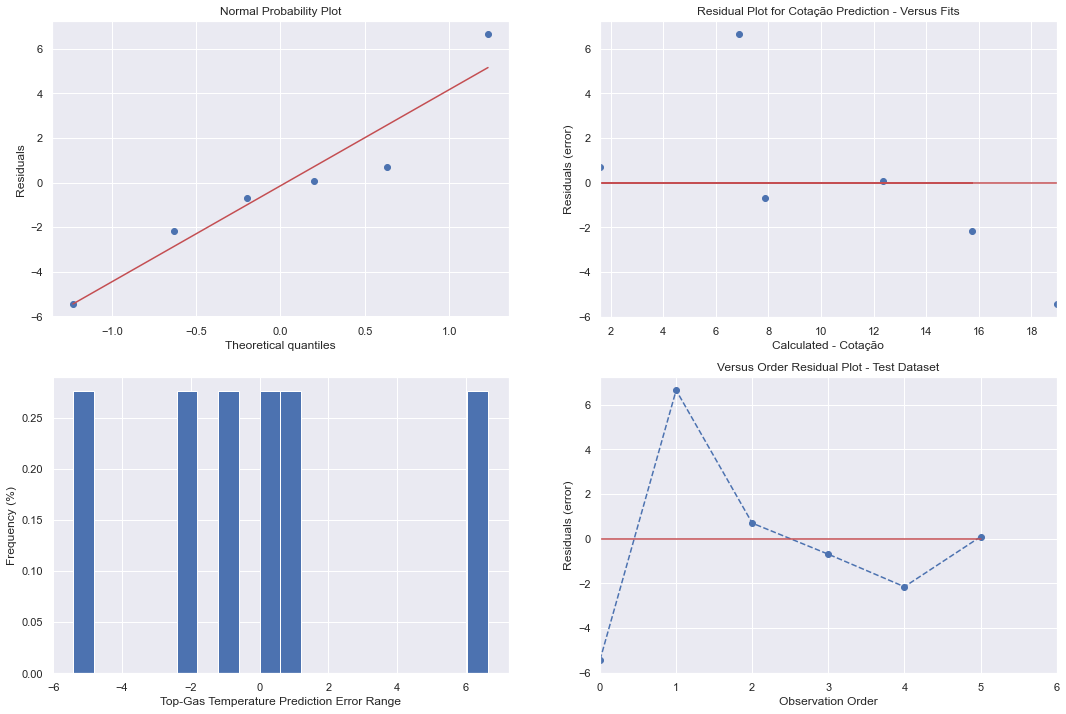

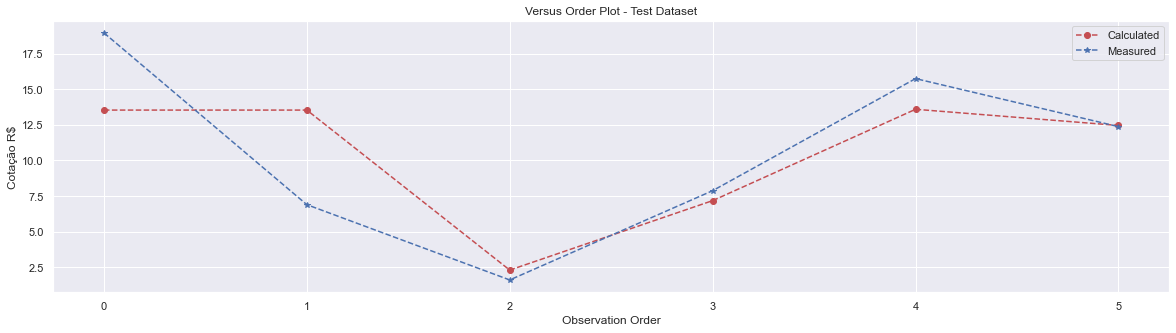

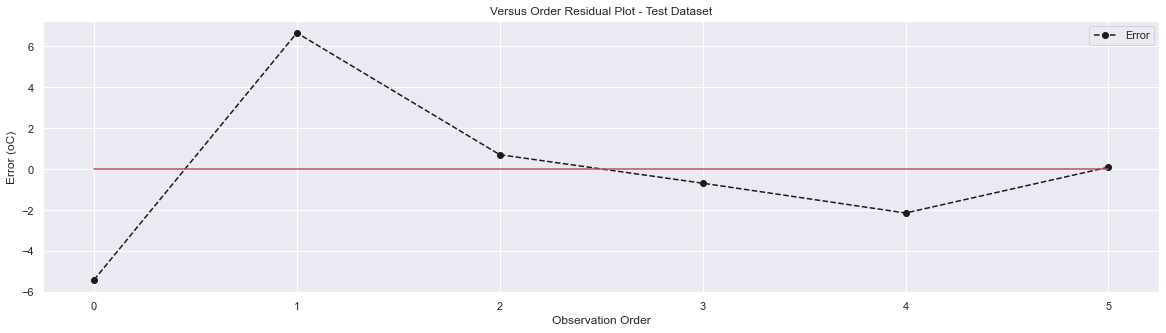

No handles with labels found to put in legend.


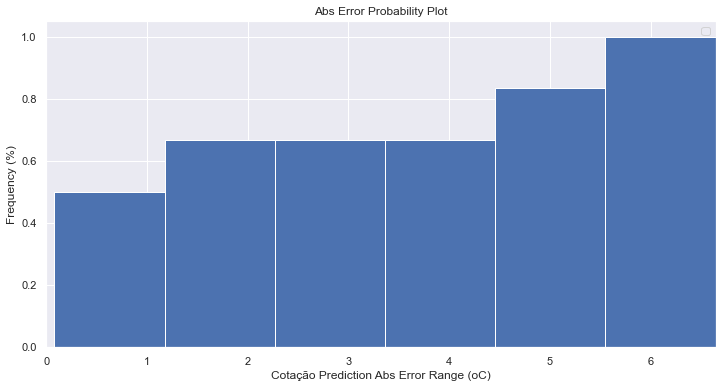

#####Teste dataset error evaluation#####
Test Size: 6  Samples
The Percentage of Abs Error Smaller 1 oC is: 50.0 %
The Percentage of Abs Error Smaller 2 oC is: 50.0 %
The Percentage of Abs Error Smaller 3 oC is: 66.66666666666667 %
The Percentage of Abs Error Smaller 5 oC is: 66.66666666666667 %
The Percentage of Abs Error Smaller 10 oC is: 100.0 %


In [23]:
plt.figure(figsize=(18,12))

plt.subplot(221)
p1 = stats.probplot((y_pred_LGBM-y_test), plot=plt)
plt.title('Normal Probability Plot')
plt.ylabel('Residuals')

plt.subplot(222)
plt.scatter(y_test,(y_pred_LGBM-y_test), c='b')
plt.plot(y_test, np.zeros(len(y_test)), c='r')
plt.xlabel('Calculated - Cotação')
plt.ylabel('Residuals (error)')
plt.xlim(y_test.min(),y_test.max())
plt.title('Residual Plot for Cotação Prediction - Versus Fits')

plt.subplot(223)
plt.hist((y_pred_LGBM-y_test), bins = 20, color = ('b'), cumulative = False,density= True);
#plt.xlim([-30, 30])
plt.xlabel('Top-Gas Temperature Prediction Error Range')
plt.ylabel('Frequency (%)')


plt.subplot(224)
plt.plot((y_pred_LGBM-y_test), c='b', marker = 'o', markersize=6, linestyle='--')
plt.plot(np.zeros(len(y_test)), c='r')
plt.xlabel('Observation Order')
plt.ylabel('Residuals (error)')
plt.xlim(0,len(y_test))
plt.title('Versus Order Residual Plot - Test Dataset')


plt.show();

plt.figure(figsize=(20,5))
plt.plot((y_pred_LGBM), c='r', marker = 'o', markersize=6, linestyle='--', label='Calculated')
plt.plot((y_test), c='b', marker = '*', markersize=6, linestyle='--', label='Measured')

plt.xlabel('Observation Order')
plt.ylabel('Cotação R$')
#plt.xlim(0,10)
#plt.ylim(1620, 1750)
plt.title('Versus Order Plot - Test Dataset')
plt.legend()

plt.show();

plt.figure(figsize=(20,5))
plt.plot((y_pred_LGBM-y_test), c='k', marker = 'o', markersize=6, linestyle='--', label='Error')
plt.plot(np.zeros(len(y_test)), c='r')

plt.xlabel('Observation Order')
plt.ylabel('Error (oC)')
#plt.xlim(0,len(y_test))
#plt.xlim(0,120)
#plt.ylim(-30, 30)
plt.title('Versus Order Residual Plot - Test Dataset')
plt.legend()

plt.show();

#Performance do Modelo para a Meta +- 5 oc
erro = y_pred_LGBM-y_test
plt.subplots(figsize=(12,6))
plt.hist((abs(erro)), bins = int(abs(erro).max()), color = ('b'), cumulative = True,density= True);
plt.xlim([0, abs(erro).max()])
plt.xlabel('Cotação Prediction Abs Error Range (oC)')
plt.ylabel('Frequency (%)')
plt.title('Abs Error Probability Plot')

plt.legend()

plt.show();

print('#####Teste dataset error evaluation#####')
print('Test Size:', len(erro), ' Samples')
print('The Percentage of Abs Error Smaller 1 oC is:', 100*(abs(erro)<=1).sum()/len(erro), '%')
print('The Percentage of Abs Error Smaller 2 oC is:', 100*(abs(erro)<=2).sum()/len(erro),'%')
print('The Percentage of Abs Error Smaller 3 oC is:', 100*(abs(erro)<=3).sum()/len(erro),'%')
print('The Percentage of Abs Error Smaller 5 oC is:', 100*(abs(erro)<=5).sum()/len(erro),'%')
print('The Percentage of Abs Error Smaller 10 oC is:', 100*(abs(erro)<=10).sum()/len(erro),'%')

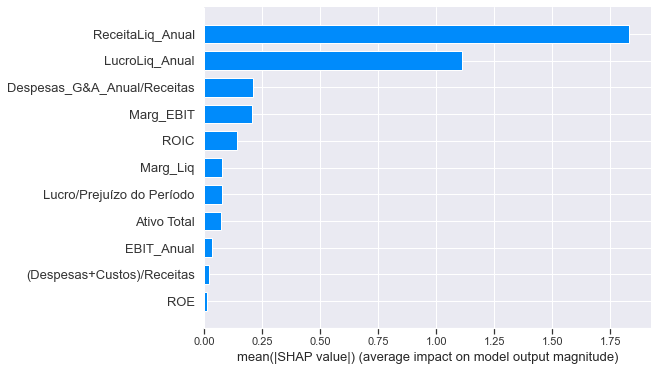

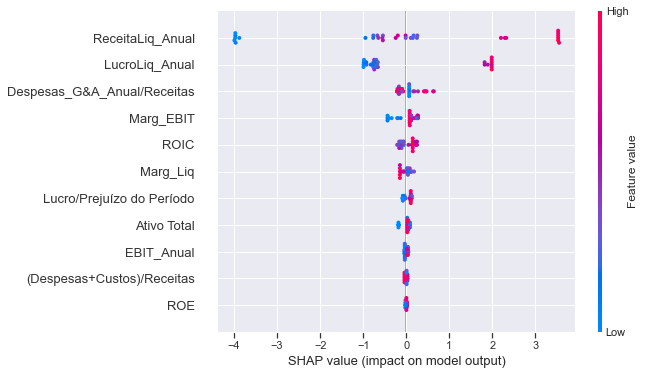

In [24]:
#Calcula dos Shap Values e Exibe Gráficos
feature_labels = inputs_labels
import shap
model = lgbm_model
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(x_train, 200)
shap.summary_plot(shap_values, x_train, plot_type="bar", feature_names = feature_labels)
shap.summary_plot(shap_values, x_train, feature_names = feature_labels)

In [25]:
#Ultimo Balanço
ultimo_balanco = df_BP_DRE.index.max()
ultimo_treinado = df_consolidado.index.max()
print('ultimo balanço de treino:',ultimo_treinado)
print('balanço de calculo:',ultimo_balanco)

ultimo balanço de treino: 2020-09-30 00:00:00
balanço de calculo: 2020-09-30 00:00:00


In [26]:
df_ult_balanco = df_BP_DRE.copy()

In [27]:
df_ult_balanco = df_ult_balanco.loc[df_BP_DRE.index == ultimo_balanco]

In [28]:
df_ult_balanco.head()

DATA,Receita Bruta de Vendas e/ou Serviços,Deduções da Receita Bruta,Receita Líquida de Vendas e/ou Serviços,Custo de Bens e/ou Serviços Vendidos,Resultado Bruto,Despesas Com Vendas,Despesas Gerais e Administrativas,Perdas pela Não Recuperabilidade de Ativos,Outras Receitas Operacionais,Outras Despesas Operacionais,...,Despesas_G&A_Anual/Receitas,(Despesas+Custos)/Receitas,Despesas_Financeiras_Anuais,Marg_EBIT,Marg_Liq,EBIT/Ativos,ROIC,ROE,SIN_MES,COS_MES
2020-09-30,NaN,NaN,1.16669e+06,-503668,663023,-124691,-217998,0,0,-19725,...,0.144059,0.6563,254353.992,0.208483,0.141066,0.112396,0.130684,0.164001,-1.0,-1.836970e-16


In [29]:
df_BP_DRE.tail()

DATA,Receita Bruta de Vendas e/ou Serviços,Deduções da Receita Bruta,Receita Líquida de Vendas e/ou Serviços,Custo de Bens e/ou Serviços Vendidos,Resultado Bruto,Despesas Com Vendas,Despesas Gerais e Administrativas,Perdas pela Não Recuperabilidade de Ativos,Outras Receitas Operacionais,Outras Despesas Operacionais,...,Despesas_G&A_Anual/Receitas,(Despesas+Custos)/Receitas,Despesas_Financeiras_Anuais,Marg_EBIT,Marg_Liq,EBIT/Ativos,ROIC,ROE,SIN_MES,COS_MES
2019-09-30,NaN,NaN,1.18534e+06,-476608,708728,-91370,-148326,0,0,-66157,...,0.130494,0.664948,239189.000,0.300776,0.205545,0.113495,0.125135,0.168258,-1.000000e+00,-1.836970e-16
2019-12-31,NaN,NaN,1.33962e+06,-501234,838384,-92336,-162825,-19391,0,-17601,...,0.124196,0.648657,245916.992,0.372598,0.288381,0.12177,0.135008,0.174935,-2.449294e-16,1.000000e+00
2020-03-31,NaN,NaN,1.24614e+06,-461545,784591,-95715,-157209,0,0,-96374,...,0.125623,0.646200,255244.992,0.305955,0.205455,0.120223,0.138634,0.173954,1.000000e+00,6.123234e-17
2020-06-30,NaN,NaN,1.15004e+06,-479679,670360,-101360,-168215,0,0,-17327,...,0.129355,0.636822,242147.992,0.305132,0.247284,0.123921,0.143741,0.180343,1.224647e-16,-1.000000e+00
2020-09-30,NaN,NaN,1.16669e+06,-503668,663023,-124691,-217998,0,0,-19725,...,0.144059,0.656300,254353.992,0.208483,0.141066,0.112396,0.130684,0.164001,-1.000000e+00,-1.836970e-16


# Previsão dos Preços Futuros

In [30]:
print(inputs_labels)
df_cont_inputs_prev = df_ult_balanco[cont_inputs_labels]
df_categ_inputs_prev = df_ult_balanco[categ_inputs_labels]

['ReceitaLiq_Anual' 'LucroLiq_Anual' 'Lucro/Prejuízo do Período'
 'Despesas_G&A_Anual/Receitas' '(Despesas+Custos)/Receitas' 'Ativo Total'
 'Marg_EBIT' 'Marg_Liq' 'EBIT_Anual' 'ROIC' 'ROE']


In [31]:
df_cont_inputs_prev

DATA,ReceitaLiq_Anual,LucroLiq_Anual,Lucro/Prejuízo do Período,Despesas_G&A_Anual/Receitas,(Despesas+Custos)/Receitas,Ativo Total,Marg_EBIT,Marg_Liq,EBIT_Anual,ROIC,ROE
2020-09-30,4902484.224,1091312.032,164580,0.144059,0.6563,1.31192e+07,0.208483,0.141066,1474549.024,0.130684,0.164001


In [32]:
numpy_categ_inputs_prev = df_categ_inputs_prev.values
numpy_cont_inputs_prev = df_cont_inputs_prev.values
numpy_cont_inputs_scaled_prev = scaler.transform(numpy_cont_inputs_prev)
print("scaled inputs:", numpy_cont_inputs_scaled_prev)

scaled inputs: [[ 1.21618592  1.88703289  0.45151229 -0.78442597 -1.35651916  1.27376277
  -0.4211317  -0.61940537  1.92699072  1.53508586  1.01092664]]


In [33]:
cotacao_futura = lgbm_model.predict(numpy_cont_inputs_scaled_prev)
print(cotacao_futura)

[13.88286242]


In [34]:
data_ini_ref = '2020, 12, 01'
data_fim_ref = '2020, 12, 31'
df_cotacao_referencia = read_cotacao_hist(empresa,data_ini_ref, data_fim_ref)
df_cotacao__referencia_mes = df_cotacao_referencia.resample('M', on='Date', convention='end').mean()

In [35]:
from datetime import datetime
today = datetime.today().strftime('%Y-%m-%d')
print(today)

2021-01-06


In [36]:
cotacao_hoje = read_cotacao_hist(empresa,today, today)

In [37]:
print("Ultimo balanço de treinamento:", ultimo_treinado)
print("Ultimo balanço utilizado na previsão:", ultimo_balanco)
print(empresa+'_R2_Score:', R2_modelo)
print('valor previsto_'+empresa+':', cotacao_futura)
print('valor de referencia_'+empresa+':', df_cotacao__referencia_mes['Close'].values)
print('valor de hoje_'+empresa+':', cotacao_hoje['Close'].values)
print('Desvio % do Valor Previsto vs Valor Referencia_'+empresa+':', 100*(cotacao_futura-df_cotacao__referencia_mes['Close'].values)/df_cotacao__referencia_mes['Close'].values, "%")
print('Desvio % do Valor Previsto vs Cotação de Hoje_'+empresa+':', 100*(cotacao_futura-cotacao_hoje['Close'].values)/cotacao_hoje['Close'].values, "%")

Ultimo balanço de treinamento: 2020-09-30 00:00:00
Ultimo balanço utilizado na previsão: 2020-09-30 00:00:00
SAPR3_R2_Score: 0.6073077275224135
valor previsto_SAPR3: [13.88286242]
valor de referencia_SAPR3: [5.77450001]
valor de hoje_SAPR3: [5.11999989]
Desvio % do Valor Previsto vs Valor Referencia_SAPR3: [140.41670088] %
Desvio % do Valor Previsto vs Cotação de Hoje_SAPR3: [171.14966274] %
